In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

num=3039 #5000
n_classes=11 #12
n_epochs=4000 #500
#pzflow_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{pzflow_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
dataset_bank_tns_df_resampled_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21abmgtat                   0.121904   
ZTF18achdfqm                   0.470350   
ZTF21aagsihi                   1.877941   
ZTF19aapswkx                   0.186474   
ZTF20aclkhnm                   0.739245   
...                                 ...   
ZTFabc78716                    0.015157   
ZTFabc18519                    1.527152   
ZTFabc55421                    0.330276   
ZTFabc56906                    0.642781   
ZTFabc81029                    0.619938   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21abmgtat                                 0.230847   
ZTF18achdfqm                                 0.474306   
ZTF21aagsihi                                 1.139061   
ZTF19aapswkx                                 0.116516   
ZTF20aclkhnm                                 1.139875   
...                                               ...   
ZTFabc78716                                  5.287381   
ZTFabc18519                                  0.399389   
ZTFabc55421                                  0.887094   
ZTFabc56906                                  4.571017   
ZTFabc81029                                  5.957200   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21abmgtat                      0.333333                     0.000000   
ZTF18achdfqm                      0.333333                     0.000000   
ZTF21aagsihi                      0.375000                     0.000000   
ZTF19aapswkx                      0.500000                     0.000000   
ZTF20aclkhnm                      0.166667                     0.083333   
...                                    ...                          ...   
ZTFabc78716                       0.392500                     0.053569   
ZTFabc18519                       0.388678                     0.031452   
ZTFabc55421                       0.117378                     0.008601   
ZTFabc56906                       0.394913                     0.049909   
ZTFabc81029                       0.242537                    -0.000013   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21abmgtat               0.261333                                 0.243809   
ZTF18achdfqm               0.417916                                 0.940701   
ZTF21aagsihi               0.450437                                 3.729228   
ZTF19aapswkx               0.418552                                 0.372948   
ZTF20aclkhnm               0.395673                                 1.478491   
...                             ...                                      ...   
ZTFabc78716                0.407816                                 1.004380   
ZTFabc18519                0.341625                                 2.036185   
ZTFabc55421                0.412652                                 1.002673   
ZTFabc56906                0.376647                                 1.775805   
ZTFabc81029                0.486997                                 2.471809   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21abmgtat                                   0.230761   
ZTF18achdfqm                                   0.908838   
ZTF21aagsihi                                   3.119188   
ZTF19aapswkx                                   0.372948   
ZTF20aclkhnm                                   1.095229   
...                                                 ...   
ZTFabc78716                                    2.397410   
ZTFabc18519                                    2.388125   
ZTFabc55421                                    0.682406   
ZTFabc56906                                    

In [5]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

In [6]:
np.unique(np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [38]:
%%time

# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

param_grid = {'max_depth': [30, 60, 90],
              'class_weight': [{"None": 1, "SLSN-II": w, "SN II": w, 'SN IIP': w, 'SN IIb': w, 'SN IIn': w, 'SN Ia': 1,
       'SN Ia-91T-like': w, 'SN Ib': w, 'SN Ic': w, 'SN Ic-BL': w, 'TDE': w} for w in range(1, 3)], 
             'max_features': [30, 60, 90],
             }
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
grid_search.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'class_weight': {'None': 1, 'SLSN-II': 1, 'SN II': 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1, 'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1}, 'max_depth': 30, 'max_features': 30}
CPU times: user 1min 56s, sys: 494 ms, total: 1min 56s
Wall time: 55min 39s


In [70]:
n_estimators=100 #3500
max_depth=60 #35
random_state=10
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"

In [71]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             random_state=random_state, 
                             max_features=max_features,
                             class_weight=class_weight,
                             verbose=1, 
                             n_jobs=-1)
clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s


CPU times: user 3min 9s, sys: 514 ms, total: 3min 10s
Wall time: 26.4 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.3s finished


RandomForestClassifier(class_weight={'None': 1, 'SLSN-II': 1, 'SN II': 1,
                                     'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1,
                                     'SN Ia': 1, 'SN Ia-91T-like': 1,
                                     'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1,
                                     'TDE': 1},
                       max_depth=60, max_features=35, n_jobs=-1,
                       random_state=10, verbose=1)

In [72]:
pkl_path = f"../pickles/{pzflow_suffix}/"
if not os.path.exists(pkl_path):
    os.makedirs(pkl_path)
pickle.dump(clf, open(f'../pickles/{pzflow_suffix}/PZFLOW_RFC_model_grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1.pkl', 'wb'))


### Load pickle

In [73]:
with open(f'../pickles/{pzflow_suffix}/PZFLOW_RFC_model_grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1.pkl', 'rb') as f:
    clf = pickle.load(f)

In [74]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(dataset_bank_tns_df_resampled_test.iloc[:, 0:120])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [75]:
clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [76]:
# Predicted Probability to be ['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
#                              'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']
predicted_probability

array([[58.,  0.,  1., ...,  0.,  1.,  1.],
       [15.,  0., 23., ...,  7.,  0.,  0.],
       [26.,  1., 18., ...,  0.,  0., 12.],
       ...,
       [38.,  0.,  5., ...,  0.,  1.,  0.],
       [71.,  1.,  6., ...,  2.,  3.,  3.],
       [34.,  1.,  3., ...,  0.,  6.,  1.]])

In [77]:
clf.classes_[1:]

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [78]:
predicted_probability.shape

(300, 12)

In [79]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(dataset_bank_tns_df_resampled_test.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
df

None  SLSN-II  SN II  SN IIP  SN IIb  SN IIn  SN Ia  \
ztf_object_id                                                        
ZTF21aazebgh   58.0      0.0    1.0     7.0     0.0     1.0   31.0   
ZTF21acgxypn   15.0      0.0   23.0    10.0     7.0     2.0    7.0   
ZTF19aapqqrb   26.0      1.0   18.0     8.0     0.0     1.0   32.0   
ZTF21aasbxng    6.0      0.0   11.0     1.0     3.0     1.0   63.0   
ZTF21aaglgcb   32.0     10.0    1.0     0.0     0.0     5.0   49.0   
...             ...      ...    ...     ...     ...     ...    ...   
ZTF21acbntop   19.0      0.0    4.0    12.0     3.0     1.0   32.0   
ZTF21acjgmiy   56.0      0.0    4.0     8.0     0.0     0.0    8.0   
ZTF22aaagxev   38.0      0.0    5.0     4.0     1.0     1.0   46.0   
ZTF21abtdvpg   71.0      1.0    6.0     2.0     1.0     3.0    5.0   
ZTF20acjfimy   34.0      1.0    3.0     0.0     2.0     2.0   49.0   

               SN Ia-91T-like  SN Ib  SN Ic  SN Ic-BL   TDE RFC_best_cls  
ztf_object_id                                                             
ZTF21aazebgh              0.0    0.0    0.0       1.0   1.0        SN Ia  
ZTF21acgxypn              0.0   29.0    7.0       0.0   0.0        SN Ib  
ZTF19aapqqrb              2.0    0.0    0.0       0.0  12.0        SN Ia  
ZTF21aasbxng             12.0    0.0    1.0       2.0   0.0        SN Ia  
ZTF21aaglgcb              2.0    0.0    1.0       0.0   0.0        SN Ia  
...                       ...    ...    ...       ...   ...          ...  
ZTF21acbntop              3.0   20.0    5.0       0.0   1.0        SN Ia  
ZTF21acjgmiy              1.0   19.0    1.0       3.0   0.0        SN Ib  
ZTF22aaagxev              3.0    1.0    0.0       1.0   0.0        SN Ia  
ZTF21abtdvpg              3.0    0.0    2.0       3.0   3.0        SN II  
ZTF20acjfimy              2.0    0.0    0.0       6.0   1.0        SN Ia  

[300 rows x 13 columns]

In [80]:
df2 = pd.concat([dataset_bank_tns_df_resampled_test, df], axis=1)
df2

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

In [81]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

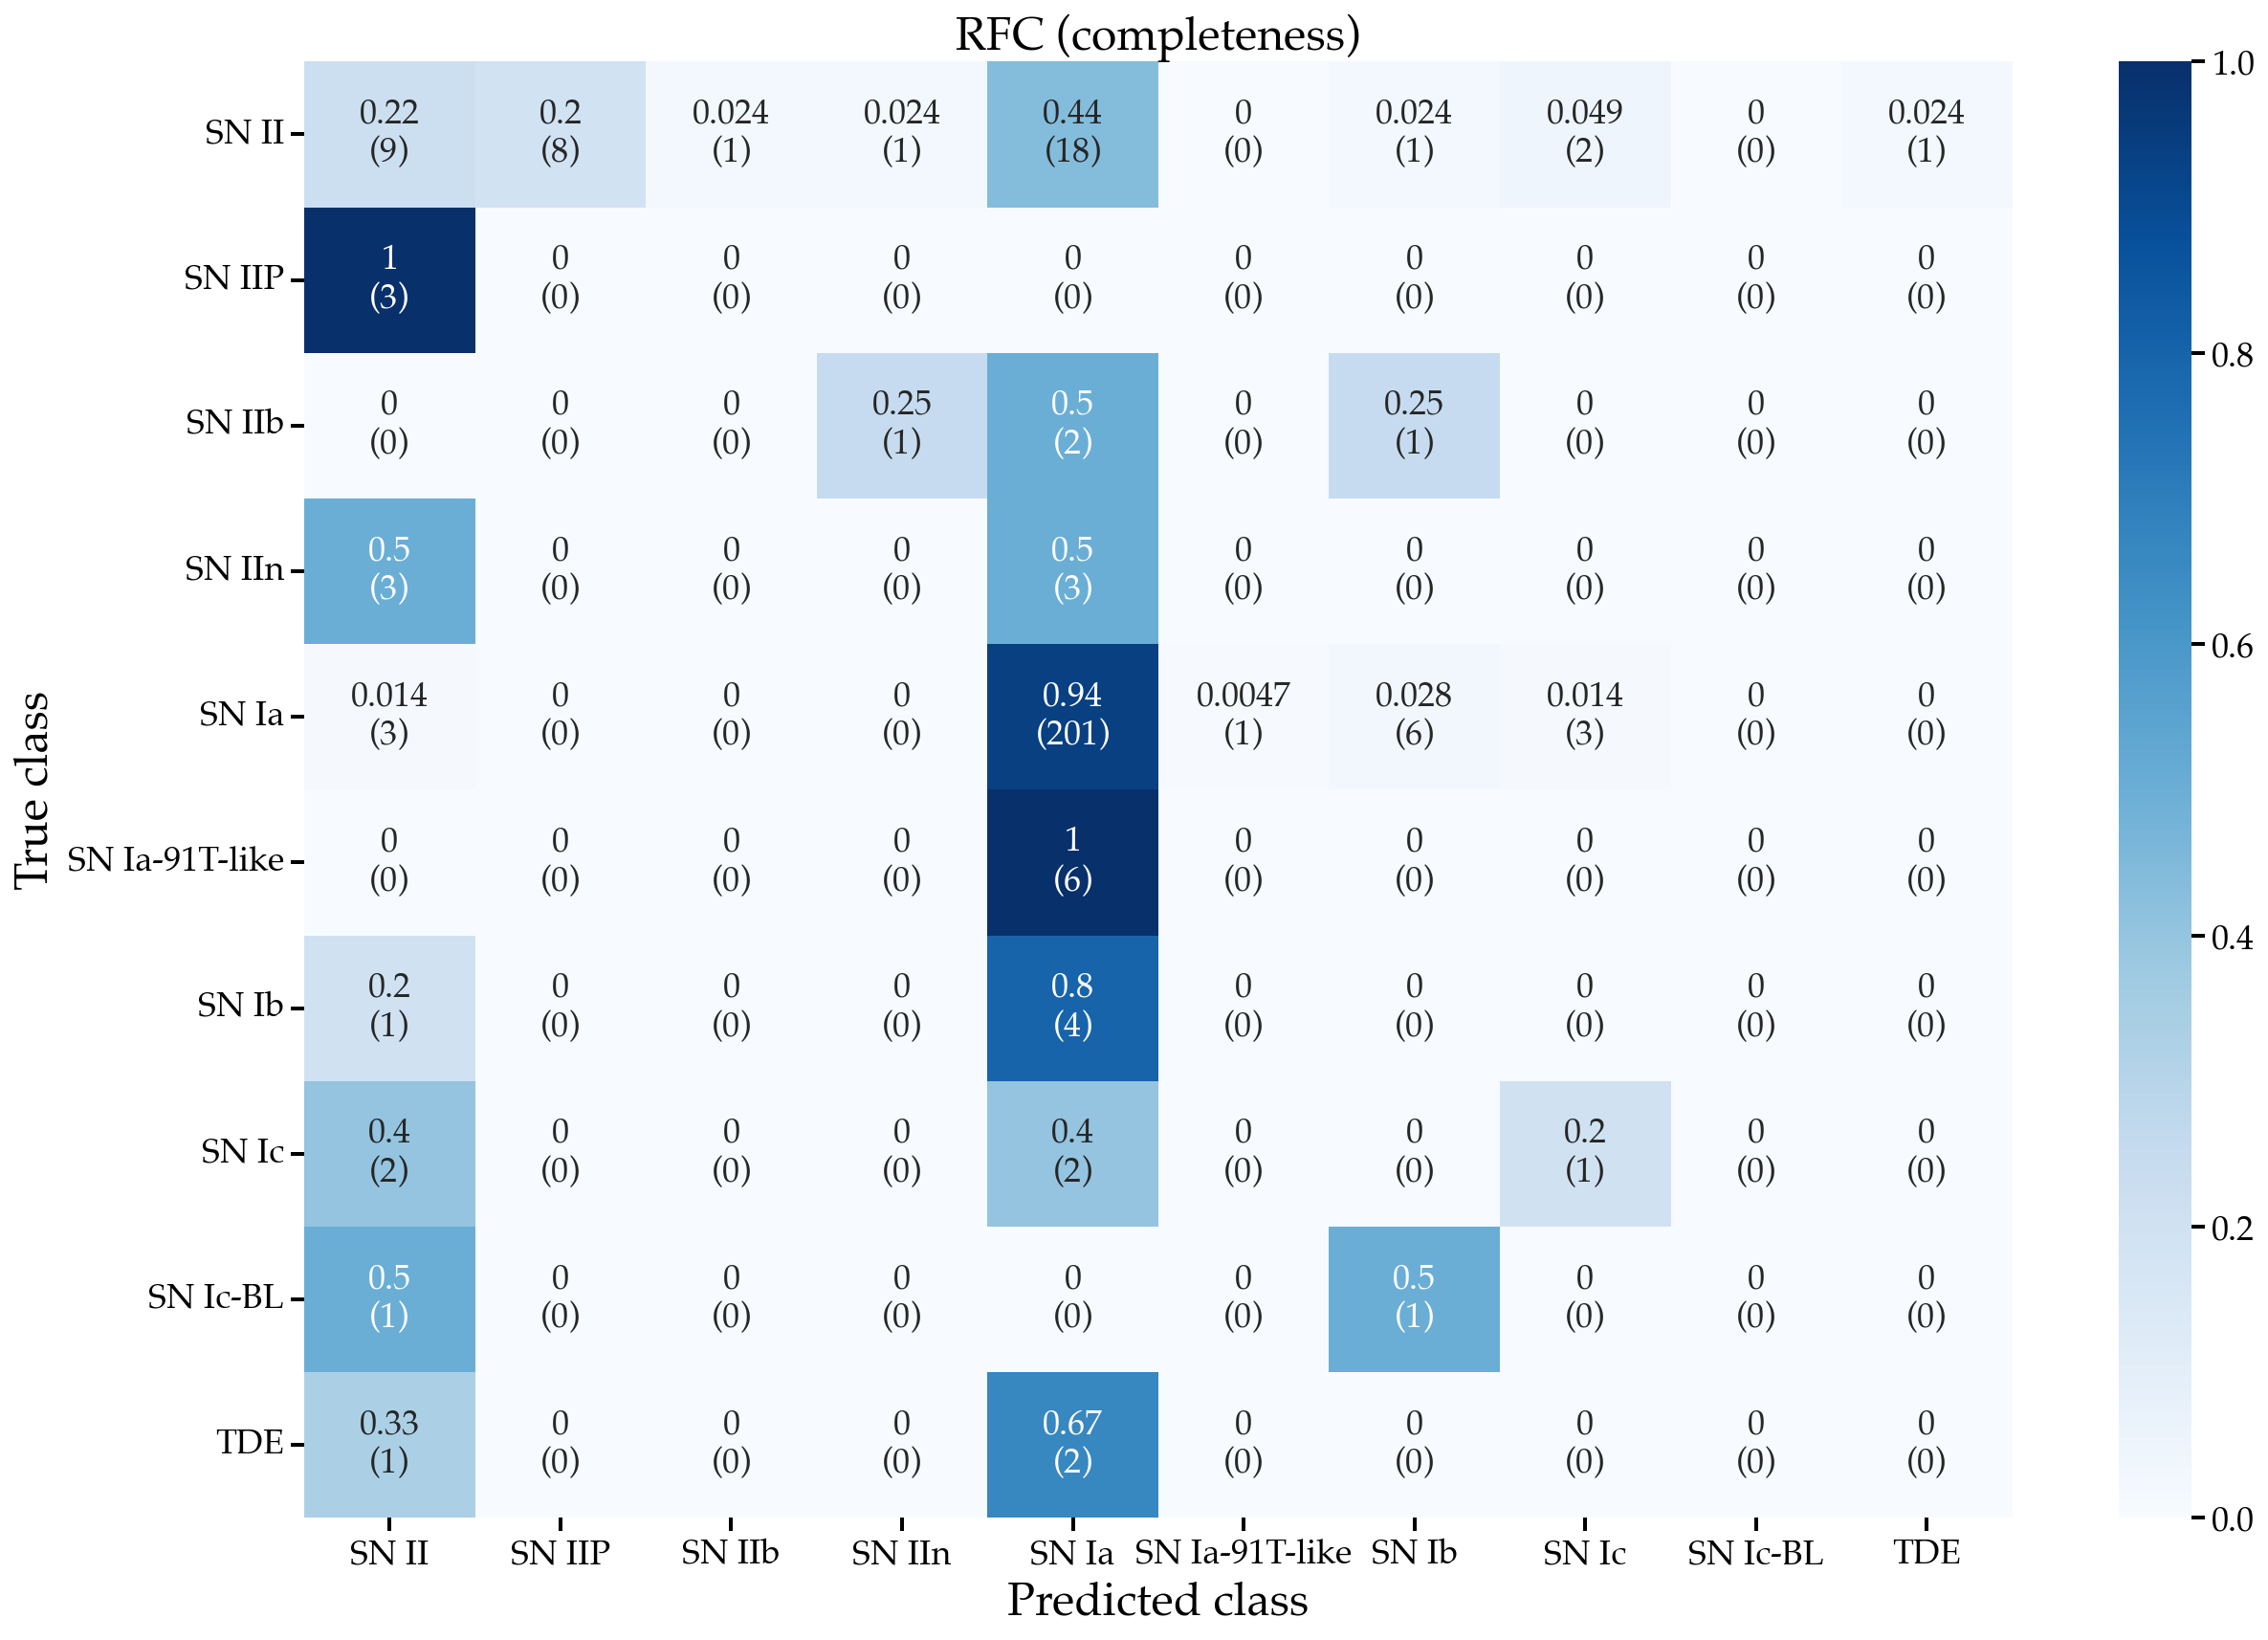

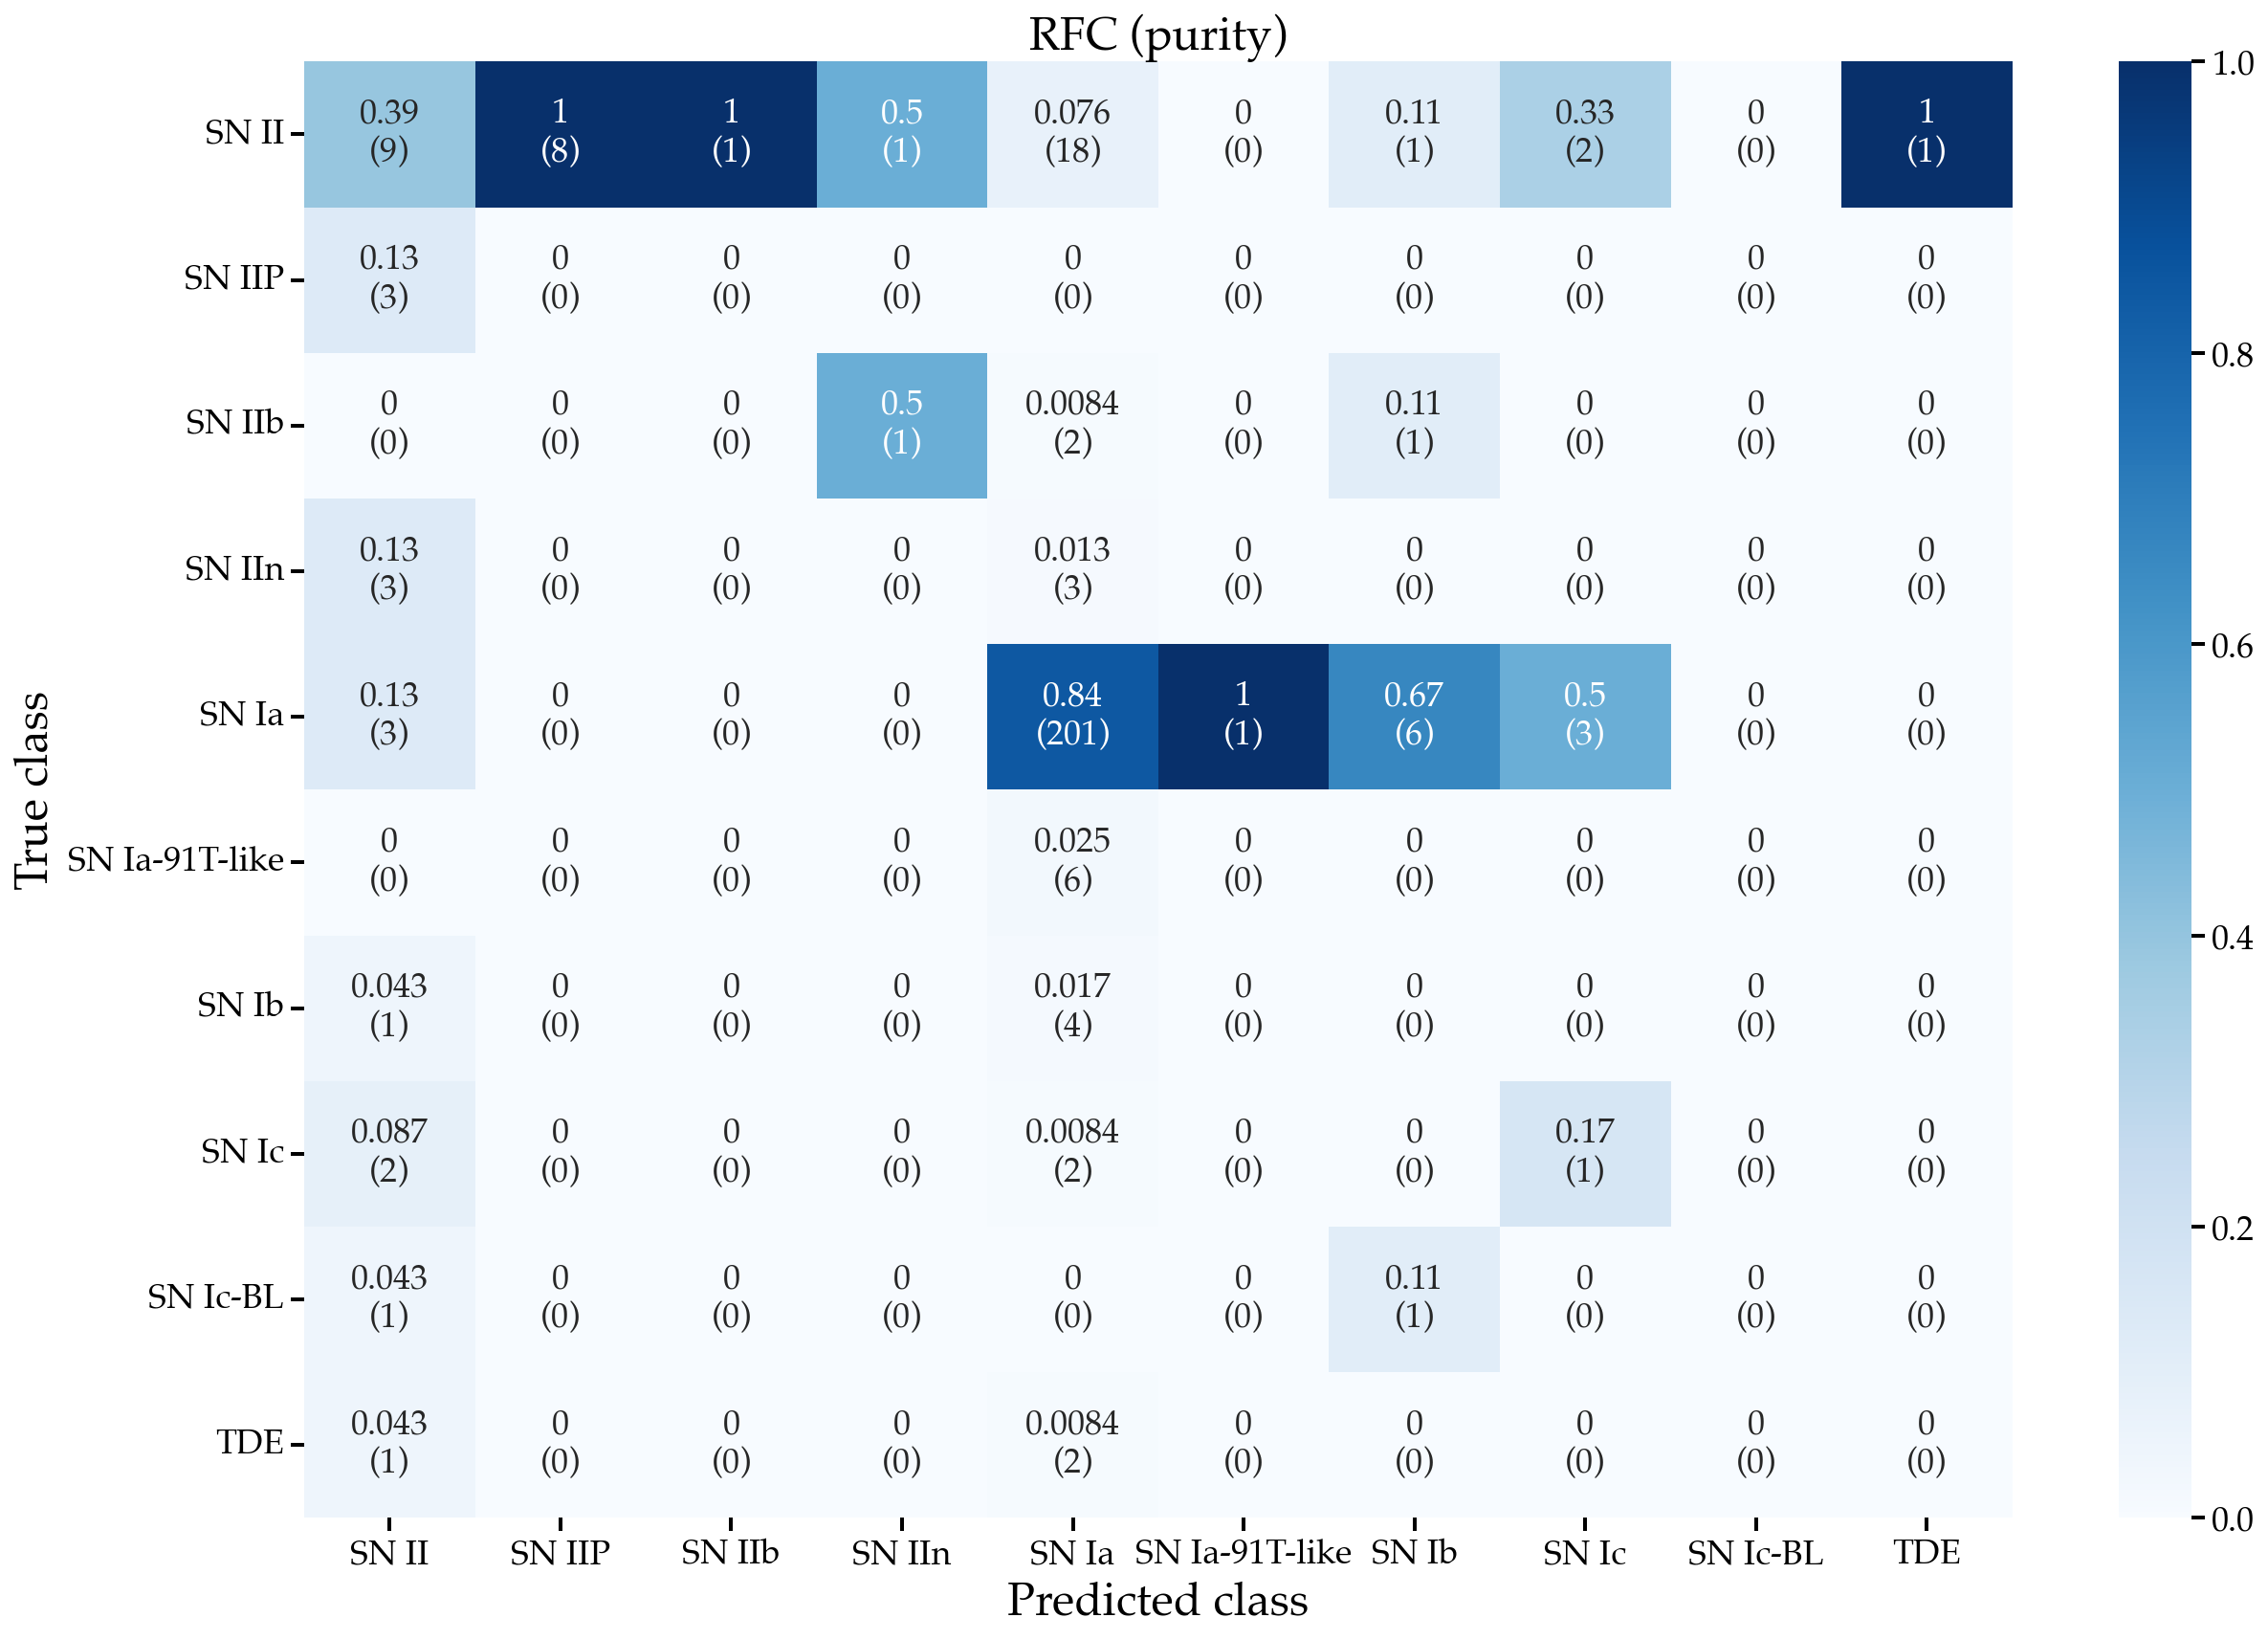

In [82]:
# Confusion matrices
title='RFC'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

folder_path = f"../figures/confusion_matrix/{suffix}/grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [83]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = df2.copy()
ann0_ann1_df_noNone_sim_class['tns_cls'] = ann0_ann1_df_noNone_sim_class['tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['RFC_best_cls'] = ann0_ann1_df_noNone_sim_class['RFC_best_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [84]:
ann0_ann1_df_noNone_sim_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

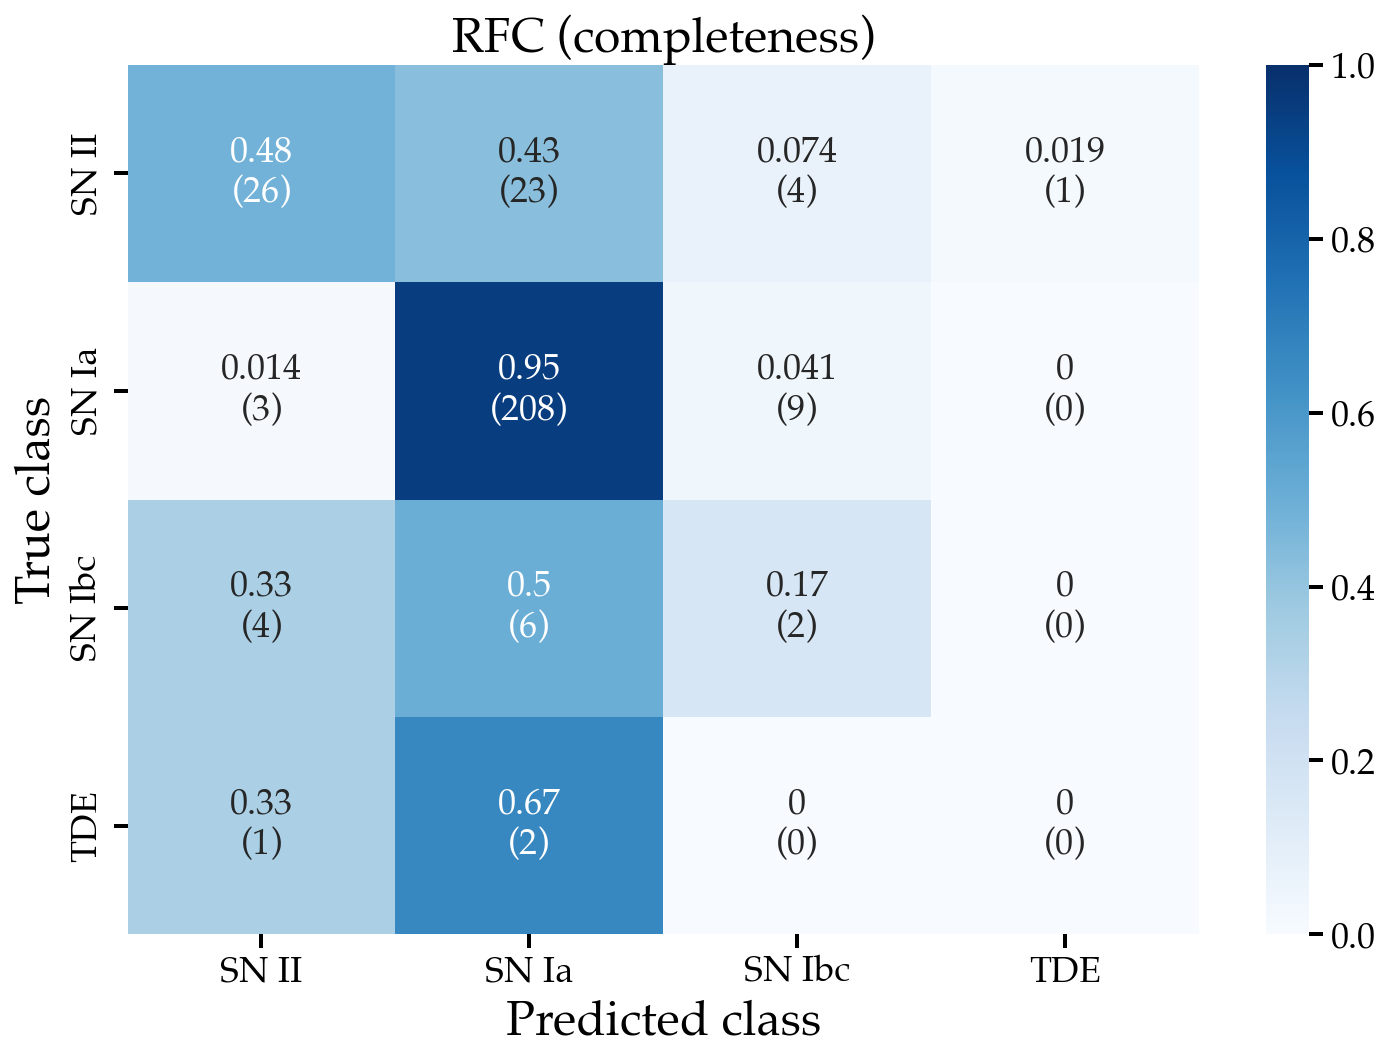

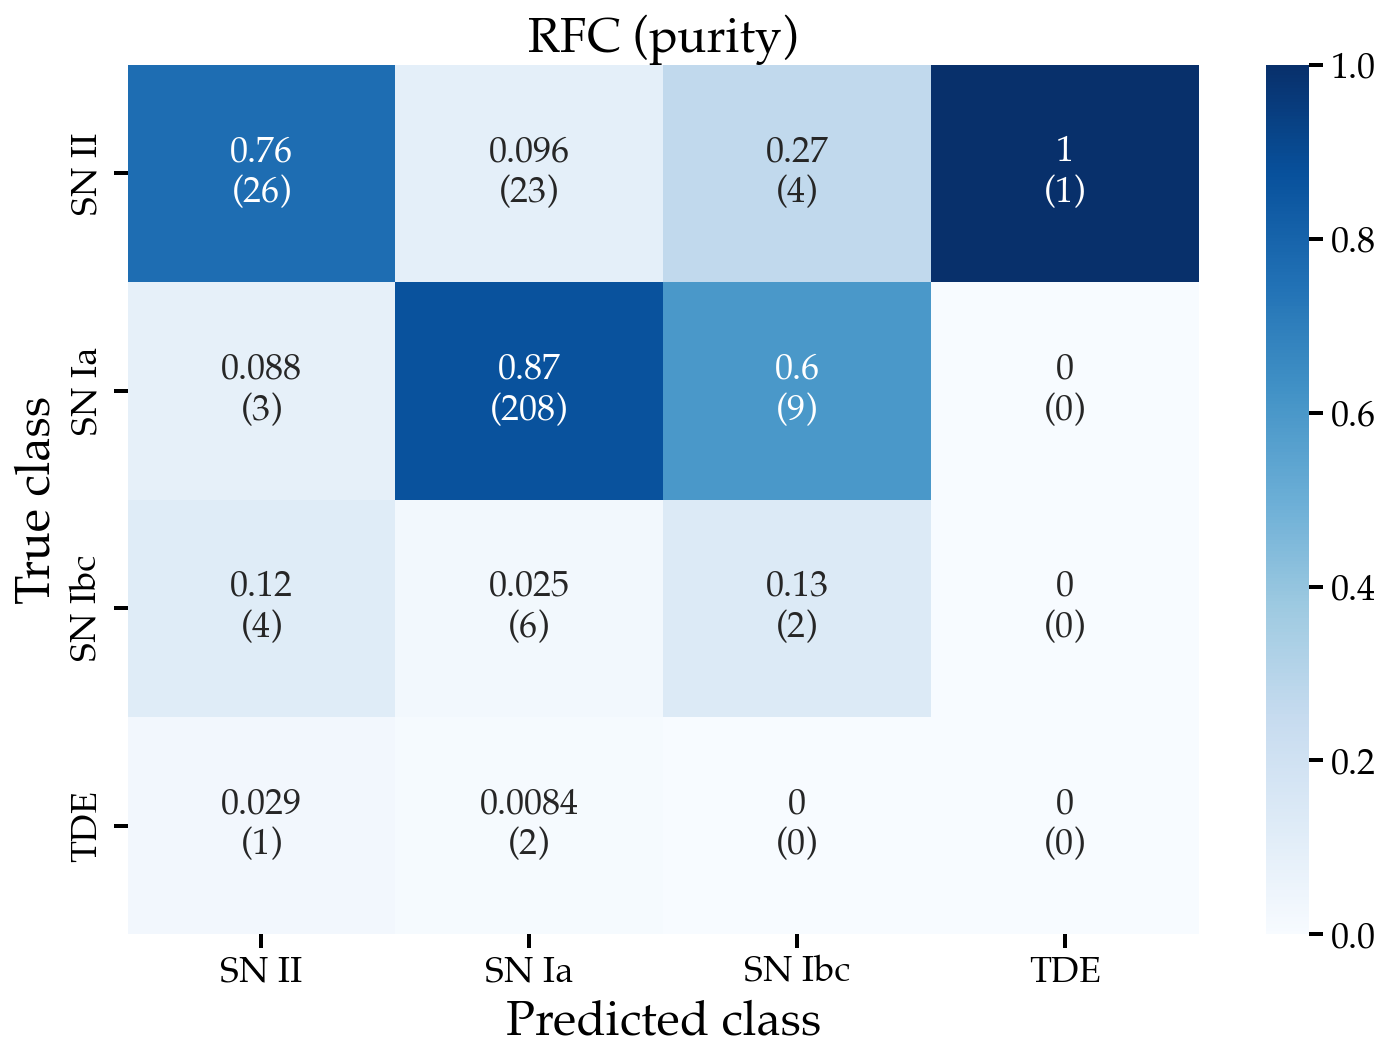

In [85]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [86]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = df2.copy()
ann0_ann1_df_noNone_bin_class['tns_cls'] = ann0_ann1_df_noNone_bin_class['tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['RFC_best_cls'] = ann0_ann1_df_noNone_bin_class['RFC_best_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [87]:
mask = (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

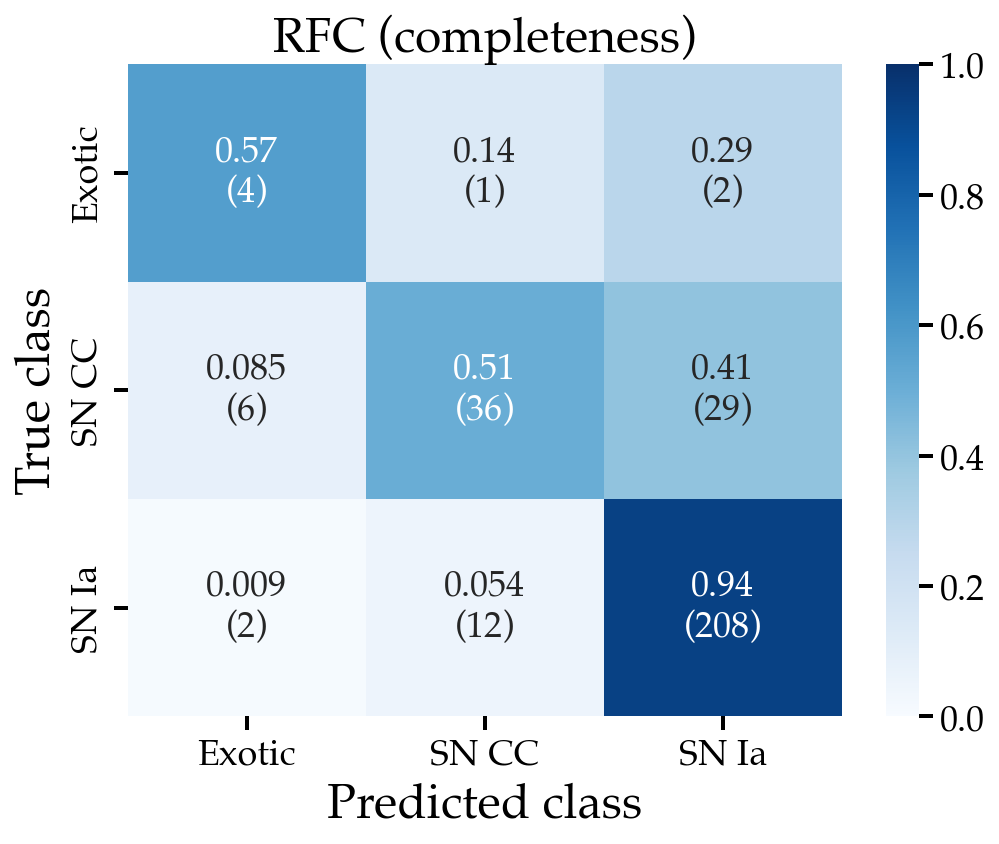

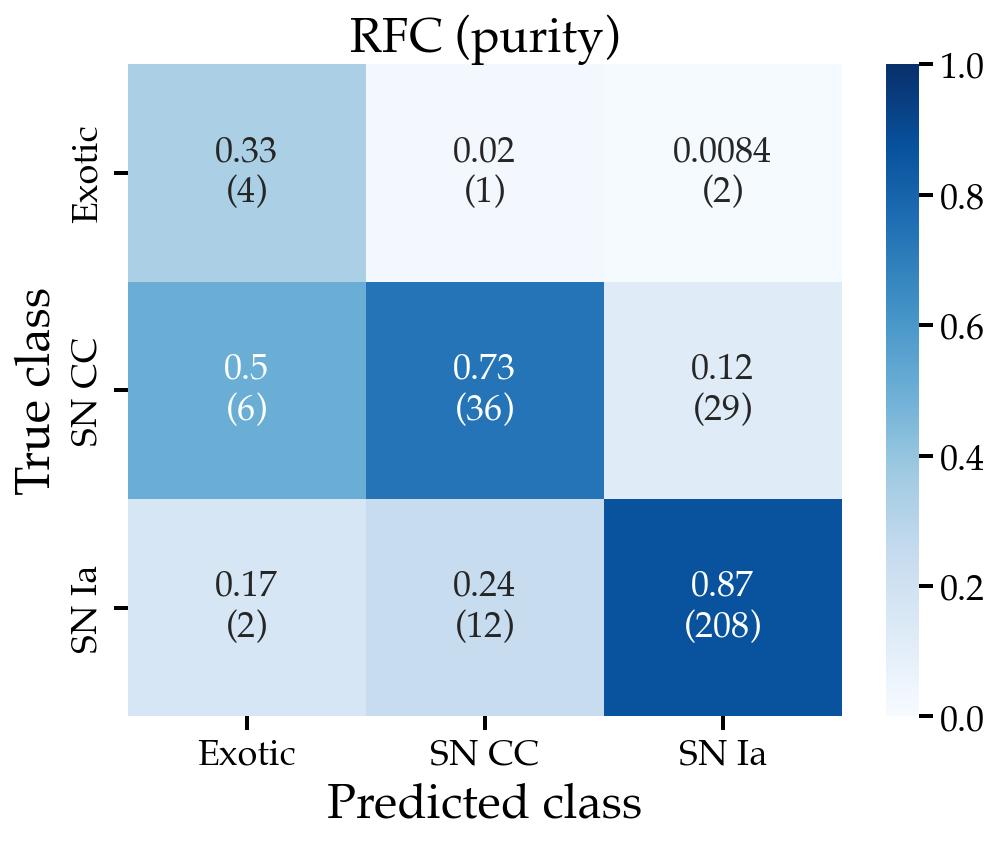

In [88]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here are Ia and rare Ia subtypes. Results w/o redshift too! And only 2 pbs

In [89]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = df2.copy()
ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'] = ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [90]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

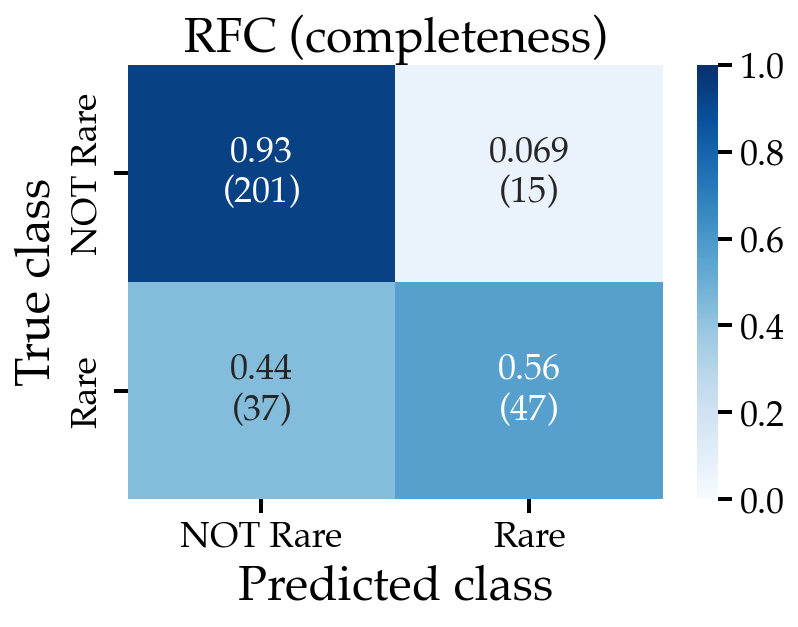

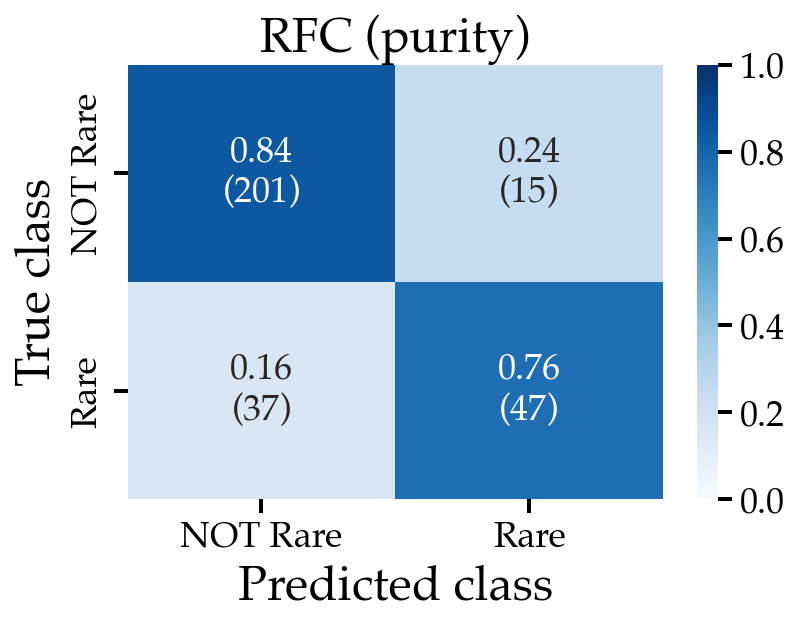

In [91]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here is Ia-norm ONLY. The rare Ia subtypes are in the "Rare" classification. Results w/o redshift too! And only 2 pbs

In [92]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=500, random_state=10).fit(predicted_probability).decision_function(predicted_probability)

CPU times: user 861 ms, sys: 41.9 ms, total: 903 ms
Wall time: 767 ms


In [93]:
most_anomalous_indices = np.argsort(anomaly_scores)[:25]
most_anomalous_samples = df2.iloc[most_anomalous_indices]
most_anomalous_samples

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21abcmtev                   0.453838   
ZTF20abwxywy                   1.634157   
ZTF20acjsazw                   1.011811   
ZTF21aaabwfu                   0.726729   
ZTF21abfxjkq                   1.175756   
ZTF21aabygea                   1.121072   
ZTF21aavrvuj                   0.242250   
ZTF21aamwqim                   0.968200   
ZTF21abchjer                   0.913735   
ZTF21acmrdga                   0.795146   
ZTF21aaagypx                   0.588448   
ZTF18acvgjqv                   1.061049   
ZTF20accmtgt                   1.348523   
ZTF20actekrw                   0.489840   
ZTF20actkutp                   0.678516   
ZTF20acfkyll                   0.446079   
ZTF20abarsvz                   0.994728   
ZTF20acxbbaj                   1.209187   
ZTF21aagyxgr                   0.586423   
ZTF20abyzomt                   0.561564   
ZTF21acnfoqn                   0.780834   
ZTF22aaaepao                   0.121577   
ZTF21acgxypn                   0.541942   
ZTF20acxqxyw                   0.806231   
ZTF19aaeuhgo                   1.248150   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21abcmtev                                 0.294889   
ZTF20abwxywy                                 0.994964   
ZTF20acjsazw                                 0.498942   
ZTF21aaabwfu                                 0.344801   
ZTF21abfxjkq                                 2.274387   
ZTF21aabygea                                 4.941580   
ZTF21aavrvuj                                 0.419557   
ZTF21aamwqim                                 0.365258   
ZTF21abchjer                                 0.840731   
ZTF21acmrdga                                 0.320703   
ZTF21aaagypx                                 1.259935   
ZTF18acvgjqv                                 0.732289   
ZTF20accmtgt                                 0.240779   
ZTF20actekrw                                 1.396014   
ZTF20actkutp                                 1.128775   
ZTF20acfkyll                                 0.839118   
ZTF20abarsvz                                 0.497720   
ZTF20acxbbaj                                 0.595493   
ZTF21aagyxgr                                 0.724265   
ZTF20abyzomt                                 0.484701   
ZTF21acnfoqn                                 0.125459   
ZTF22aaaepao                                 0.670996   
ZTF21acgxypn                                 0.743175   
ZTF20acxqxyw                                 0.634359   
ZTF19aaeuhgo                                10.328723   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21abcmtev                      0.407407                     0.000000   
ZTF20abwxywy                      0.423077                     0.000000   
ZTF20acjsazw                      0.470588                     0.000000   
ZTF21aaabwfu                      0.357143                     0.000000   
ZTF21abfxjkq                      0.419355                     0.000000   
ZTF21aabygea                      0.173913                     0.086957   
ZTF21aavrvuj                      0.421053                     0.000000   
ZTF21aamwqim                      0.421053                     0.000000   
ZTF21abchjer                      0.300000                     0.000000   
ZTF21acmrdga                      0.166667                     0.000000   
ZTF21aaagypx                      0.236842                     0.039474   
ZTF18acvgjqv                      0.375000                     0.031250   
ZTF20accmtgt                      0.347826                     0.000000   
ZTF20actekrw                      0.166667                     0.083333   
ZTF20actkutp                      0.322581                     0.064516   
ZTF20acfkyll                      0.34

In [94]:
for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF21abcmtev SN II SN II
https://alerce.online/object/ZTF20abwxywy SN Ic SN Ic
https://alerce.online/object/ZTF20acjsazw SN Ia SN Ic
https://alerce.online/object/ZTF21aaabwfu SN IIb SN IIn
https://alerce.online/object/ZTF21abfxjkq SN II SN Ic
https://alerce.online/object/ZTF21aabygea SN II SN IIn
https://alerce.online/object/ZTF21aavrvuj SN II SN IIP
https://alerce.online/object/ZTF21aamwqim SN II SN IIb
https://alerce.online/object/ZTF21abchjer SN Ic-BL SN II
https://alerce.online/object/ZTF21acmrdga SN IIb SN Ib
https://alerce.online/object/ZTF21aaagypx SN IIP SN II
https://alerce.online/object/ZTF18acvgjqv SN IIn SLSN-II
https://alerce.online/object/ZTF20accmtgt SN Ia SN Ib
https://alerce.online/object/ZTF20actekrw SN Ic SN II
https://alerce.online/object/ZTF20actkutp SN II SN IIP
https://alerce.online/object/ZTF20acfkyll SN II SN II
https://alerce.online/object/ZTF20abarsvz SN Ia SN Ia
https://alerce.online/object/ZTF20acxbbaj SN Ia SN Ia
https://alerce

In [95]:
# All long lived or big color difference

In [96]:
Counter(most_anomalous_samples['tns_cls'])

Counter({'SN II': 11,
         'SN Ic': 2,
         'SN Ia': 5,
         'SN IIb': 2,
         'SN Ic-BL': 2,
         'SN IIP': 1,
         'SN IIn': 1,
         'SN Ib': 1})

In [97]:
Counter(most_anomalous_samples['RFC_best_cls'])

Counter({'SN II': 6,
         'SN Ic': 4,
         'SN IIn': 2,
         'SN IIP': 2,
         'SN IIb': 1,
         'SN Ib': 5,
         'SLSN-II': 1,
         'SN Ia': 3,
         'TDE': 1})

### Feature importance

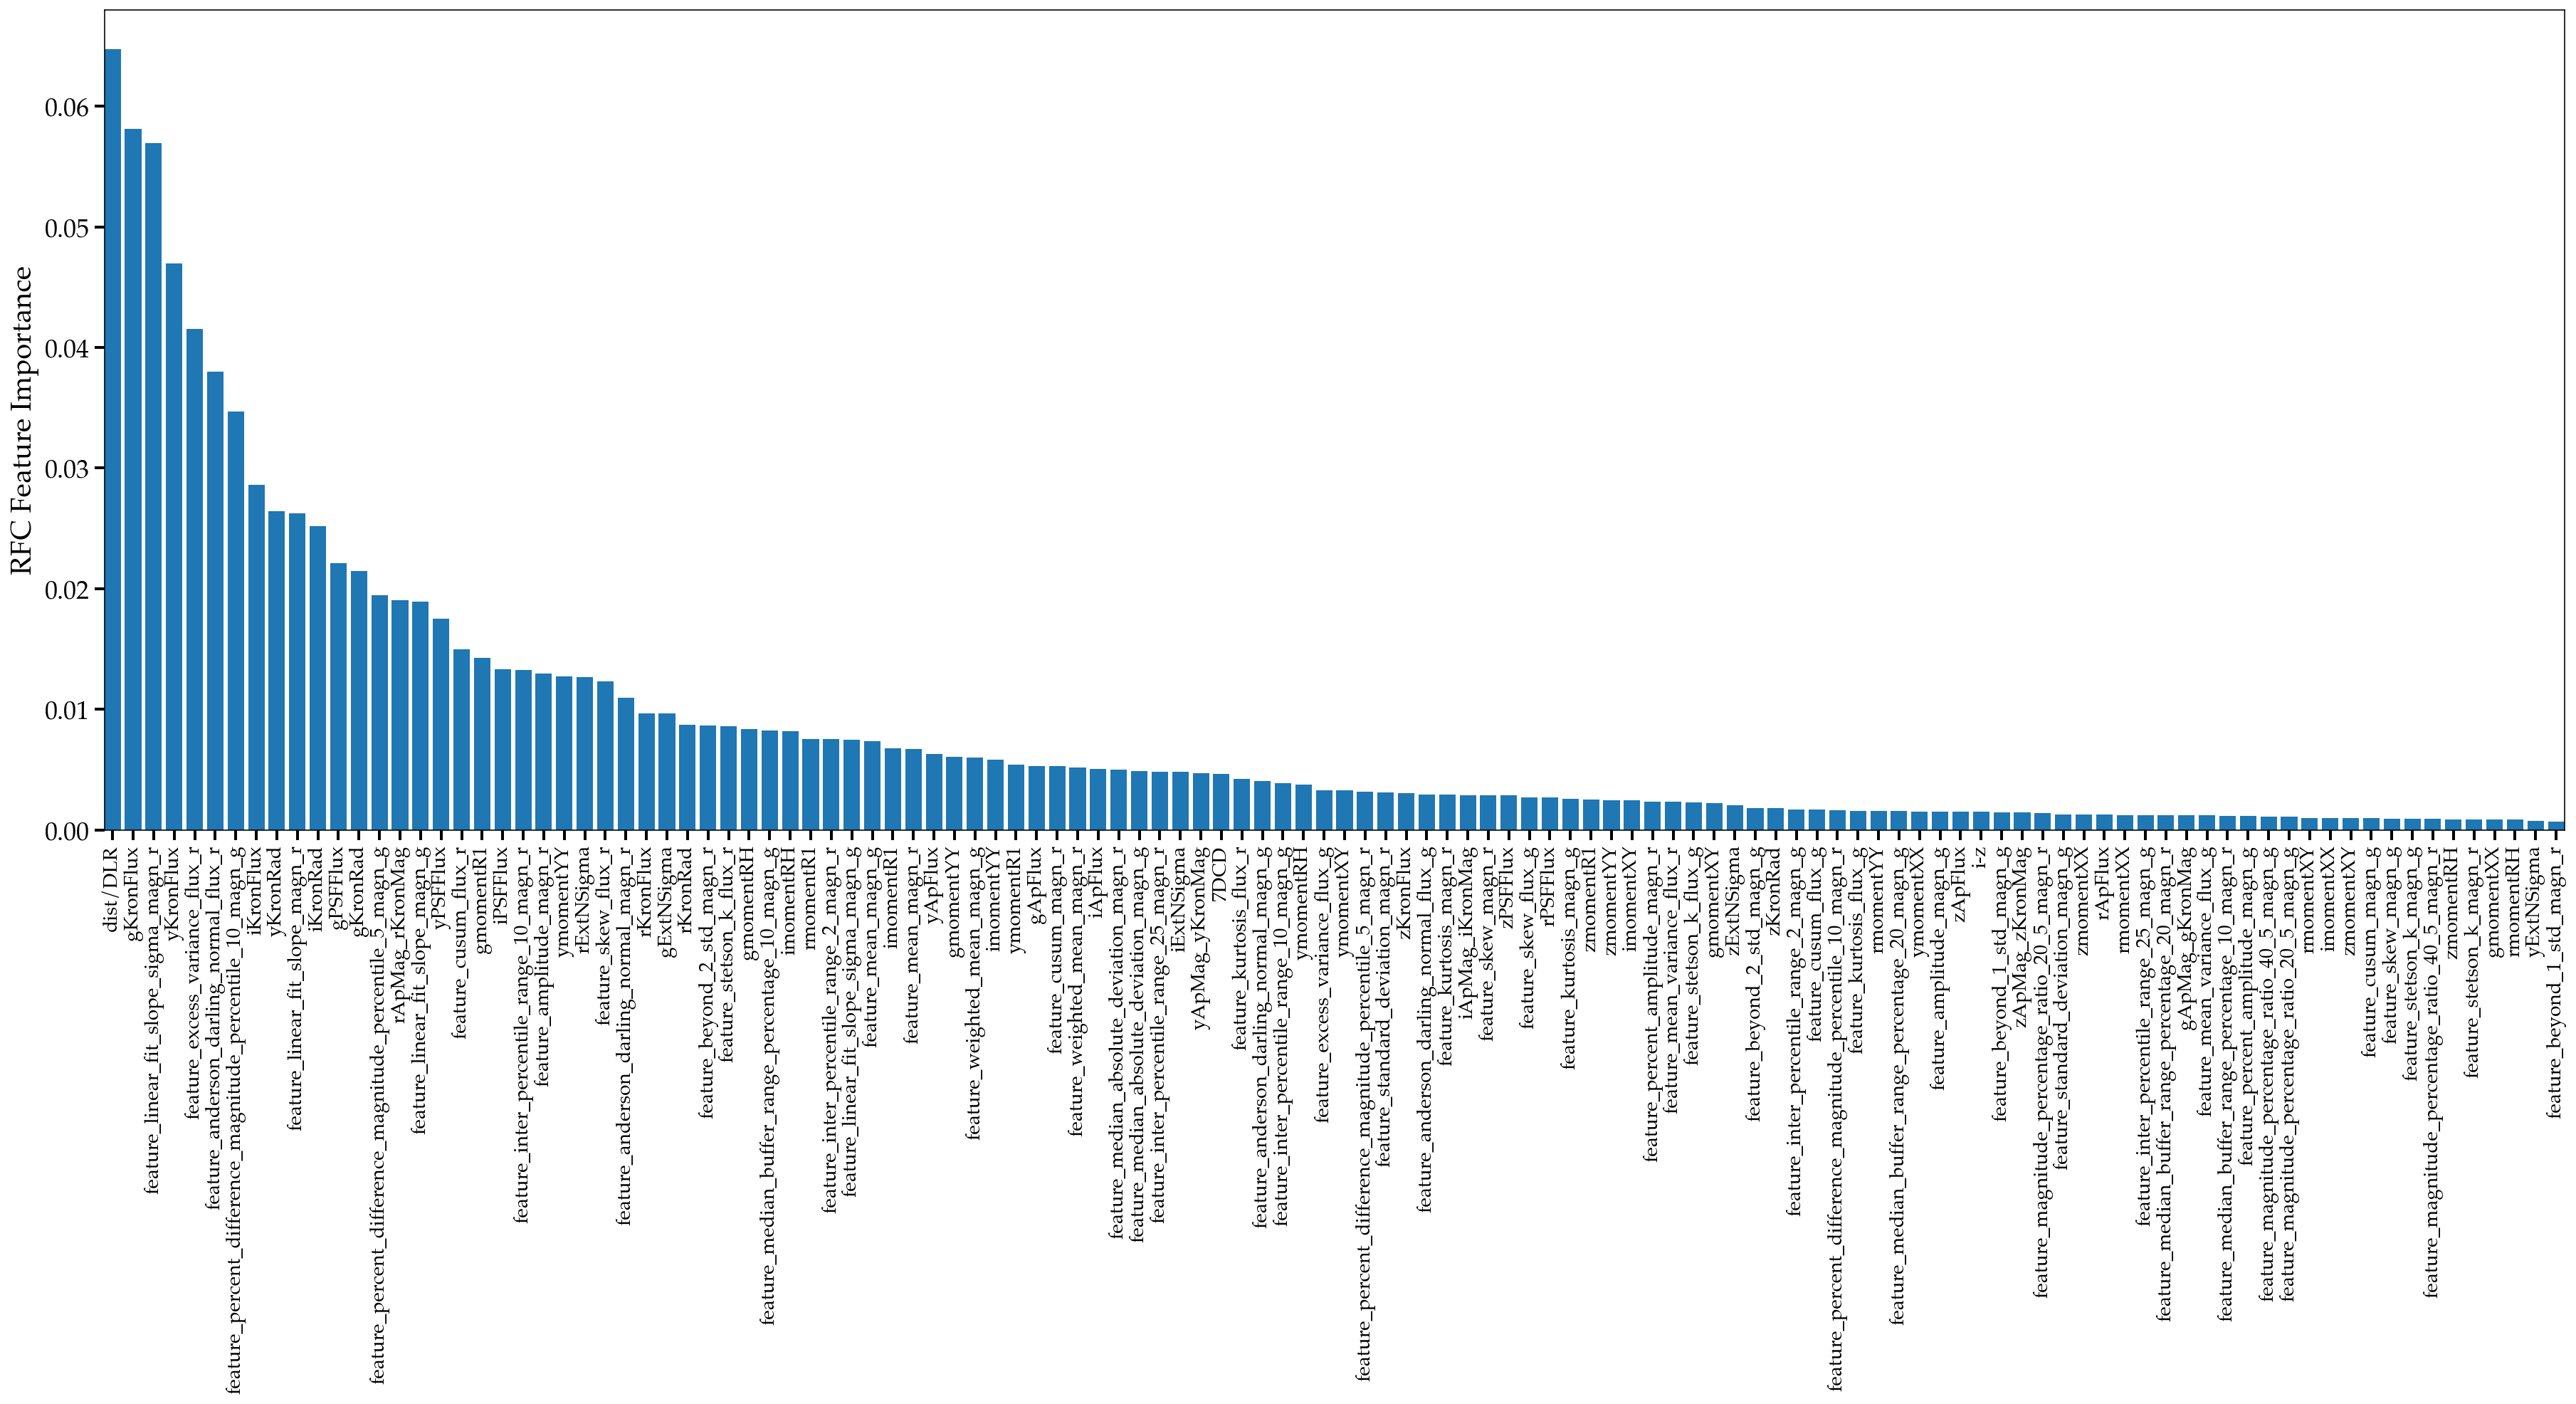

In [98]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

X_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]

fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(range(X_train.shape[1]), importances[indices])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90, fontsize=14)
plt.subplots_adjust(left=0.0, right=1, top=1.0, bottom=0)
ax.set_xlim(left=-0.40, right=119.4)
plt.ylabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_horizontal.jpg', dpi=300, bbox_inches='tight')
plt.show()

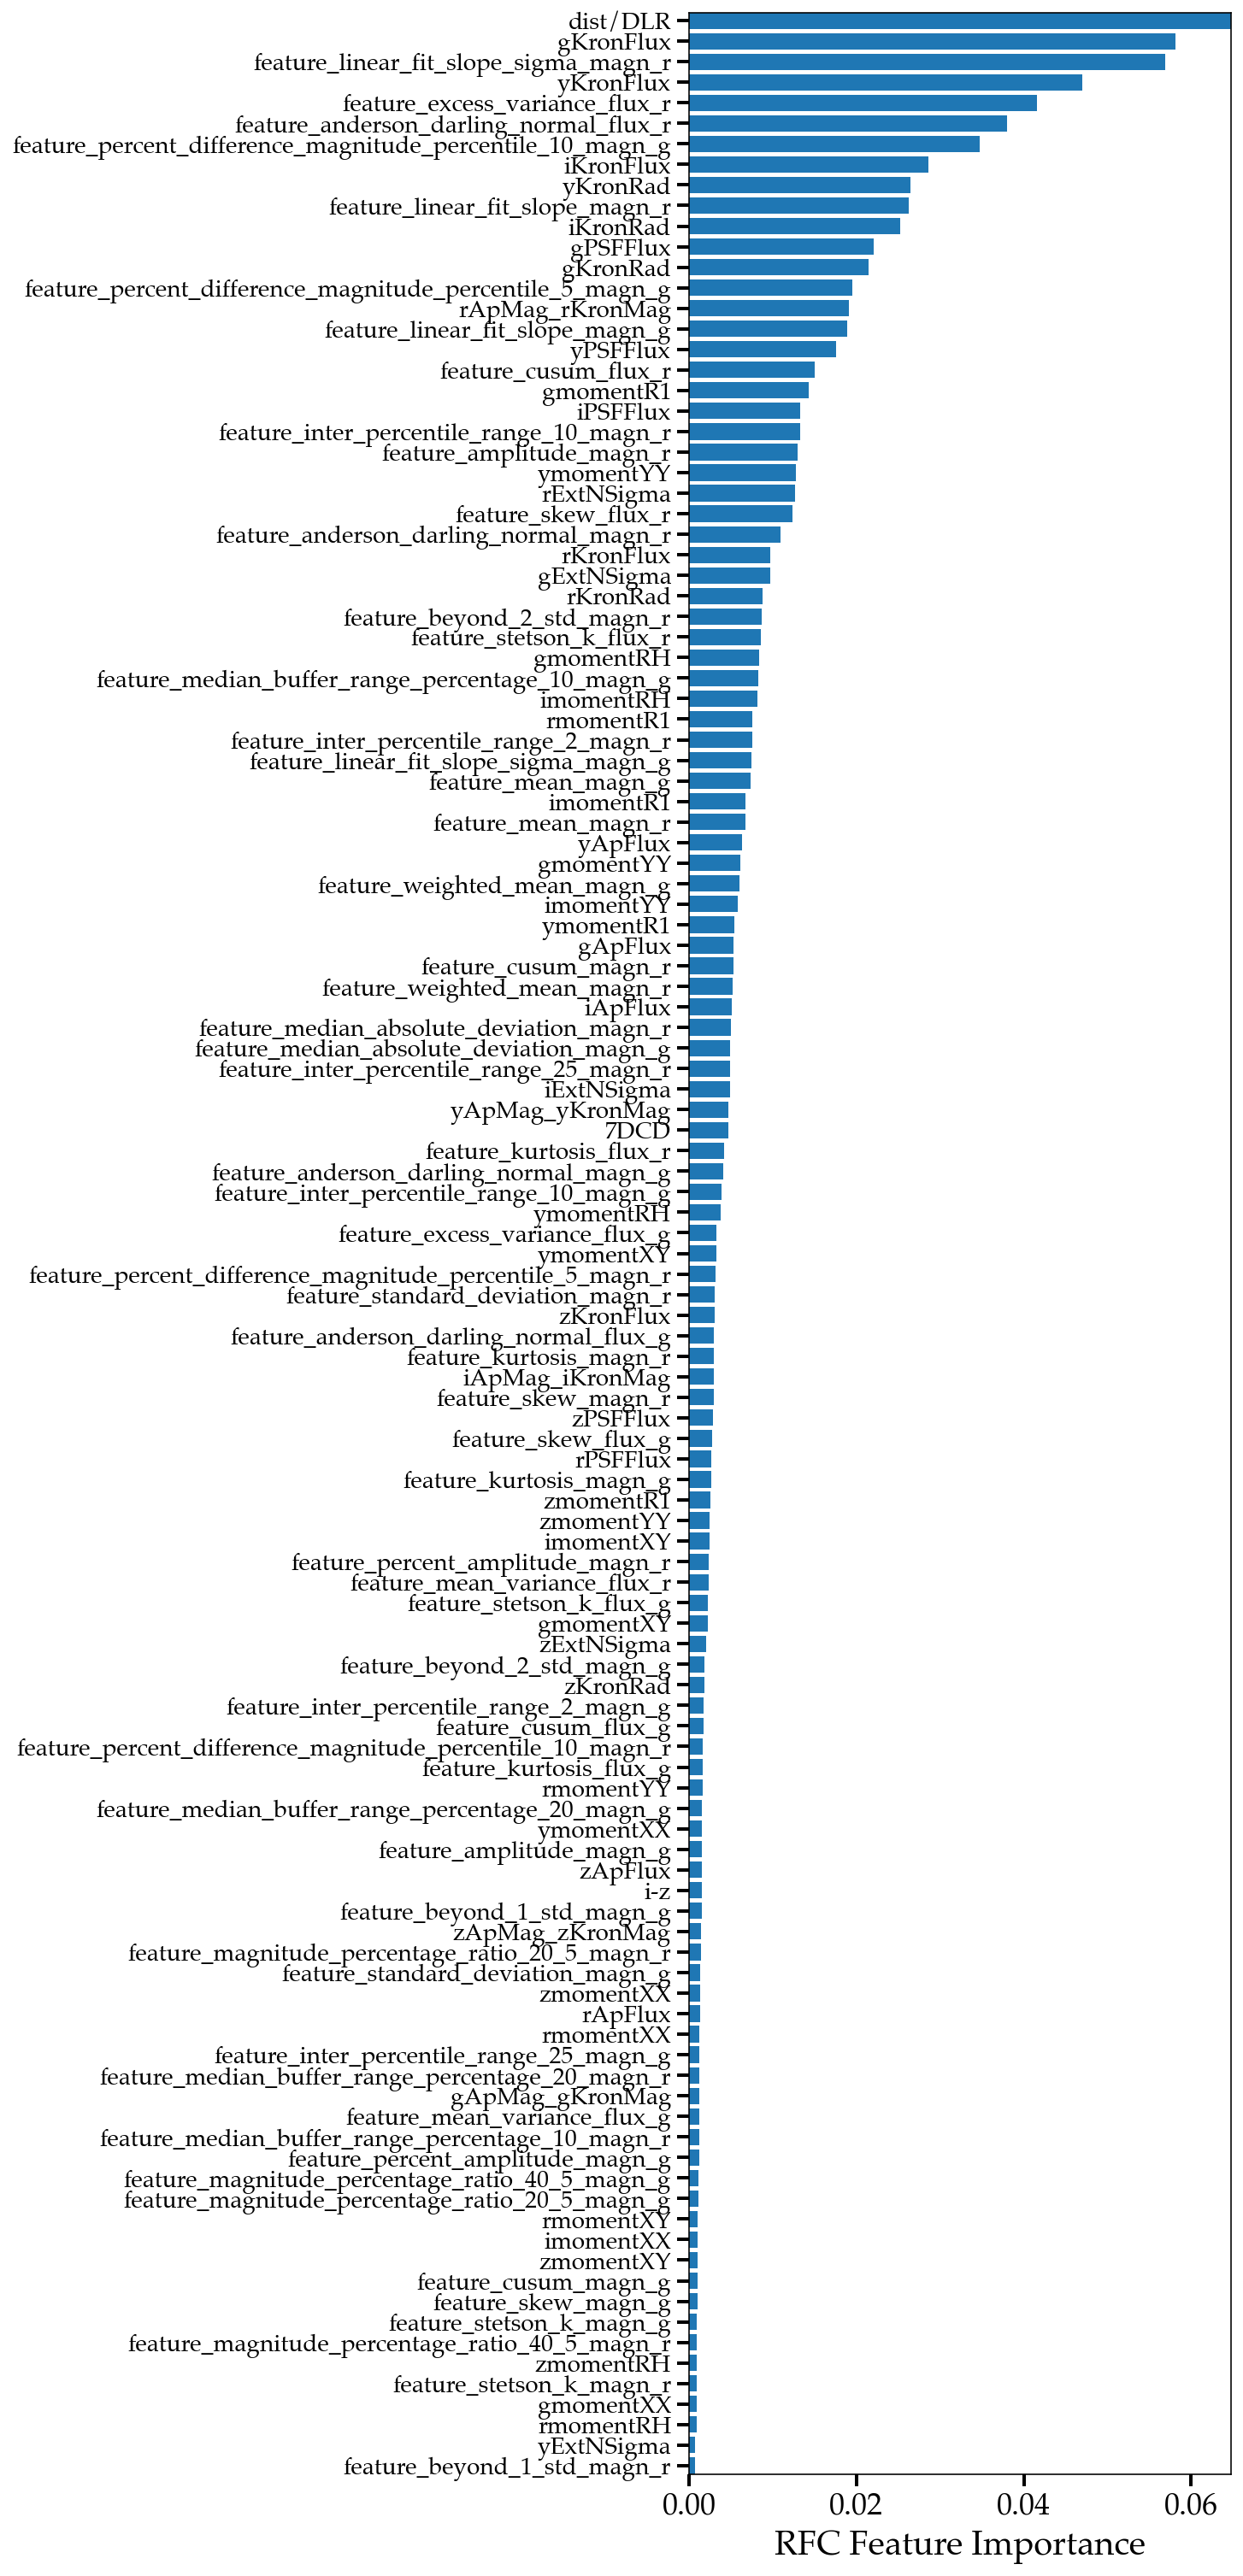

In [99]:
fig, ax = plt.subplots(figsize=(8, 20))
ax.barh(range(X_train.shape[1]), importances[indices][::-1])
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(X_train.columns[indices][::-1], fontsize=14)
plt.subplots_adjust(left=0.4, right=0.95, top=1.0, bottom=0)
ax.set_ylim(top=119.4, bottom=-0.40)
ax.set_xlim(right=np.max(importances[indices][::-1]))
plt.xlabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_vertical.jpg', dpi=300, bbox_inches='tight')
plt.show()

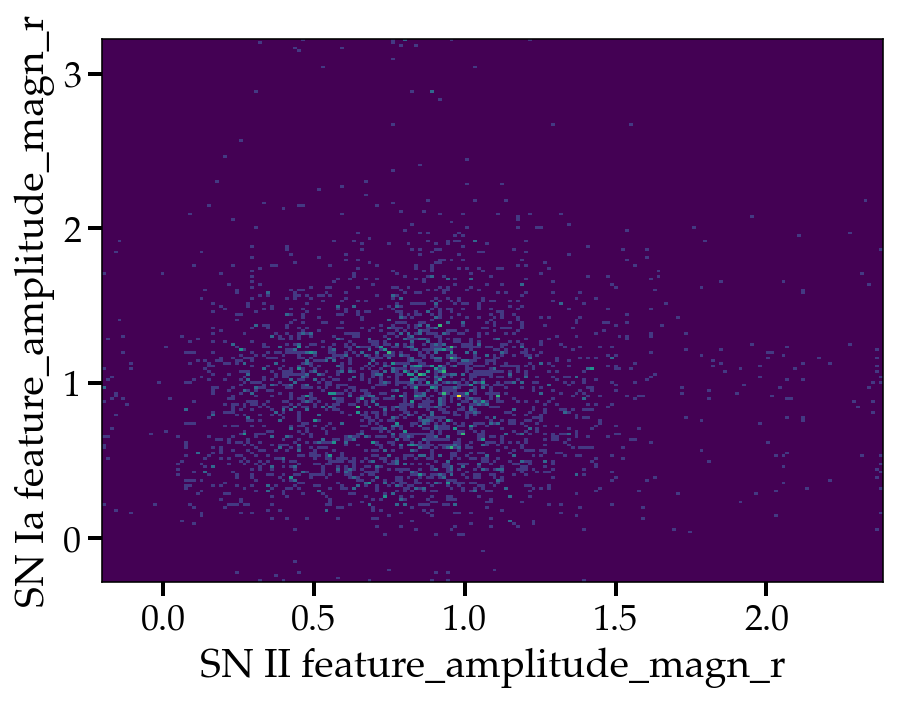

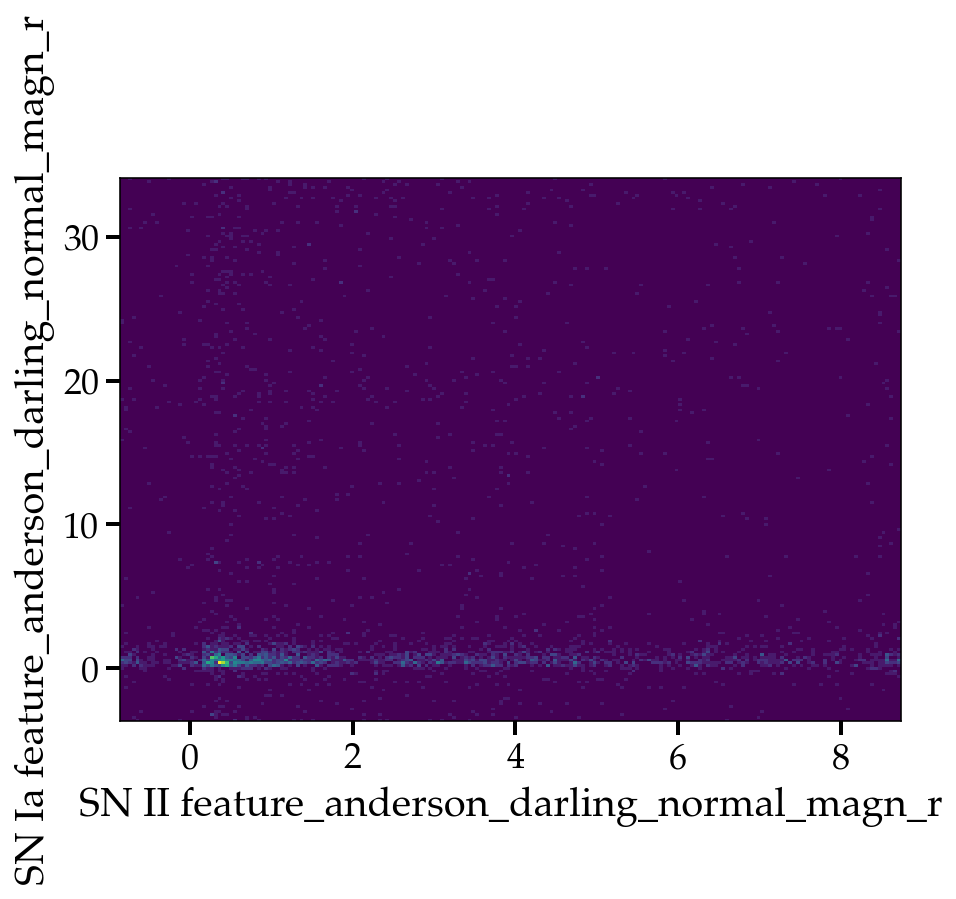

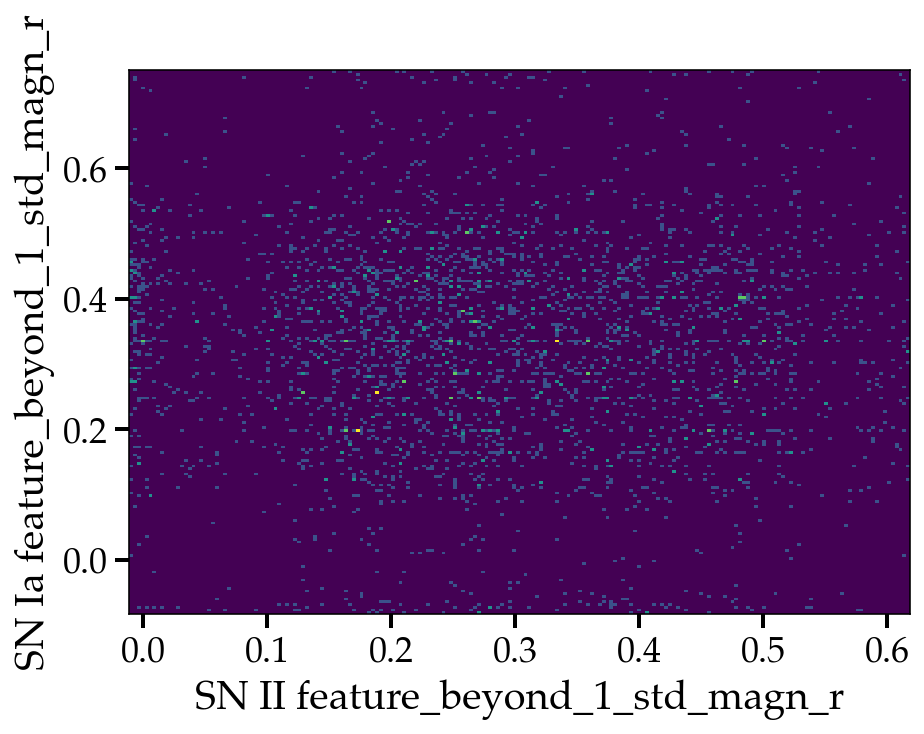

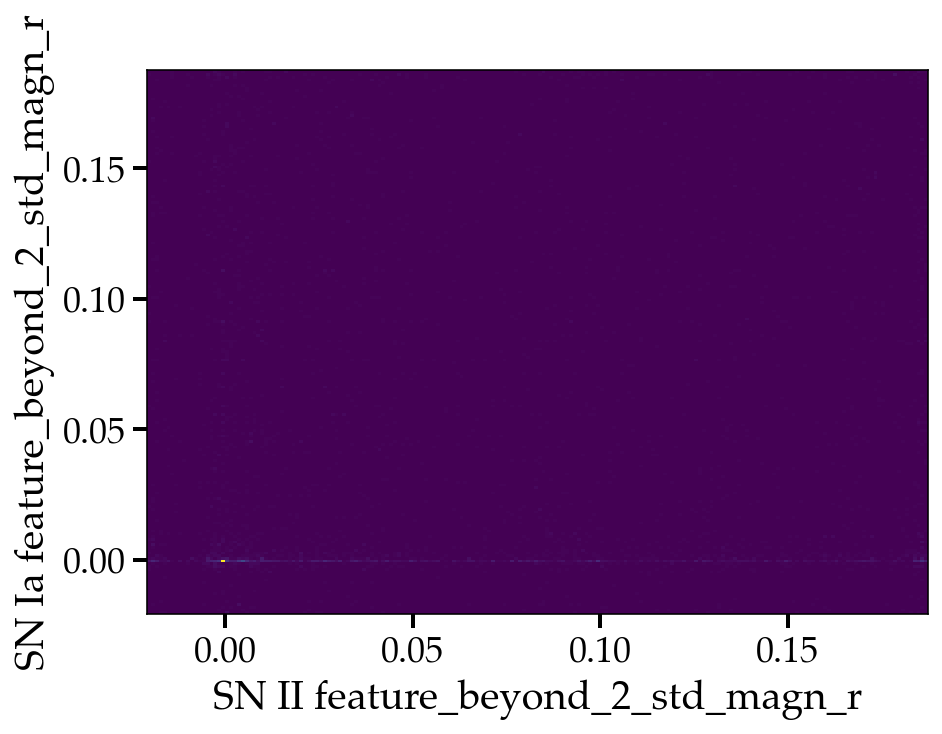

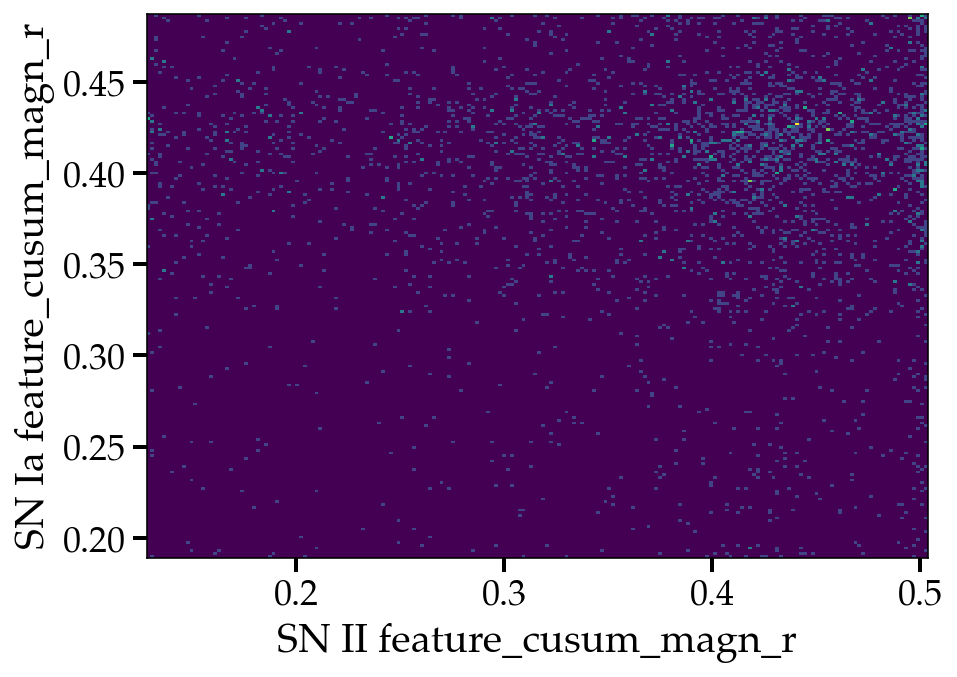

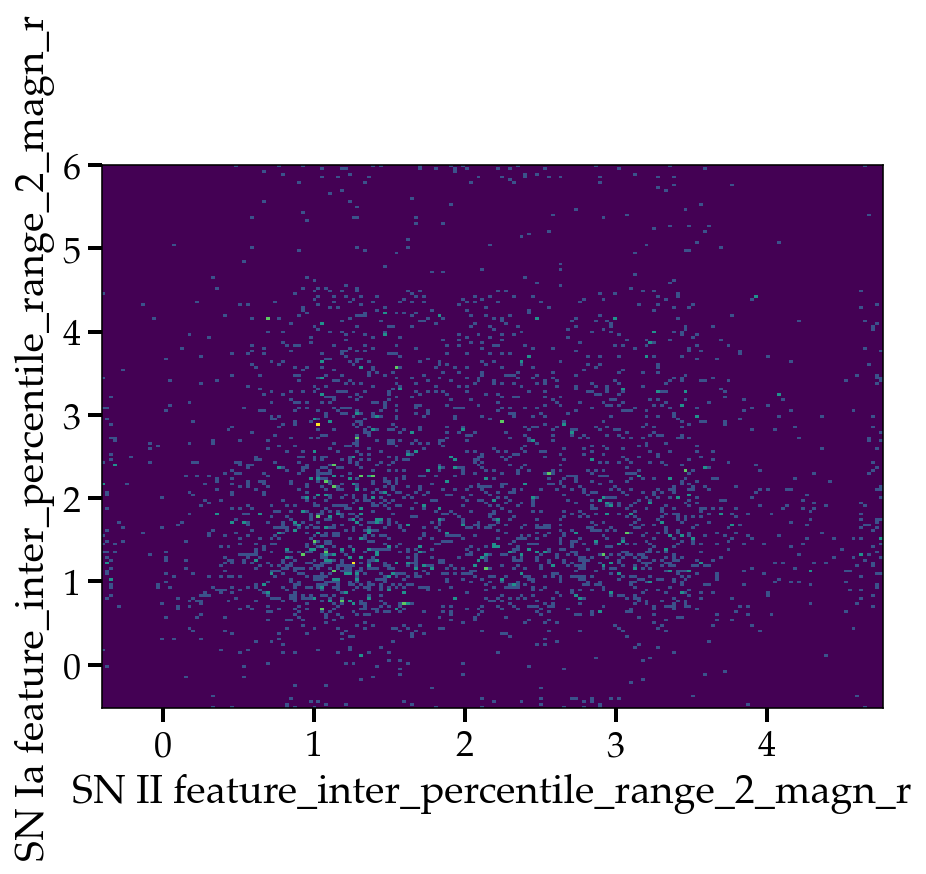

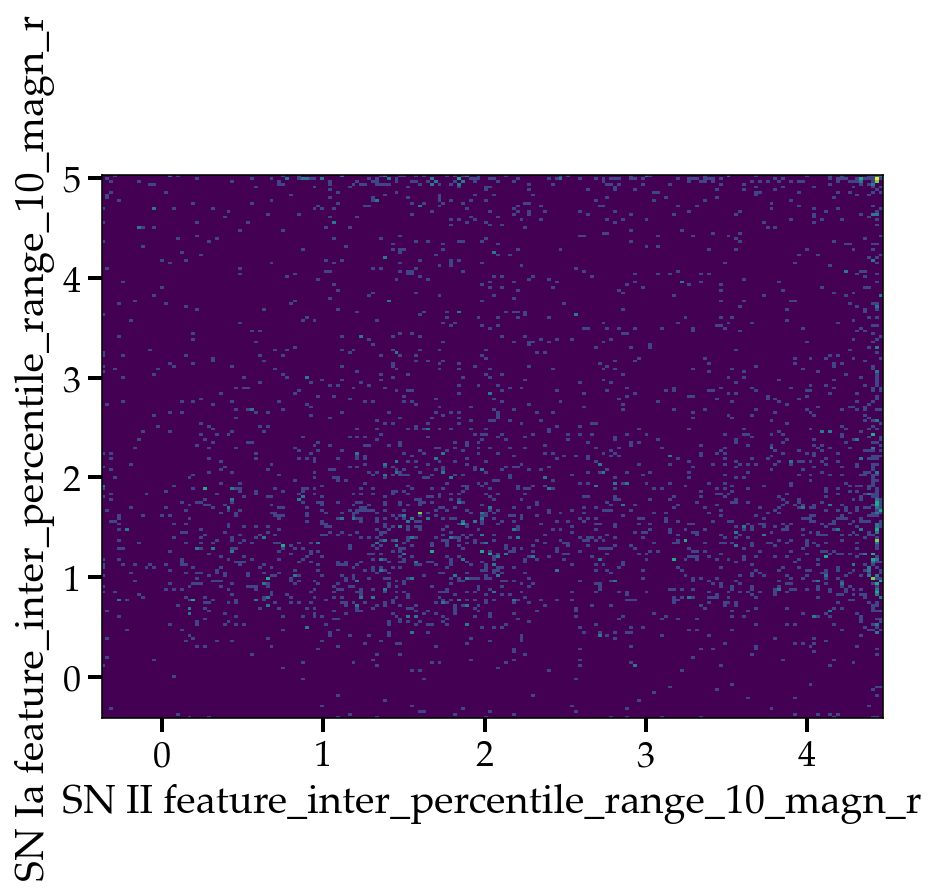

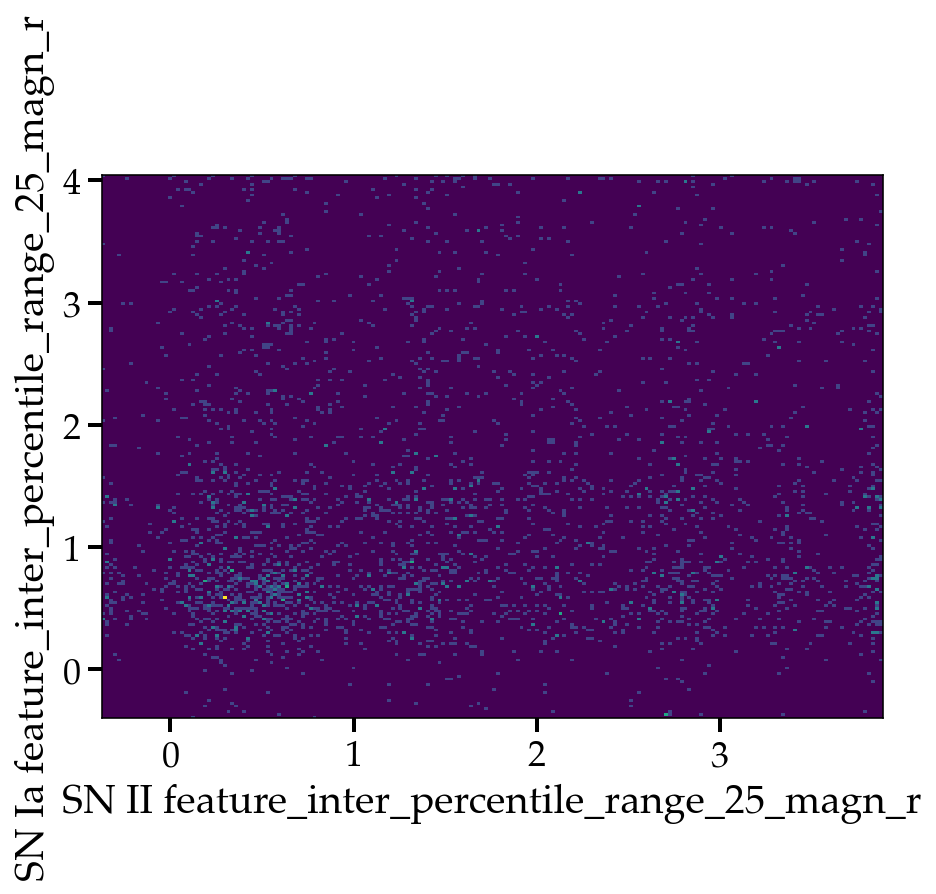

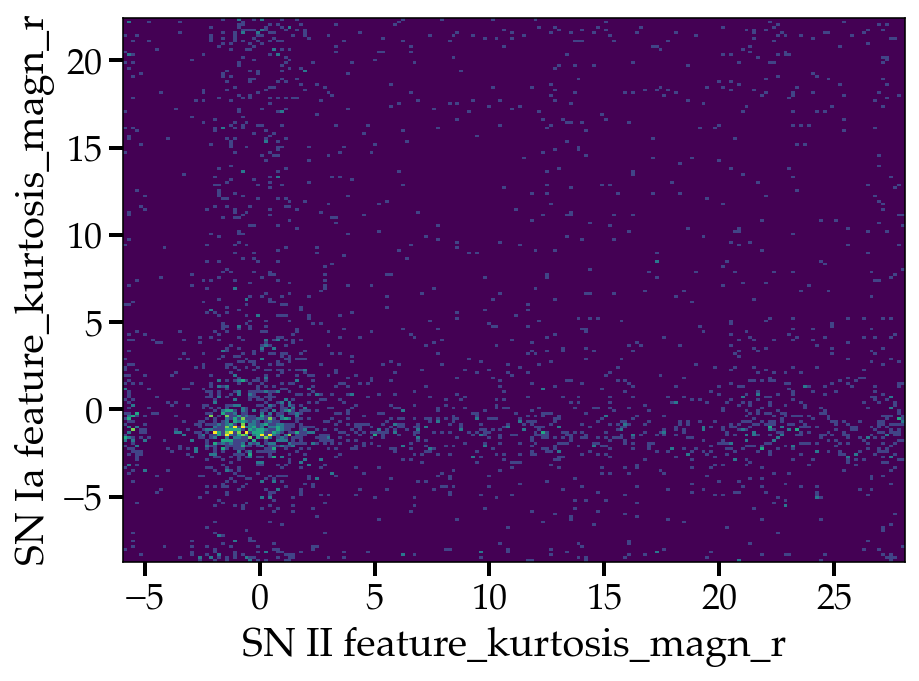

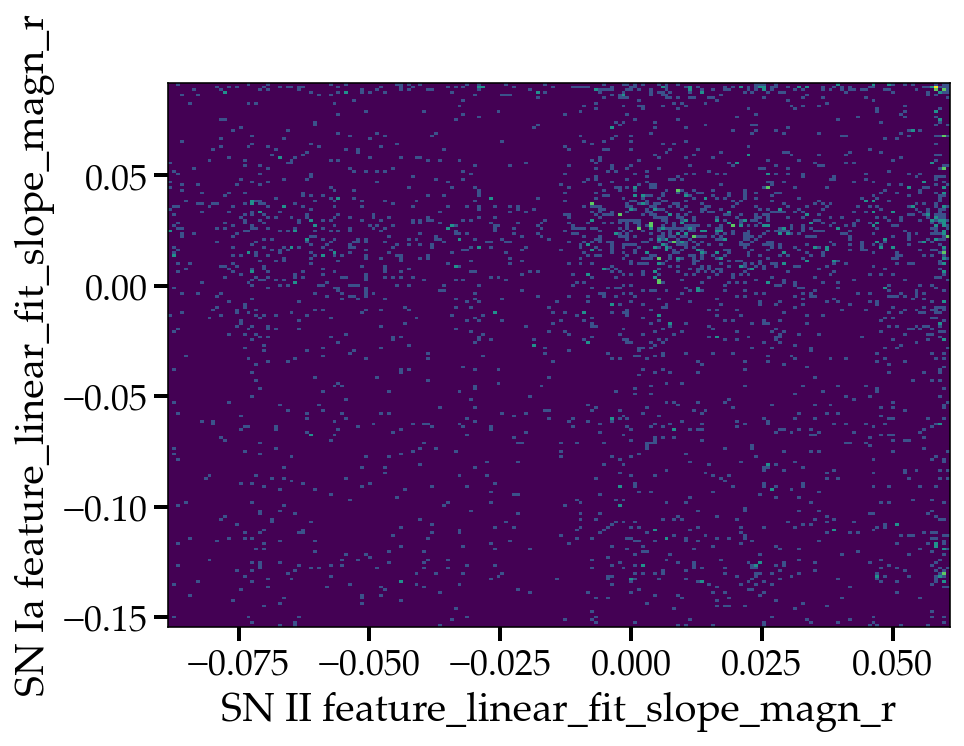

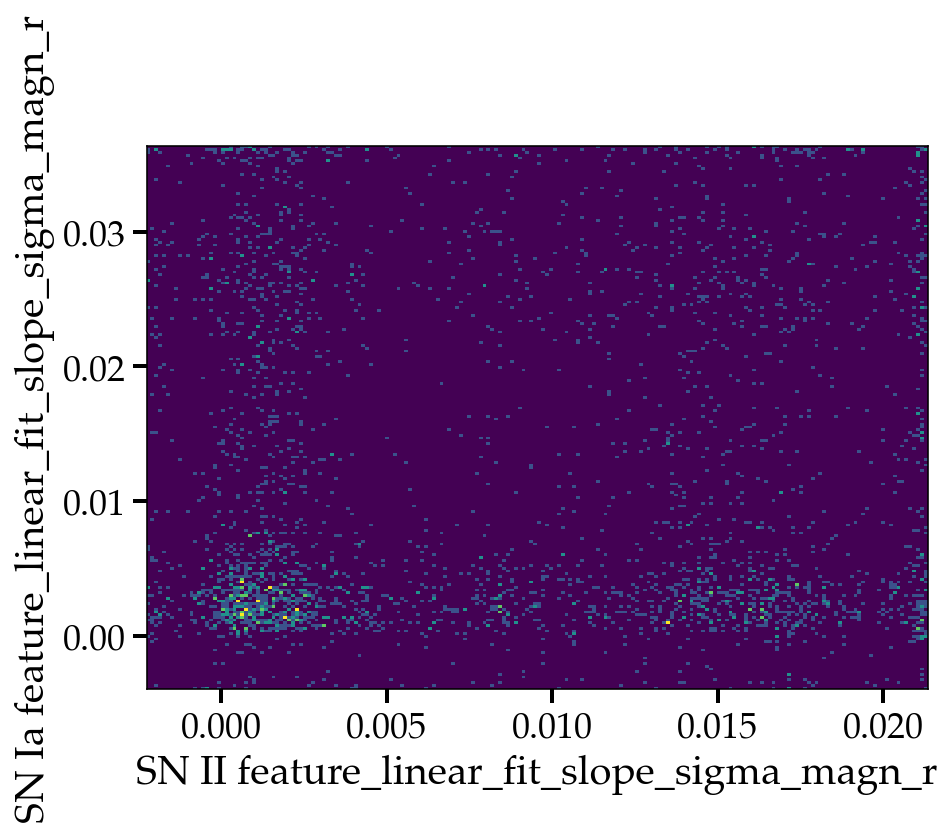

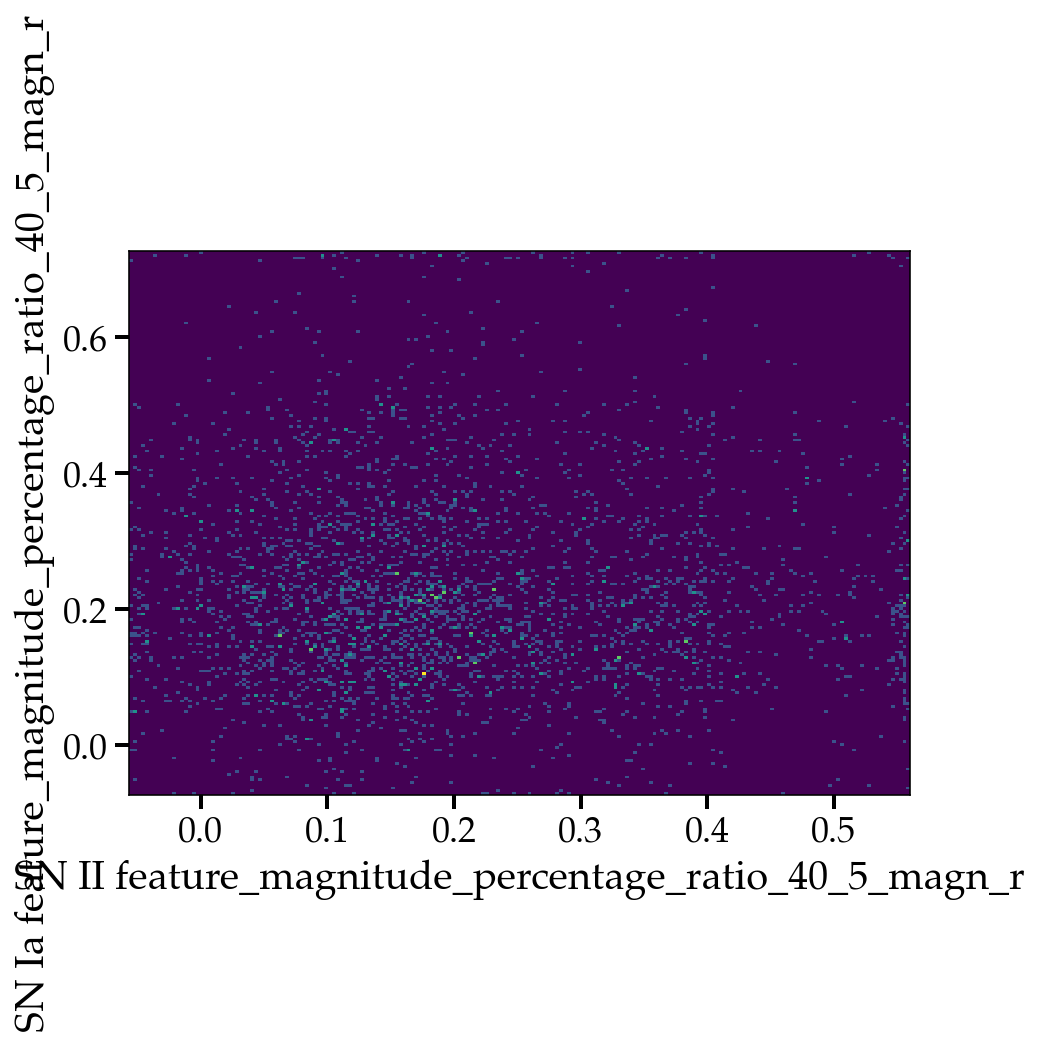

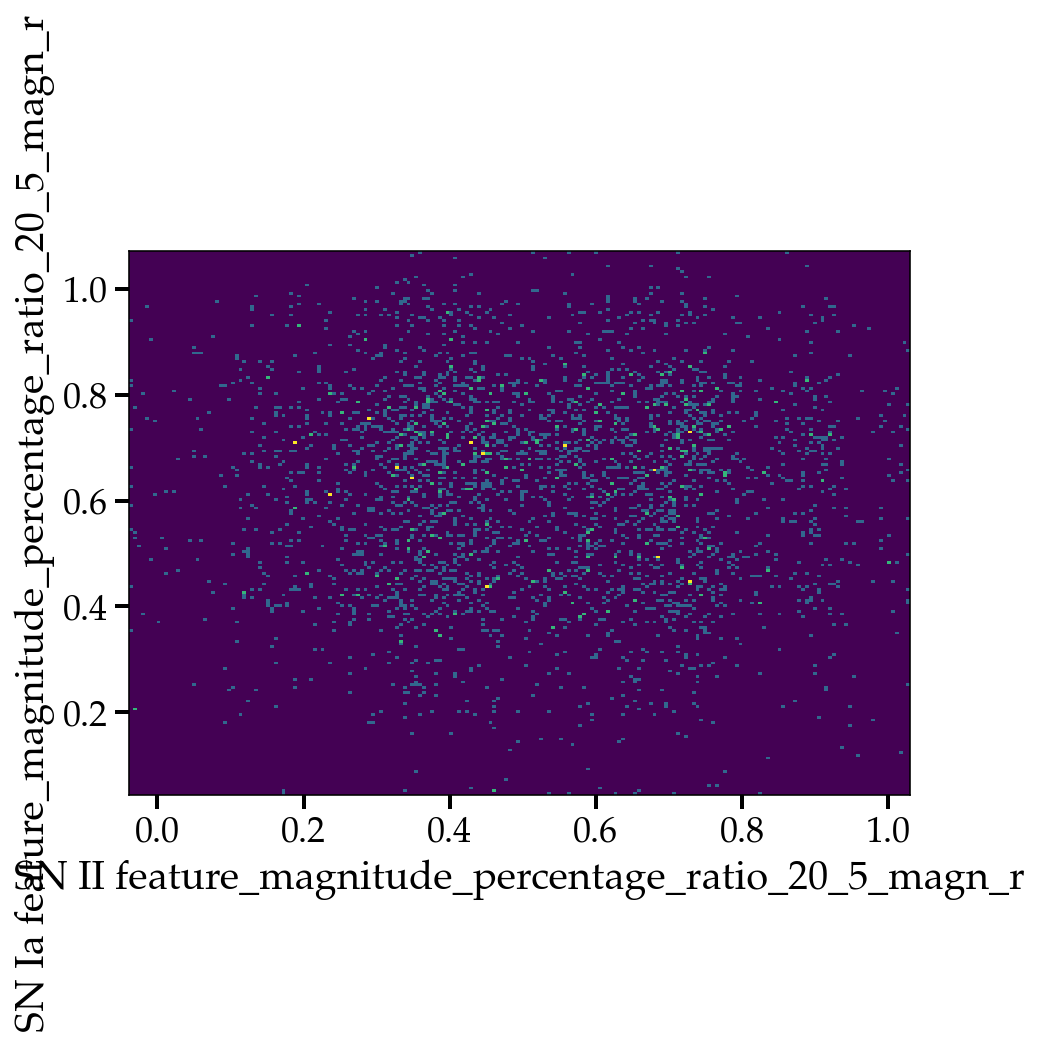

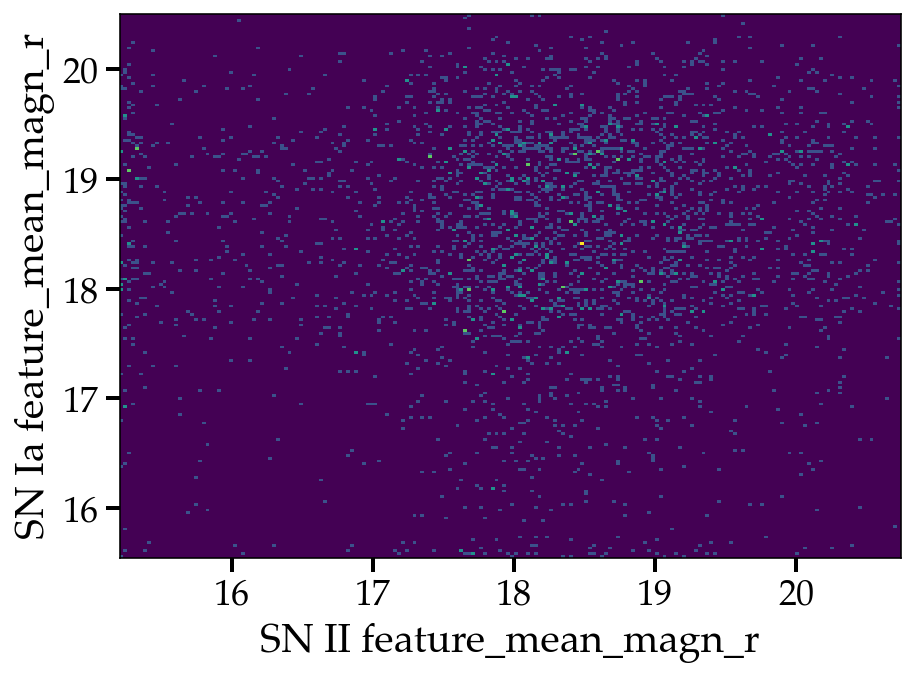

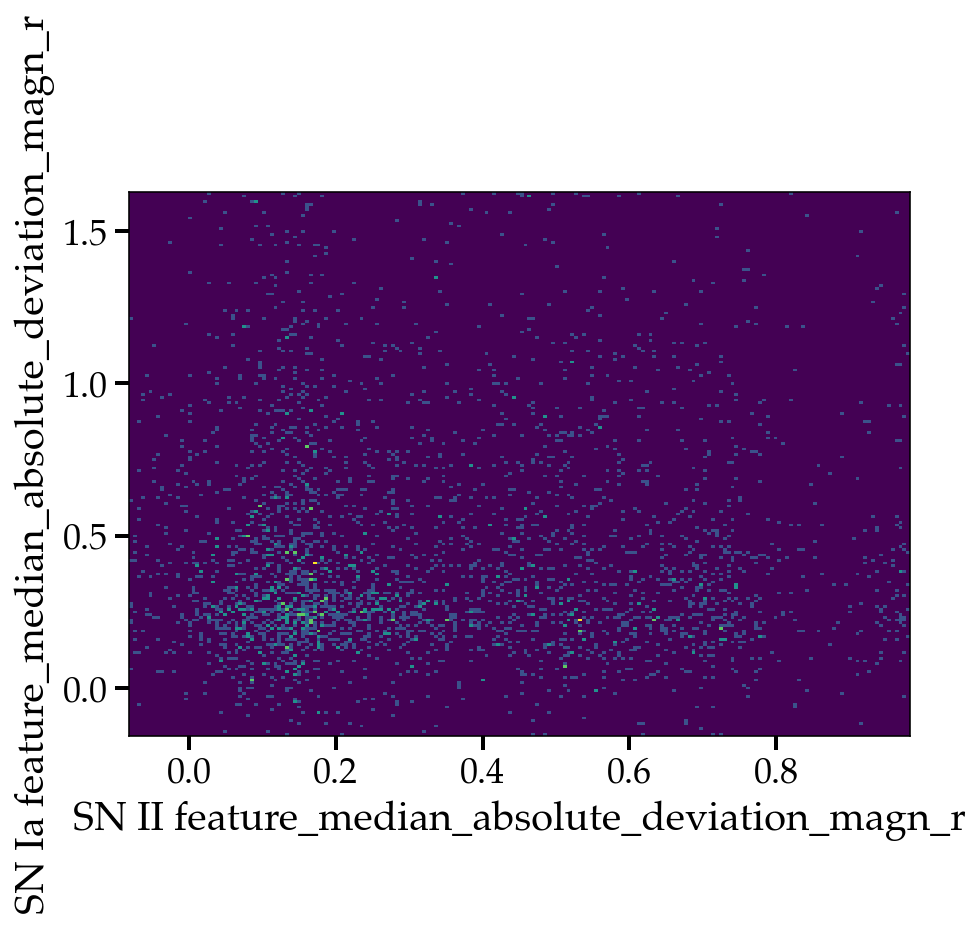

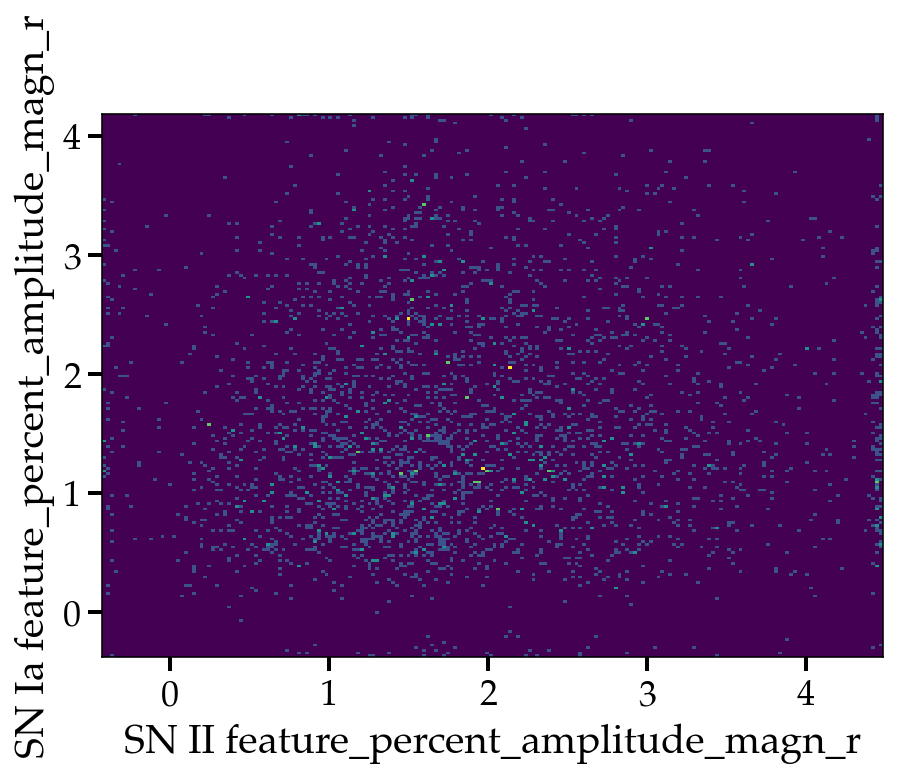

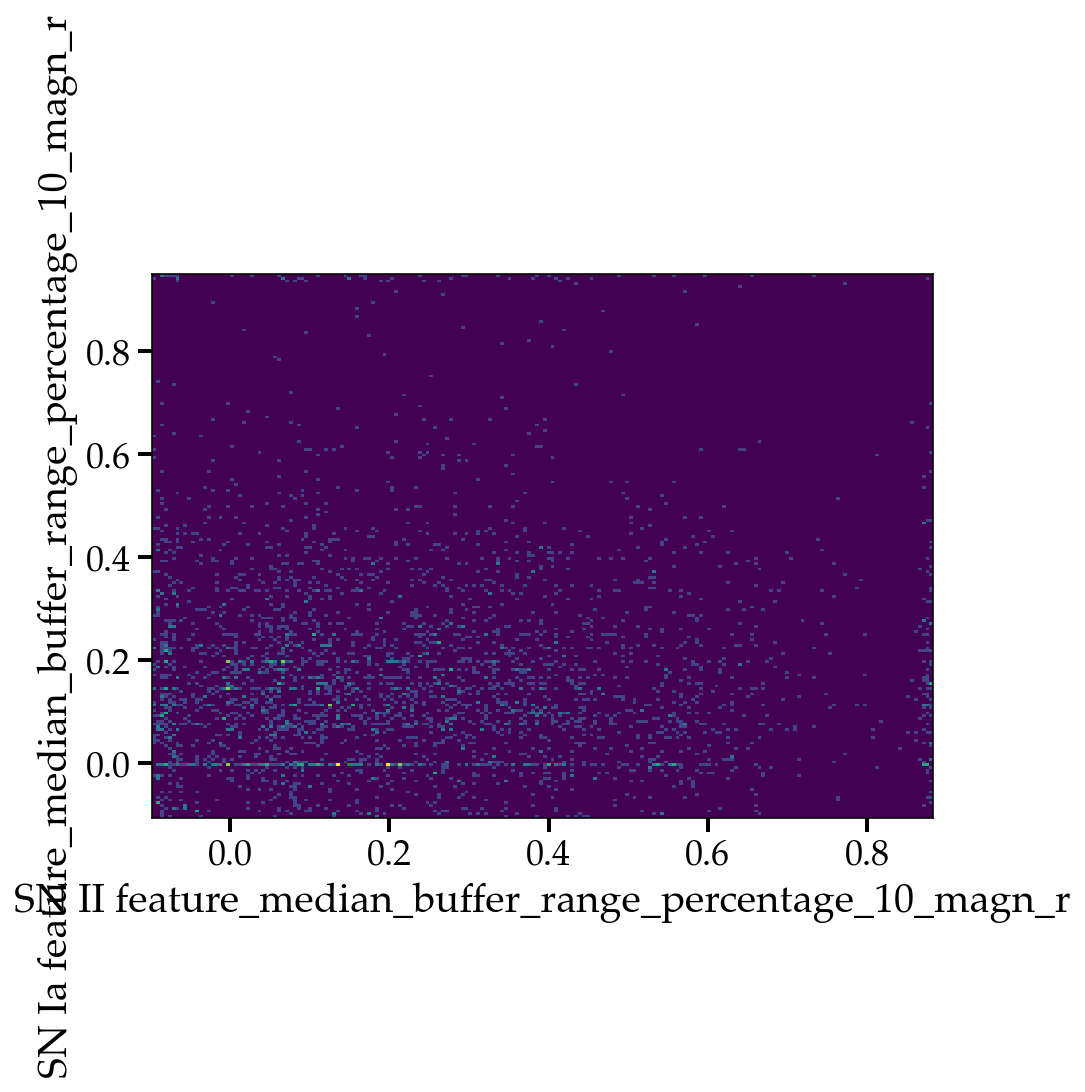

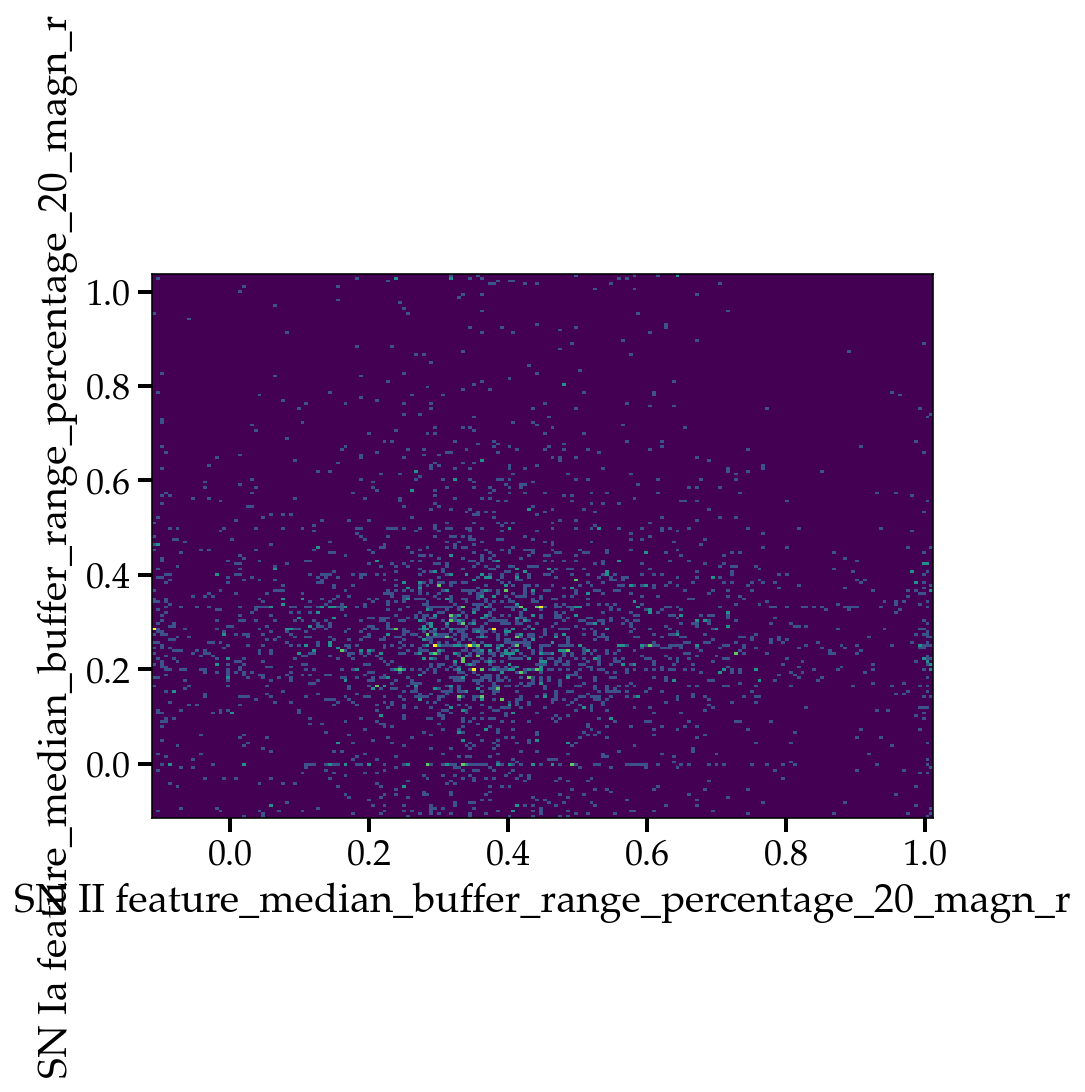

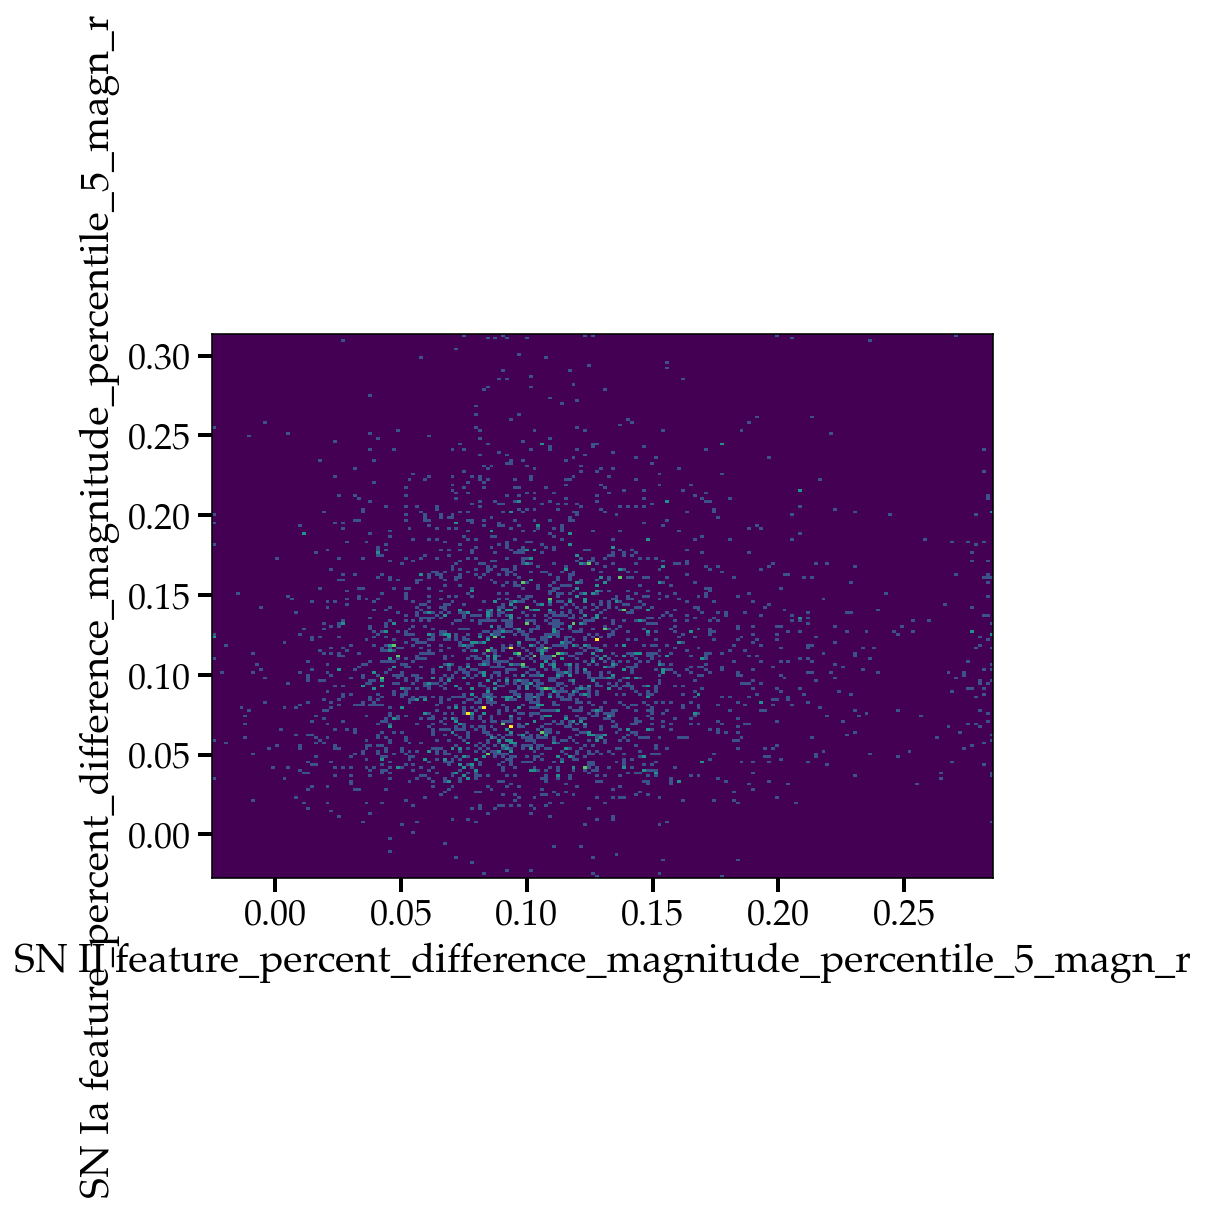

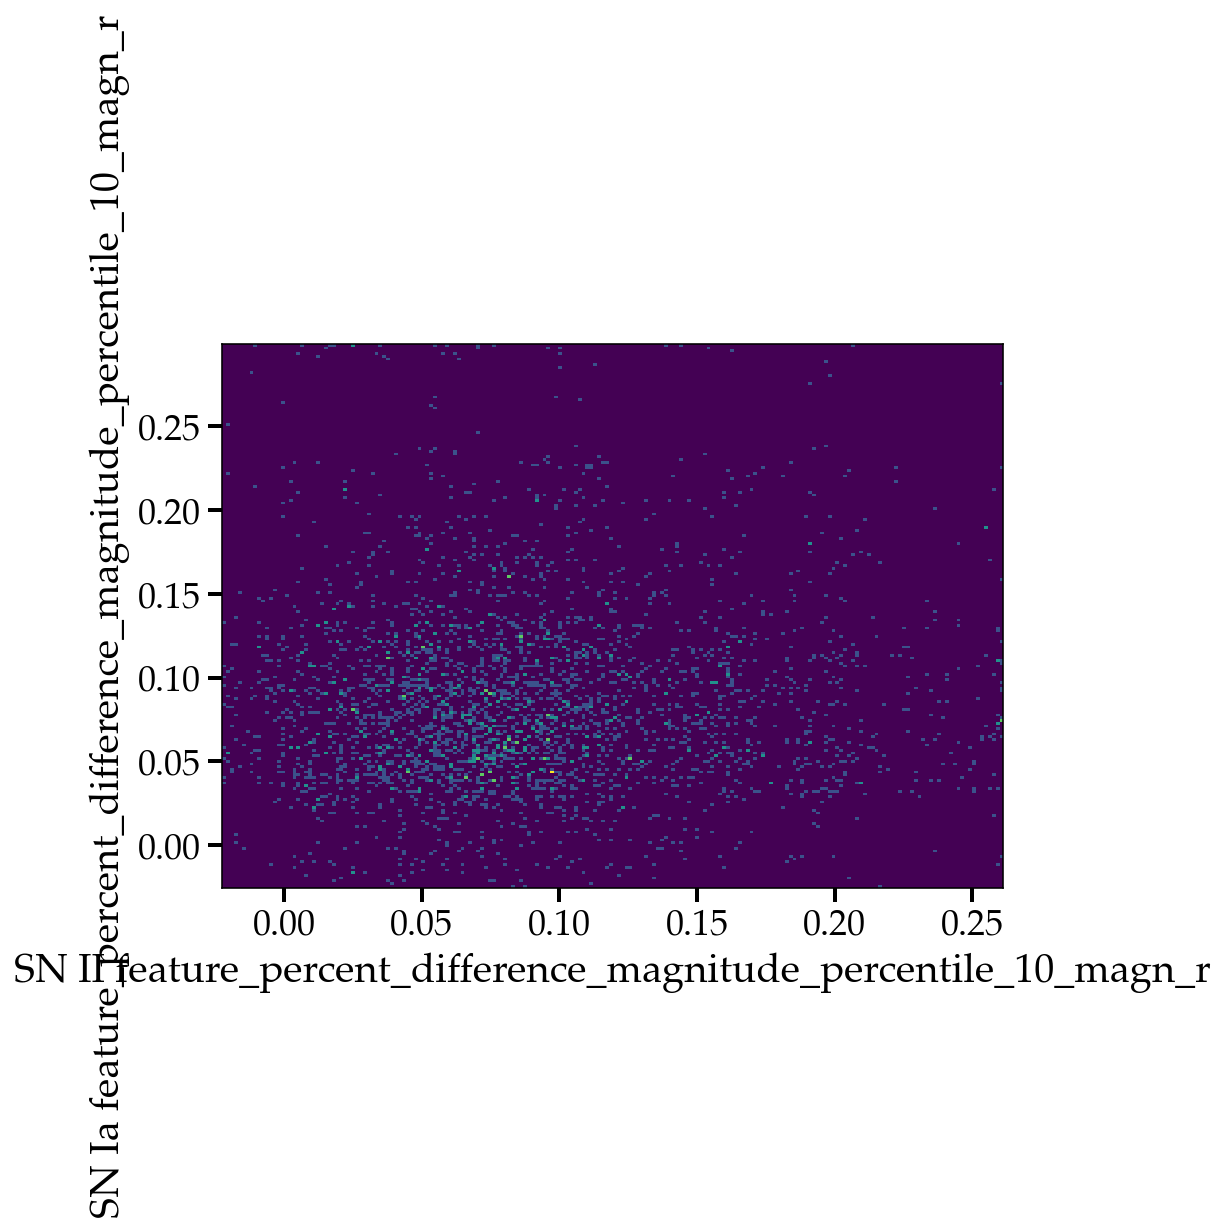

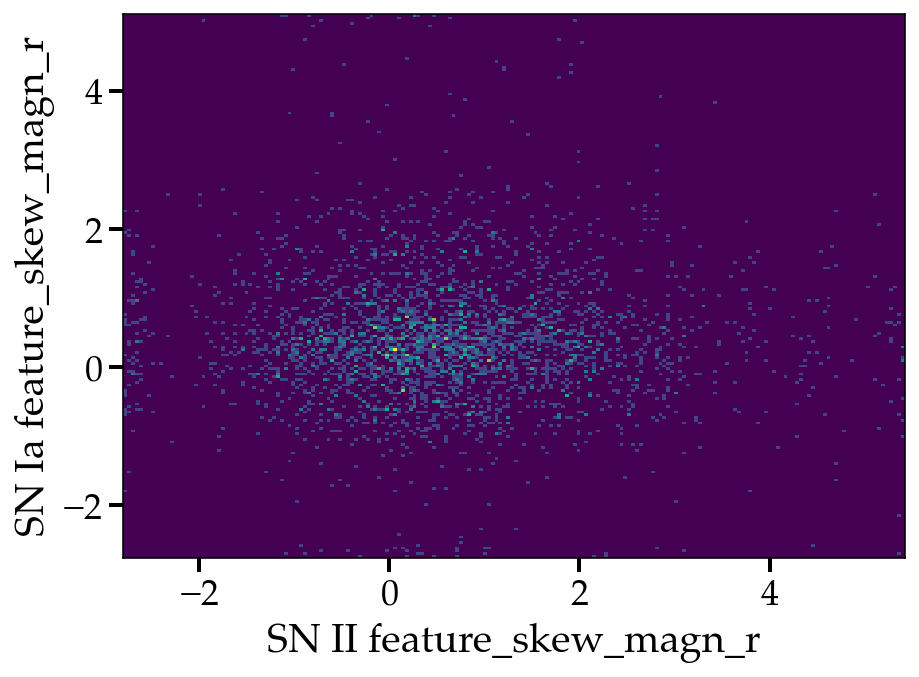

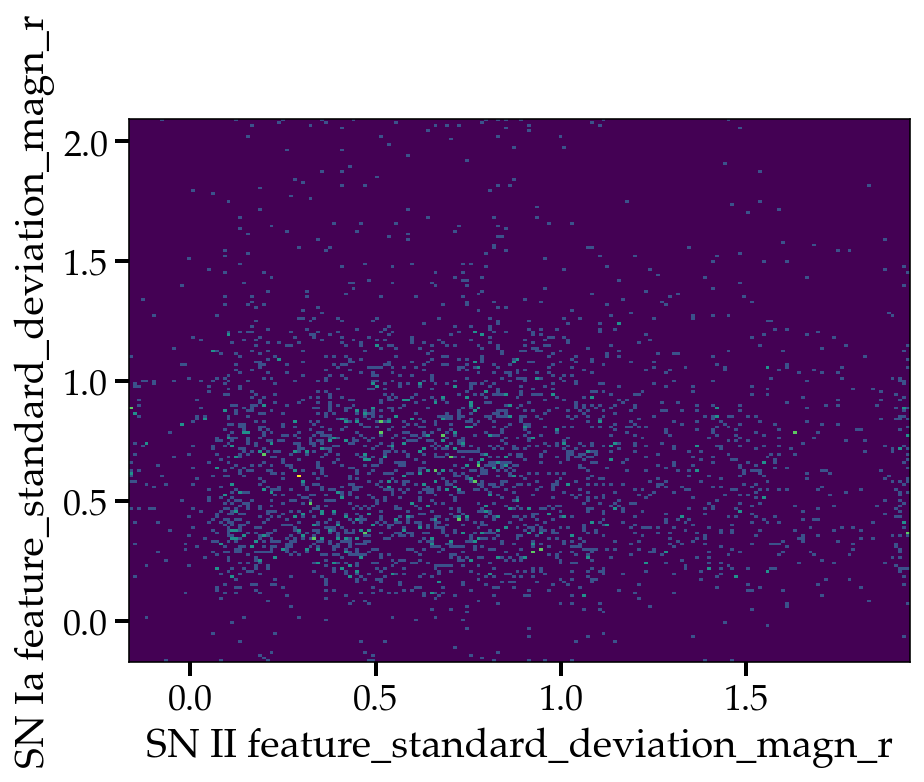

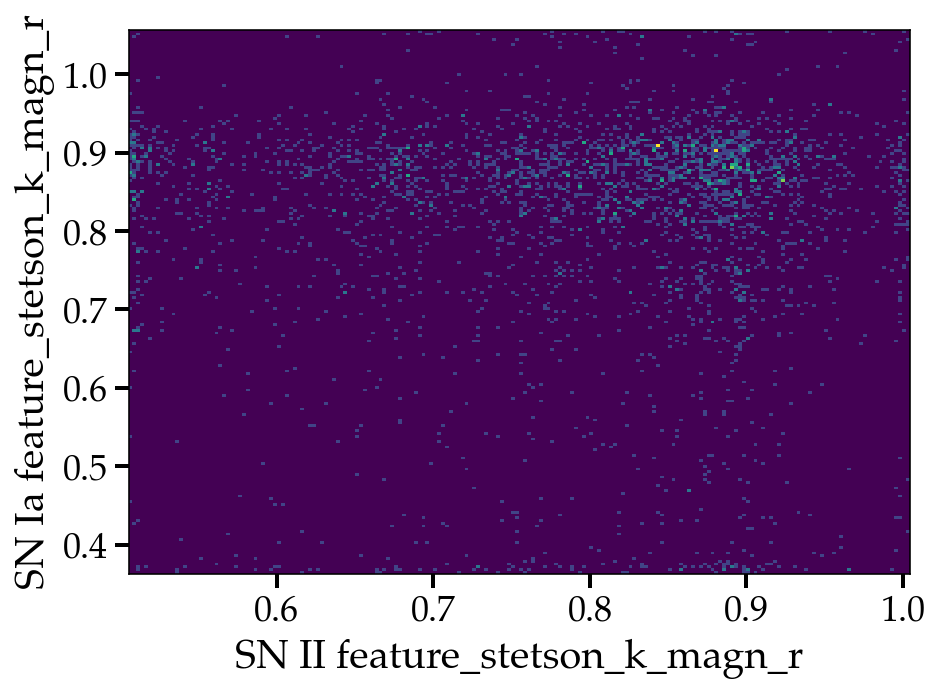

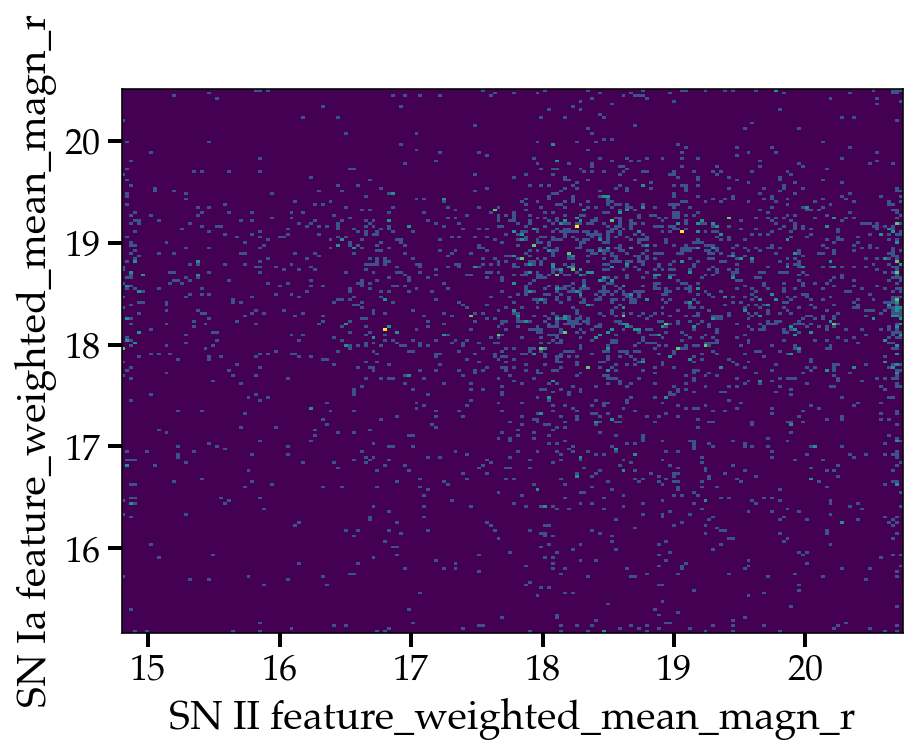

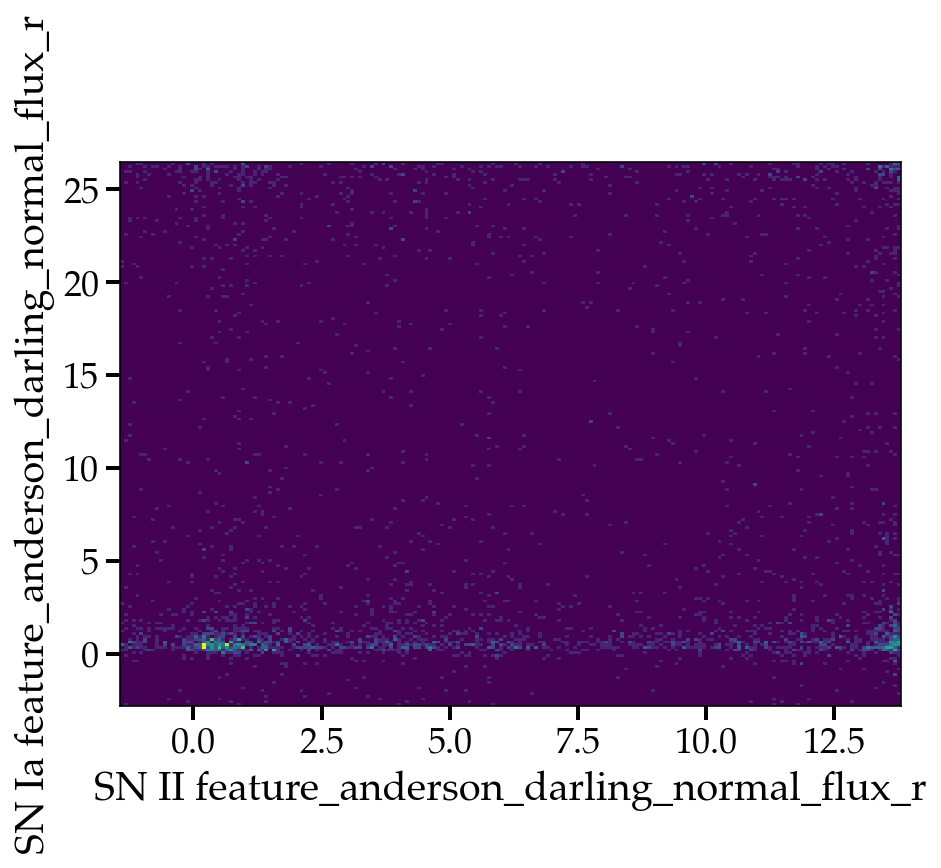

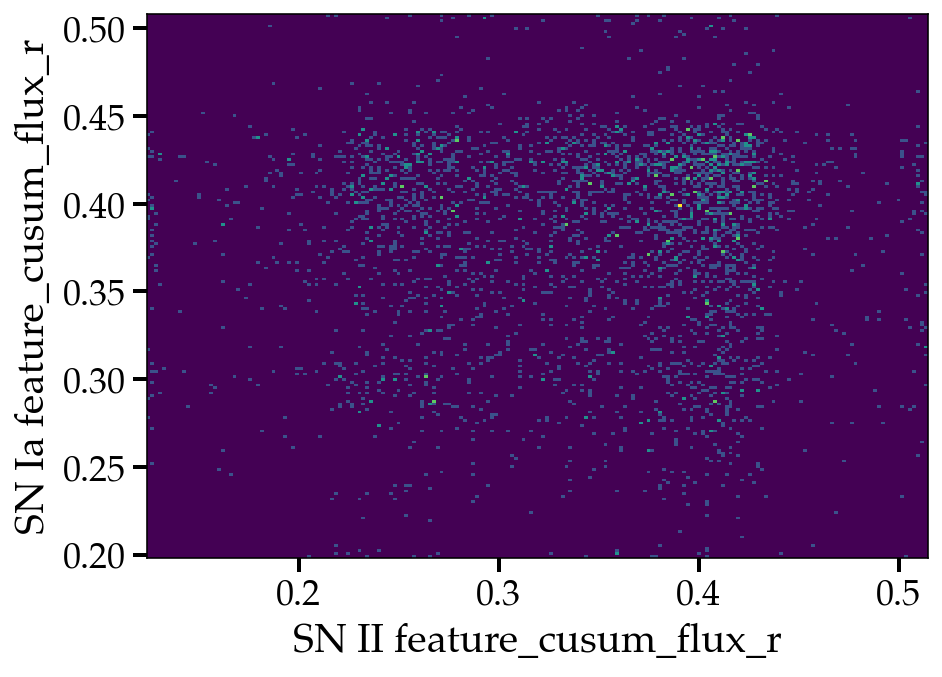

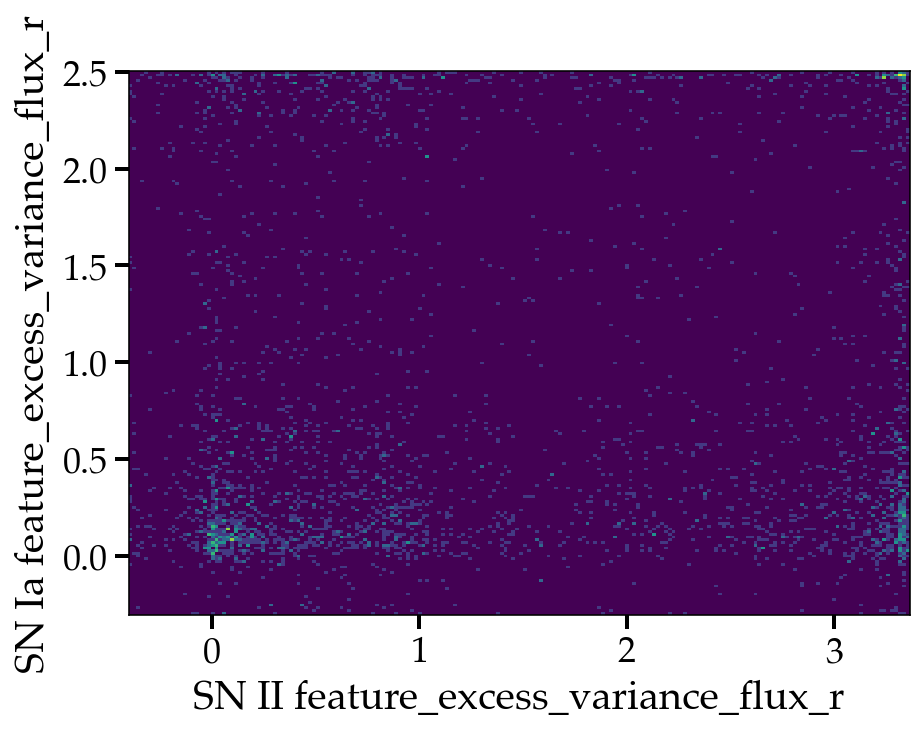

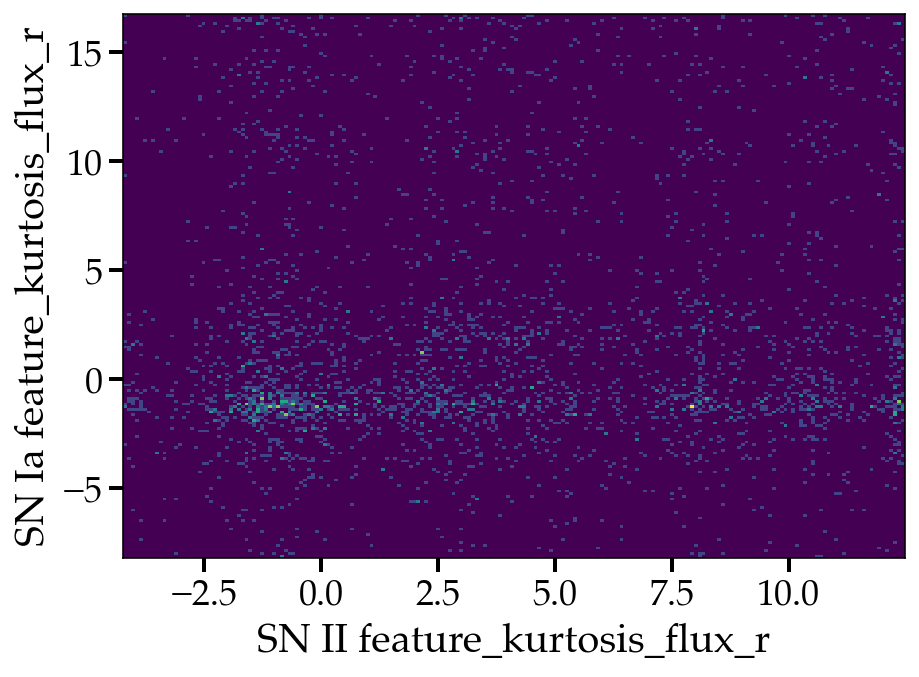

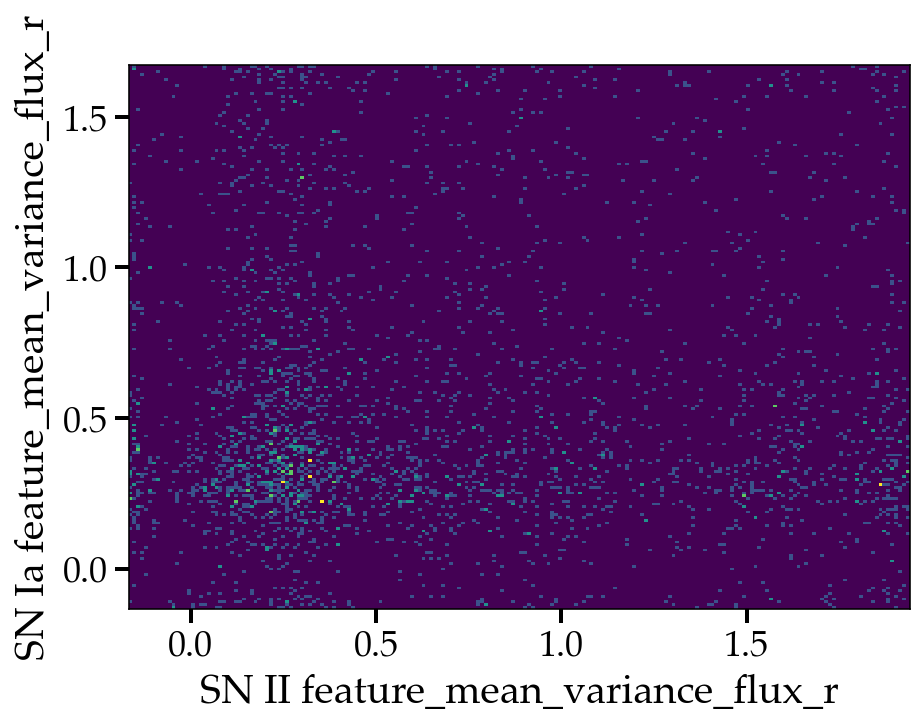

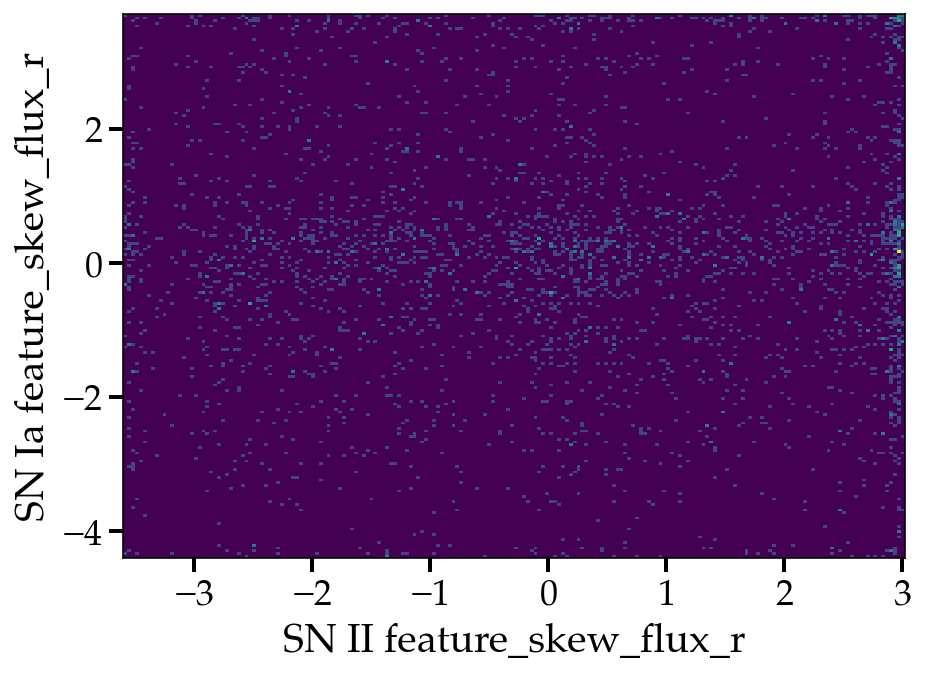

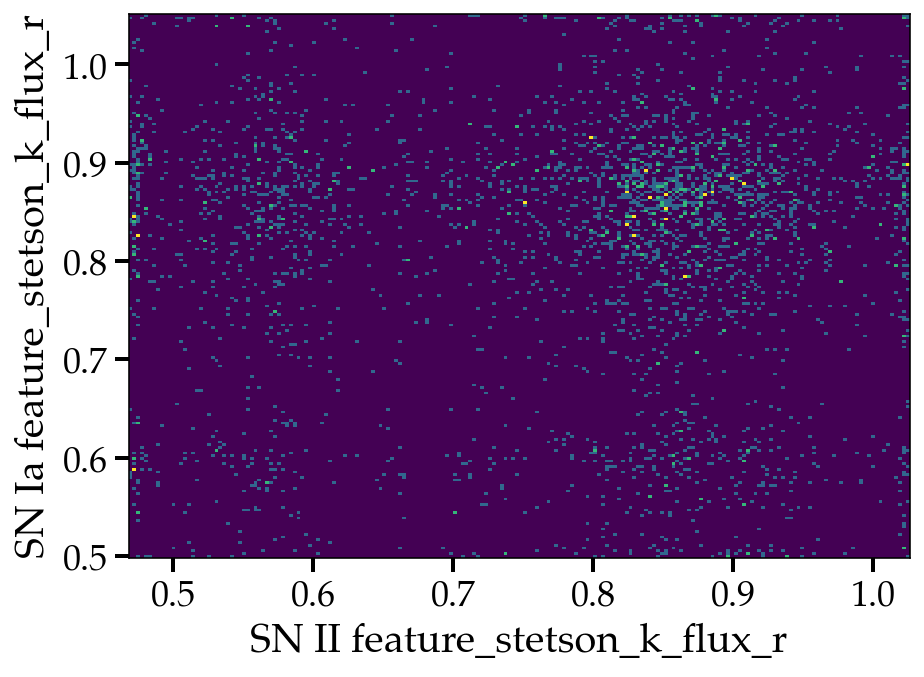

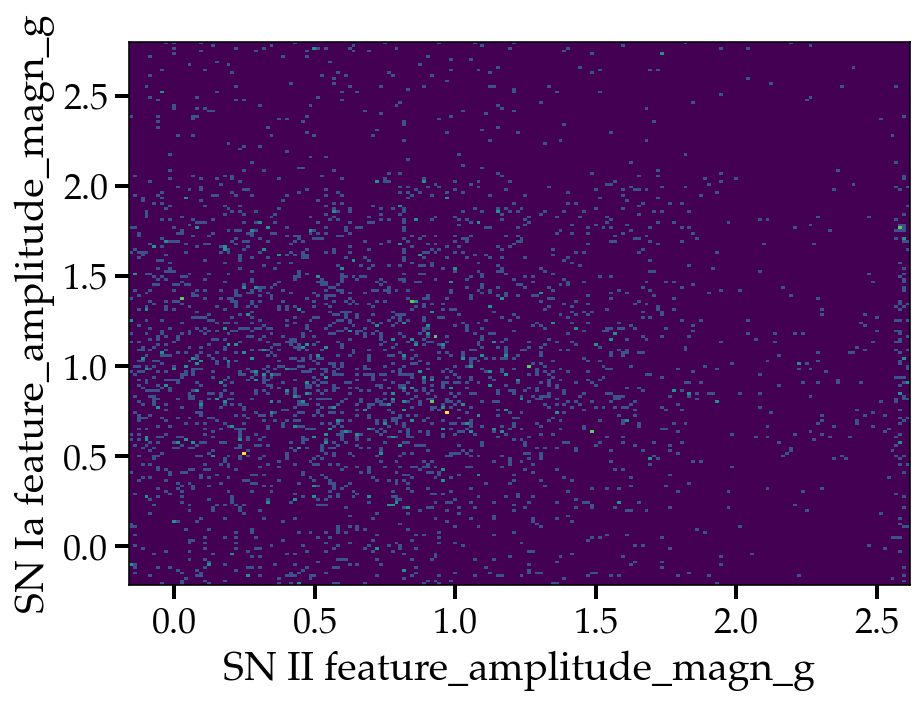

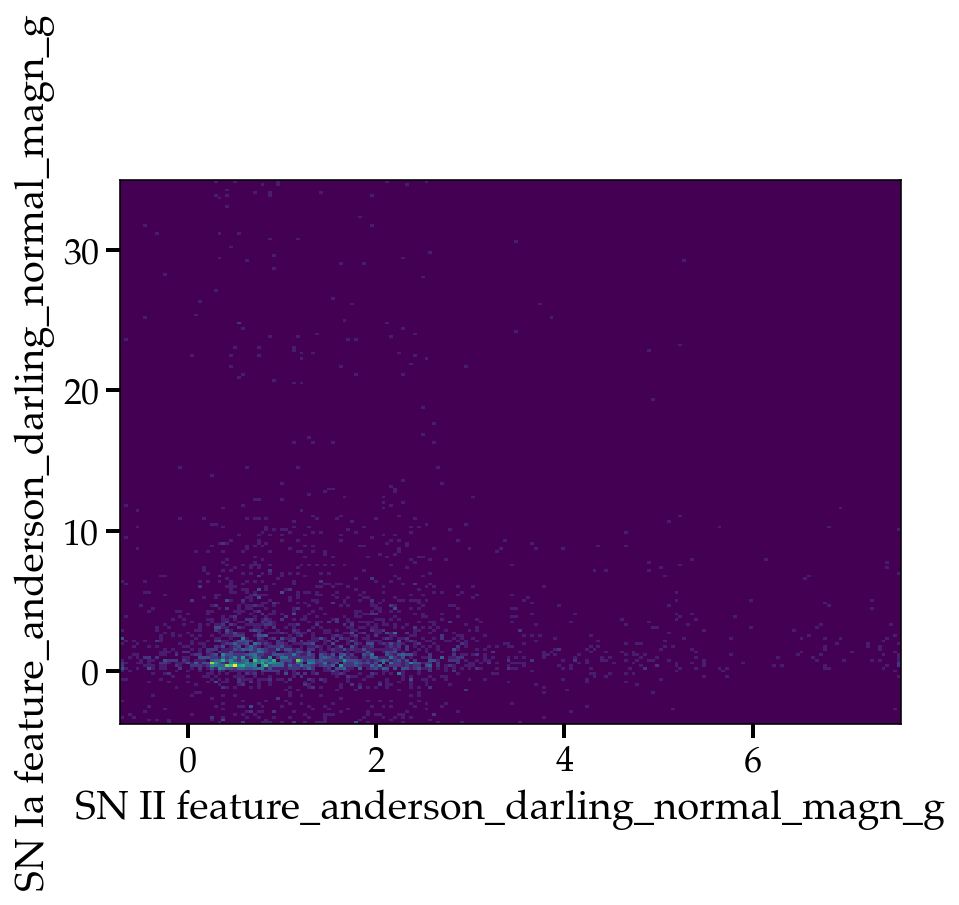

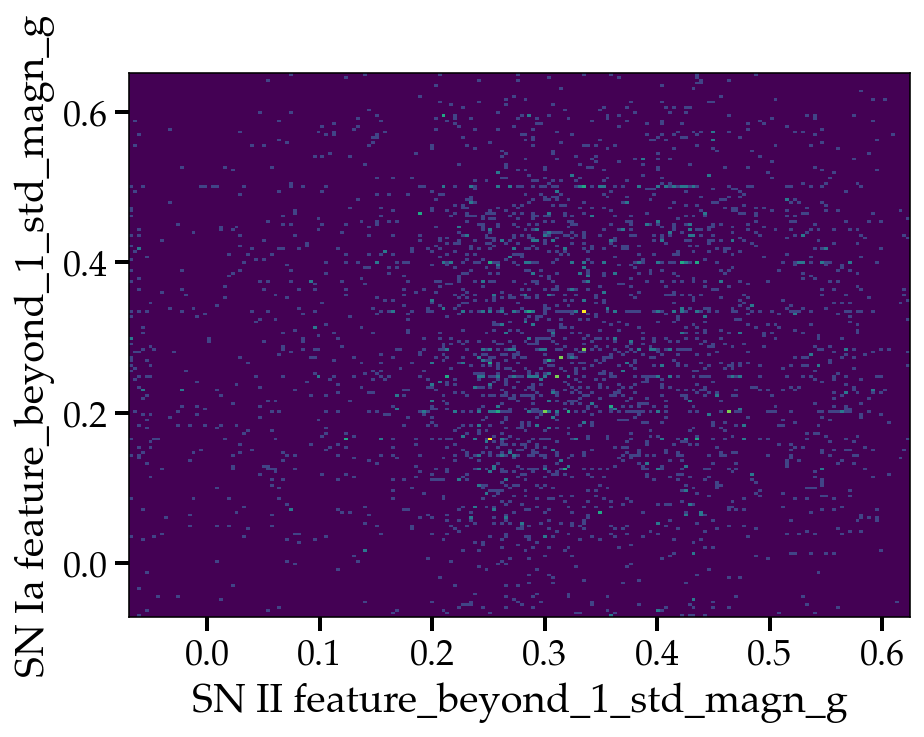

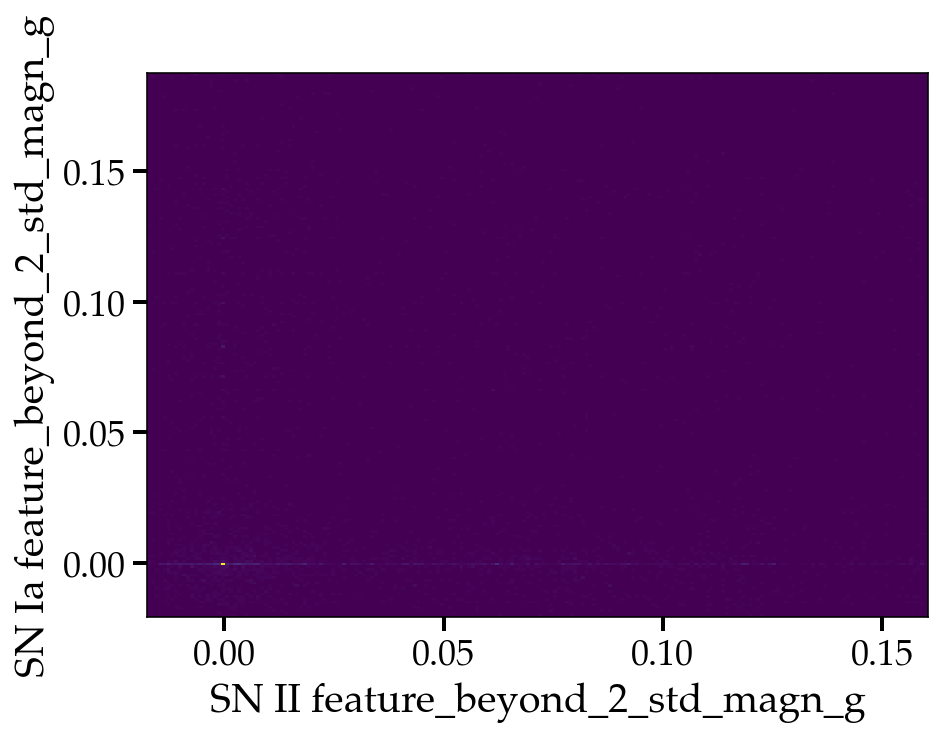

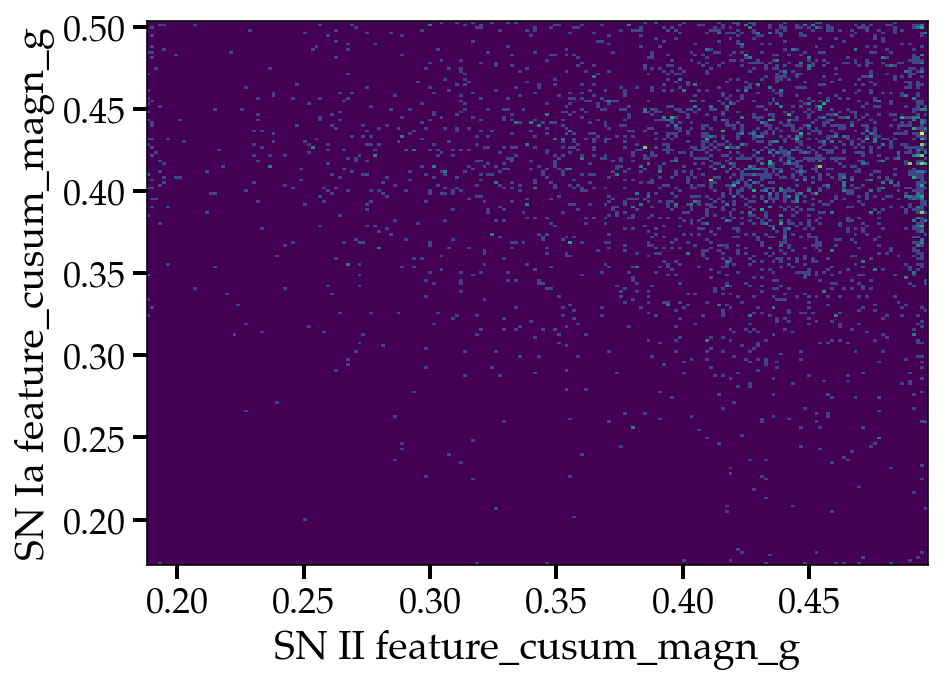

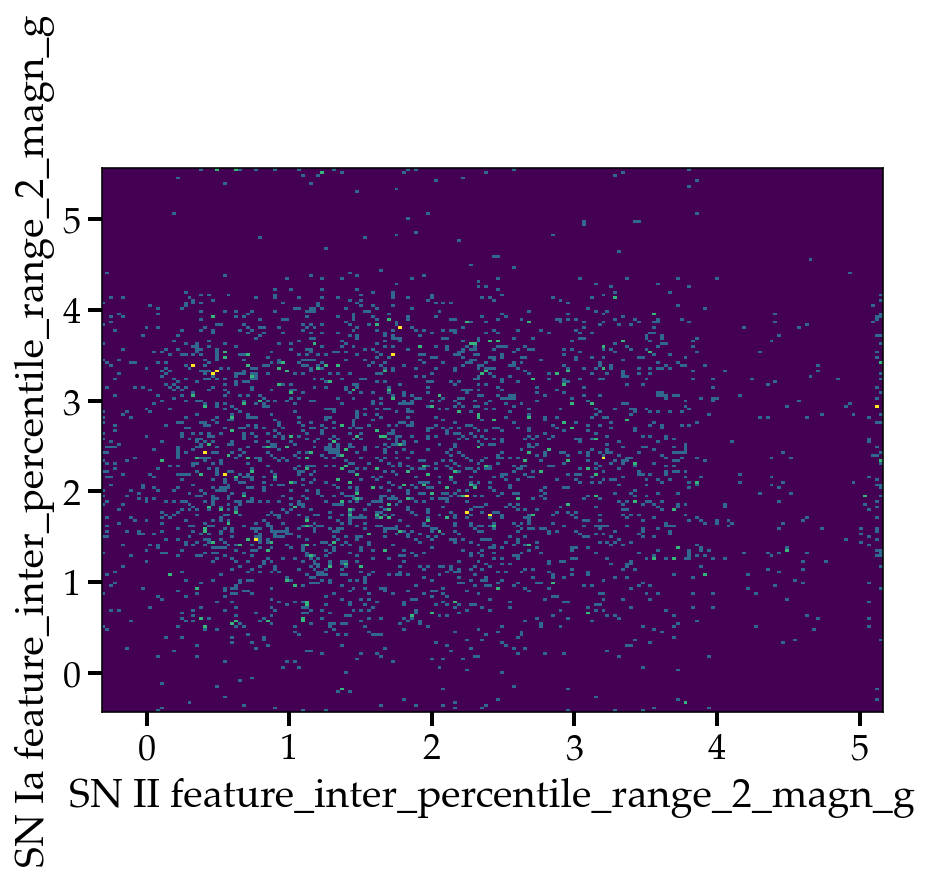

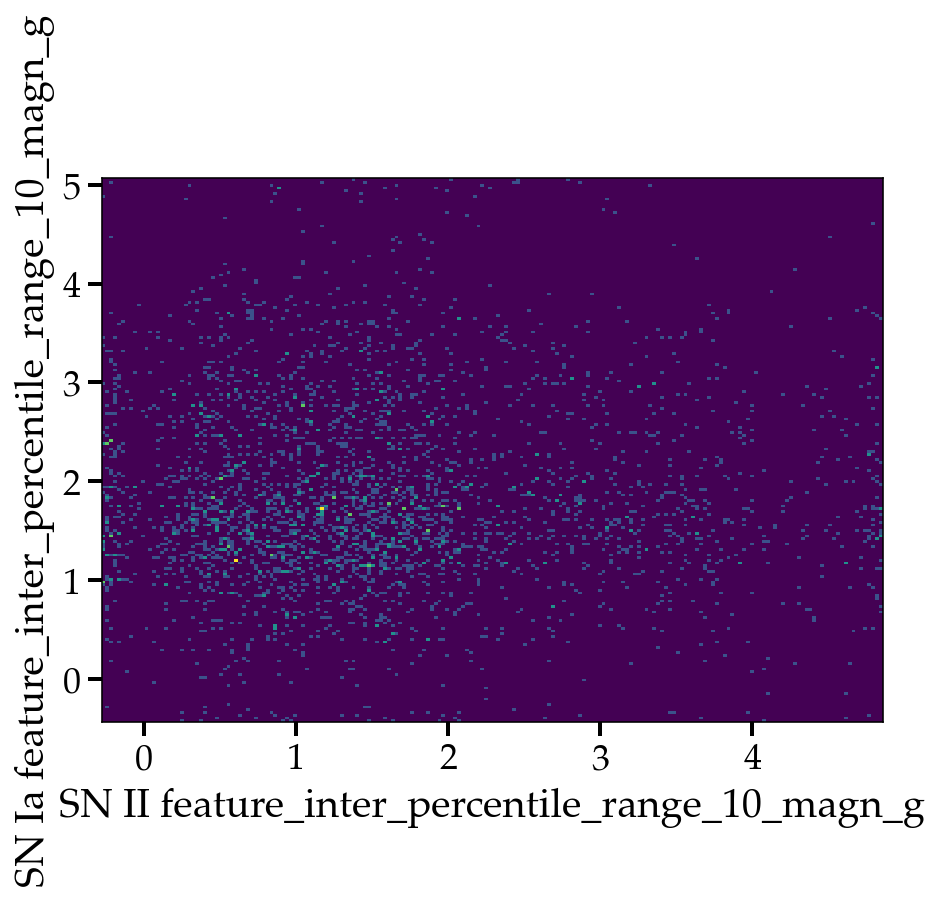

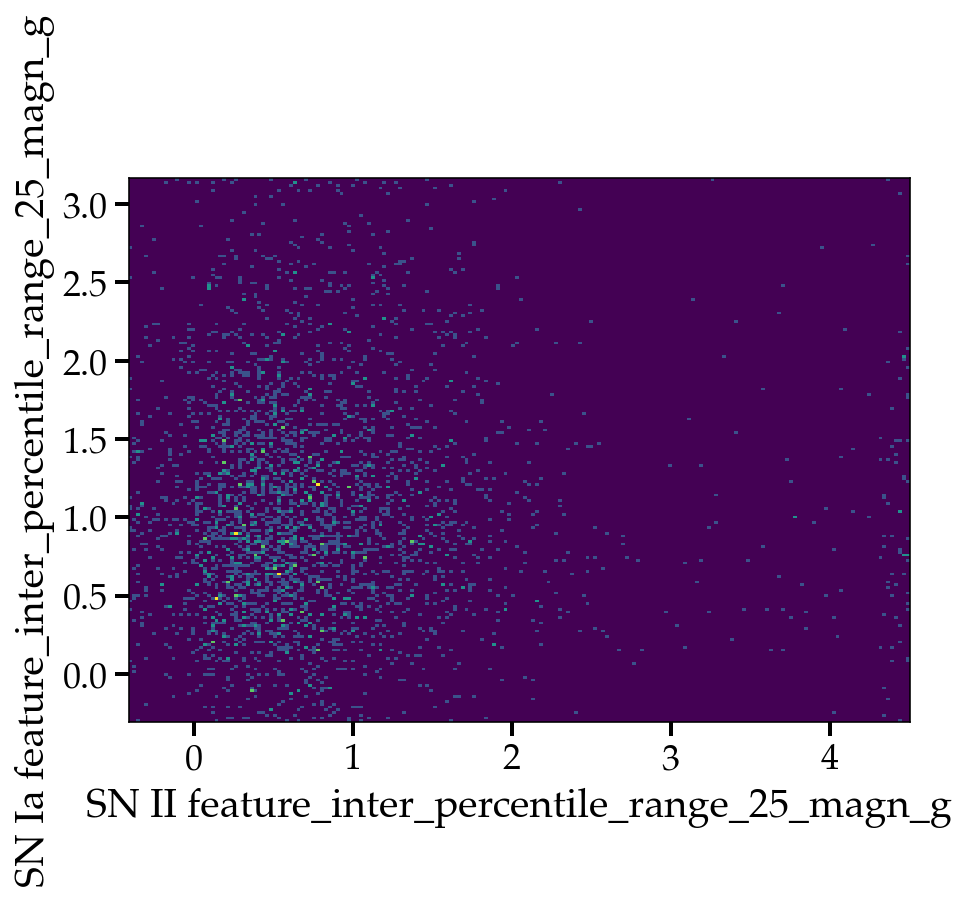

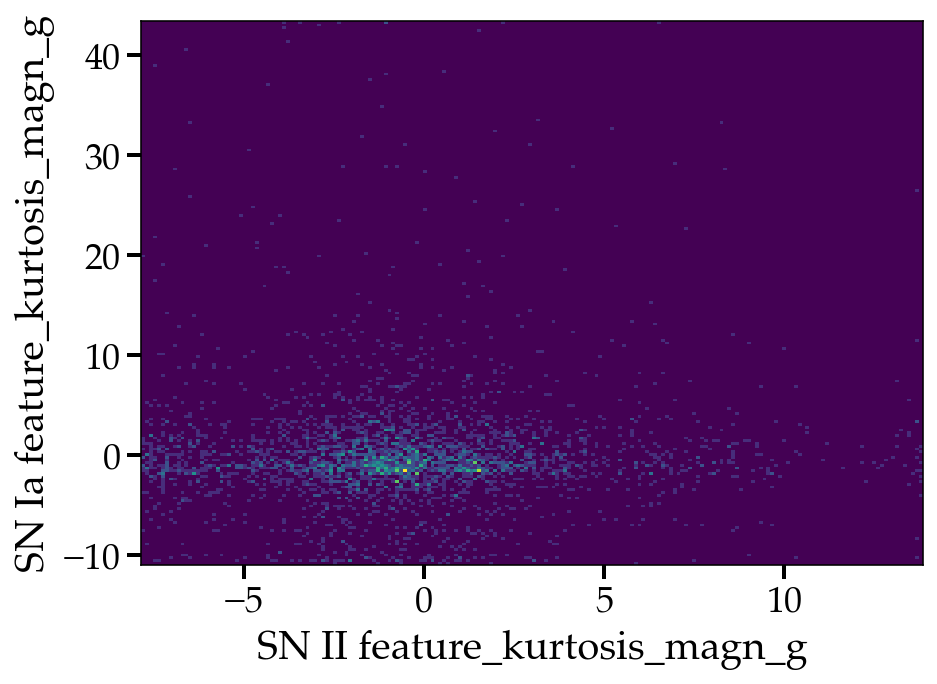

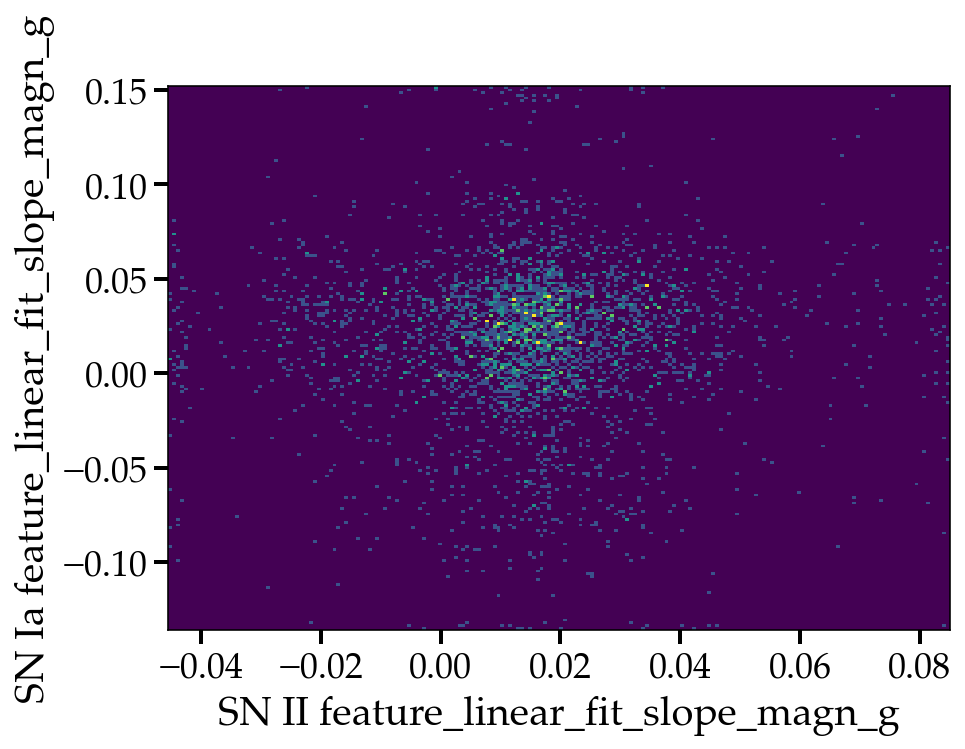

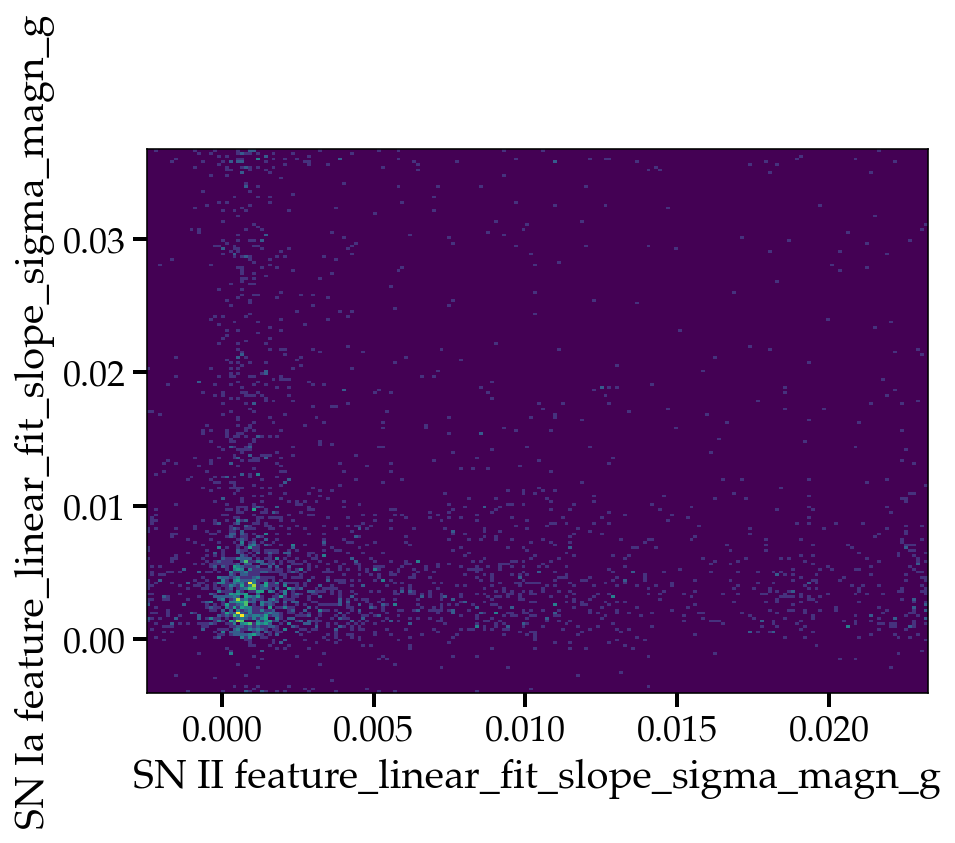

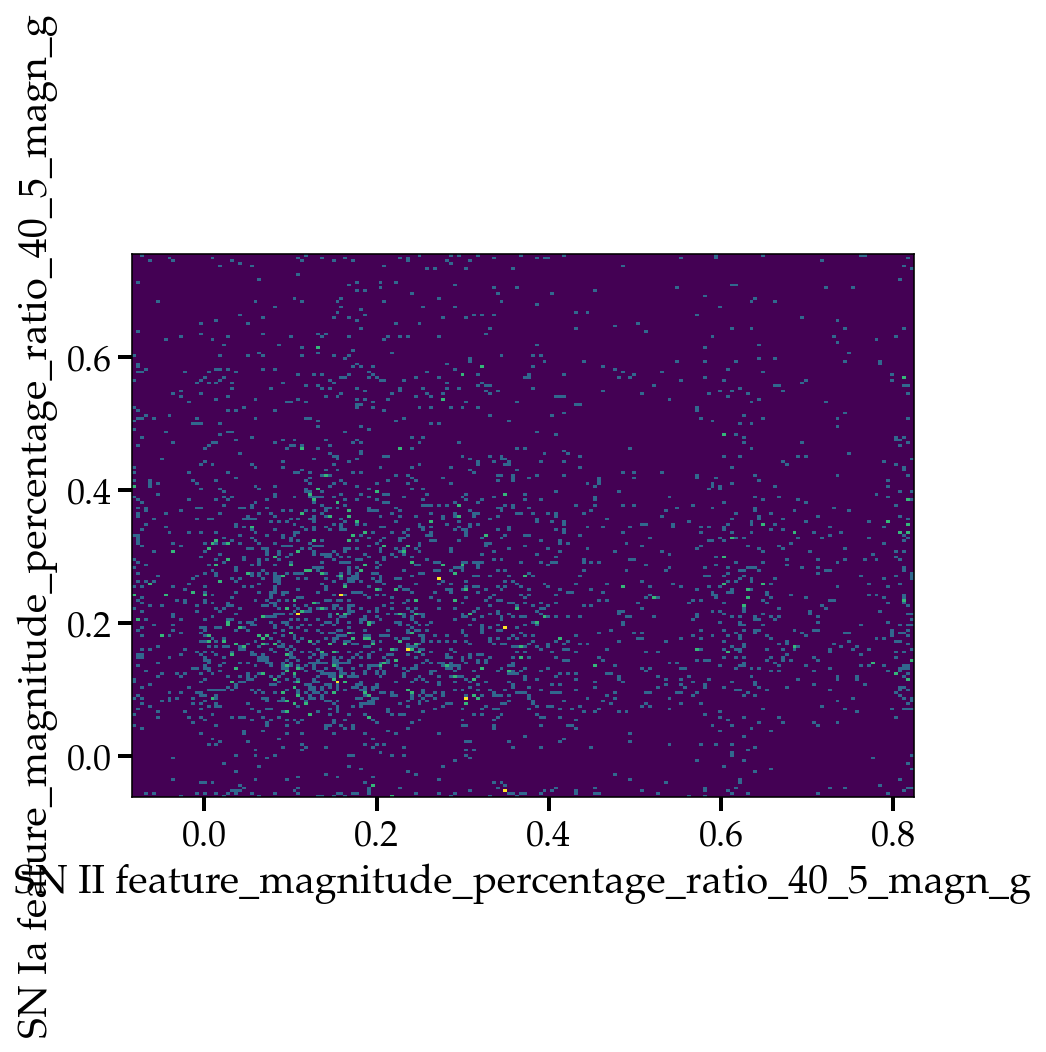

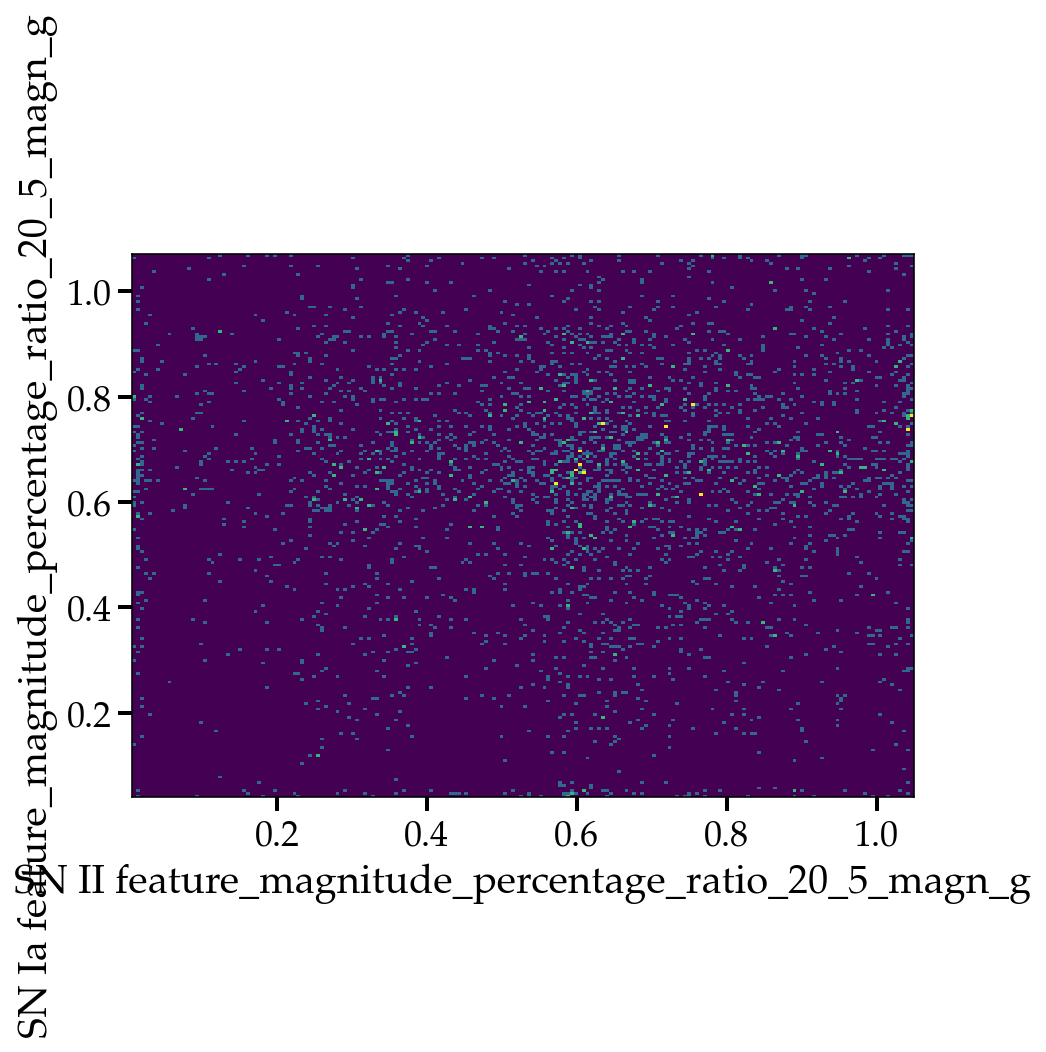

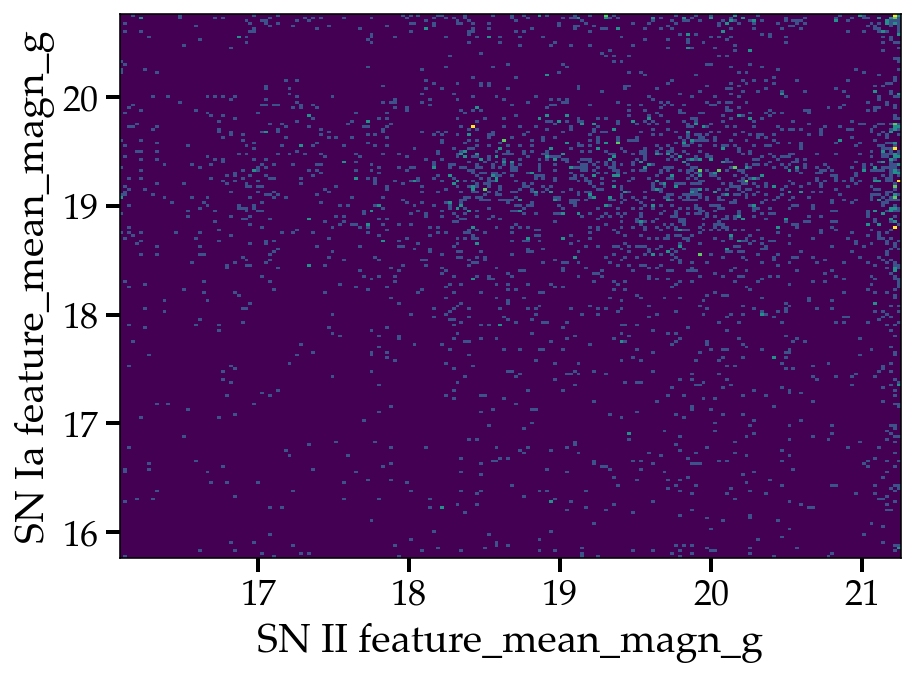

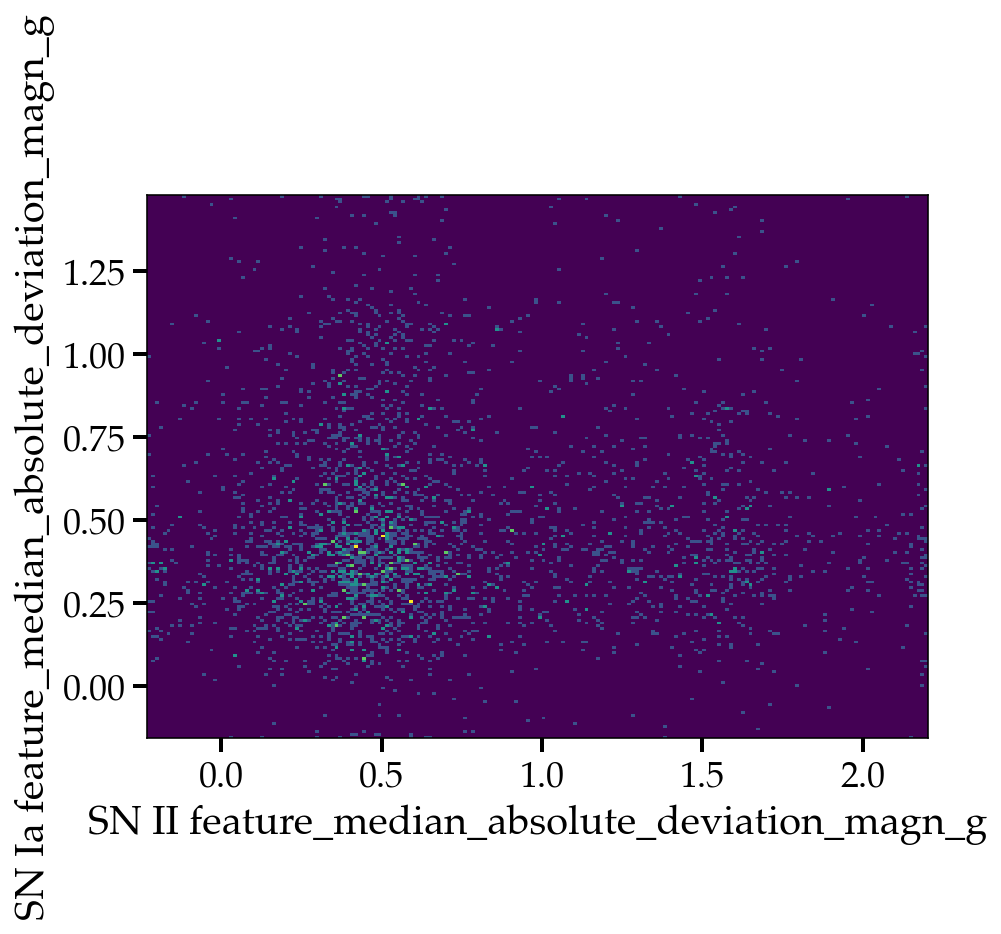

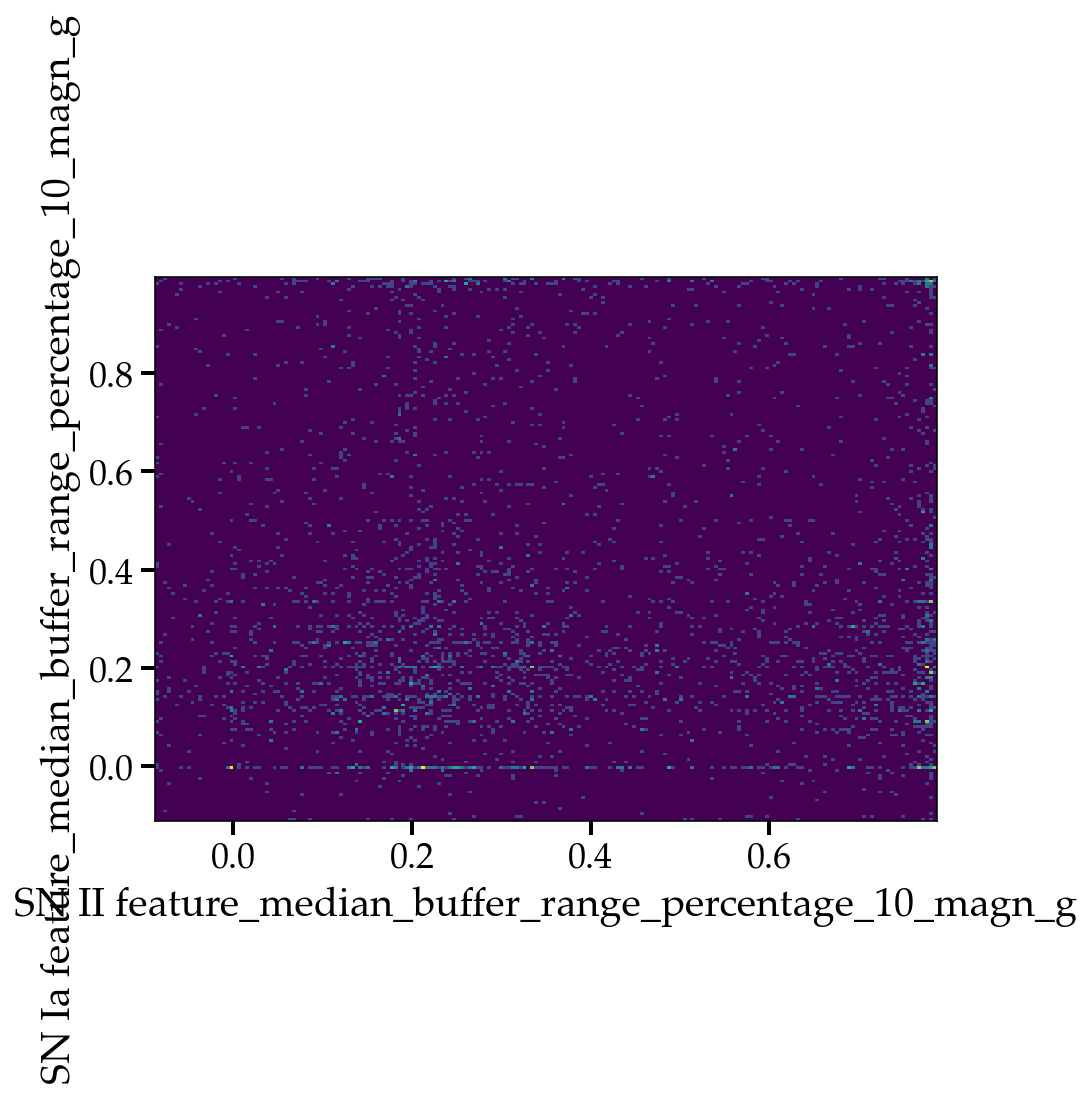

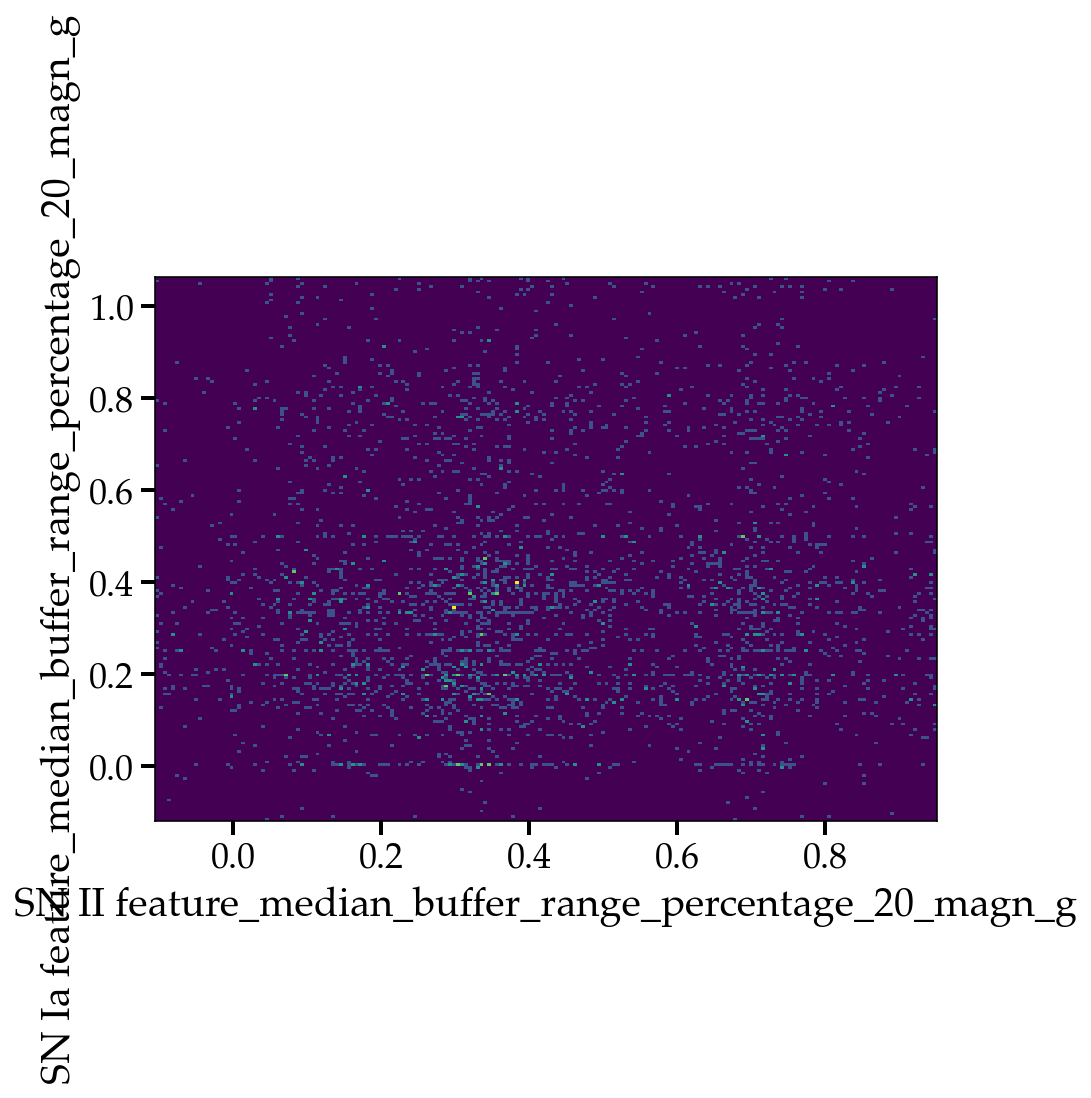

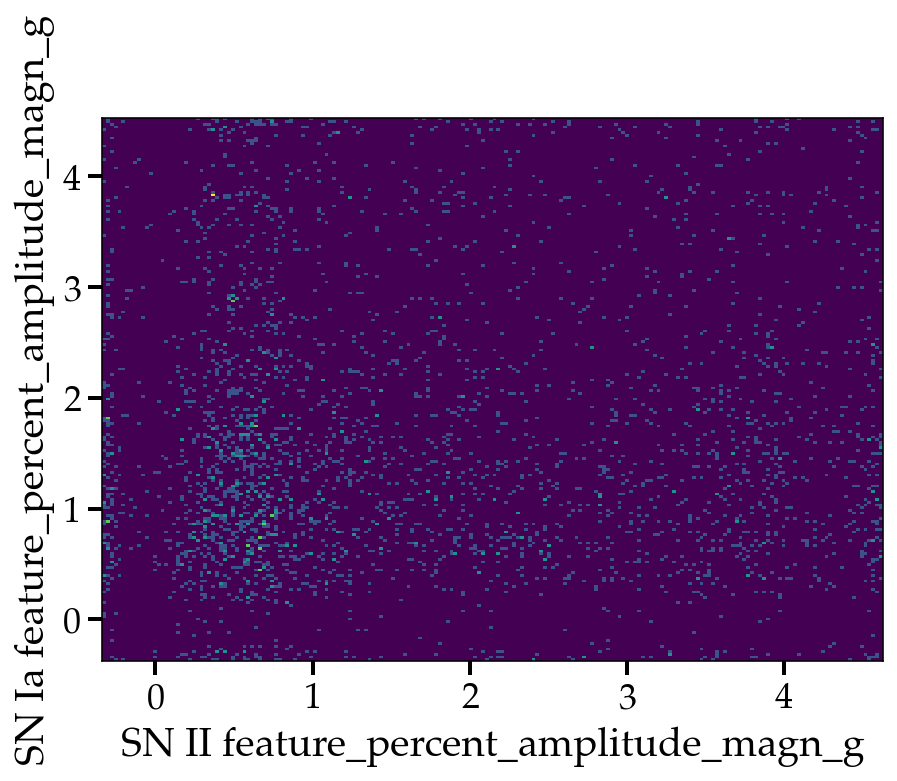

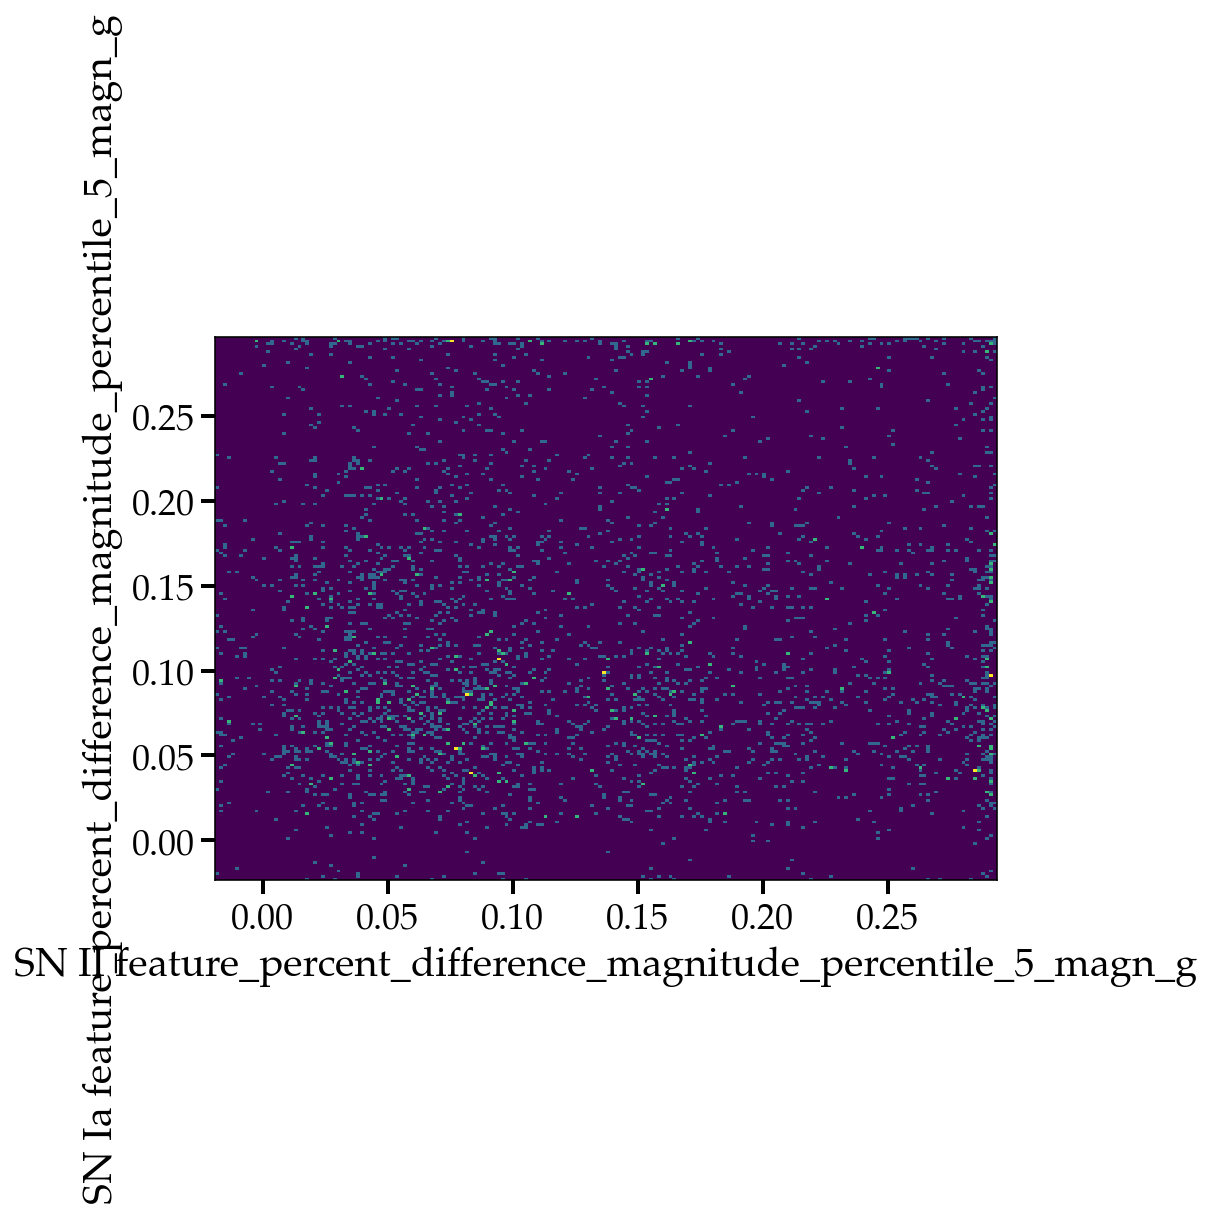

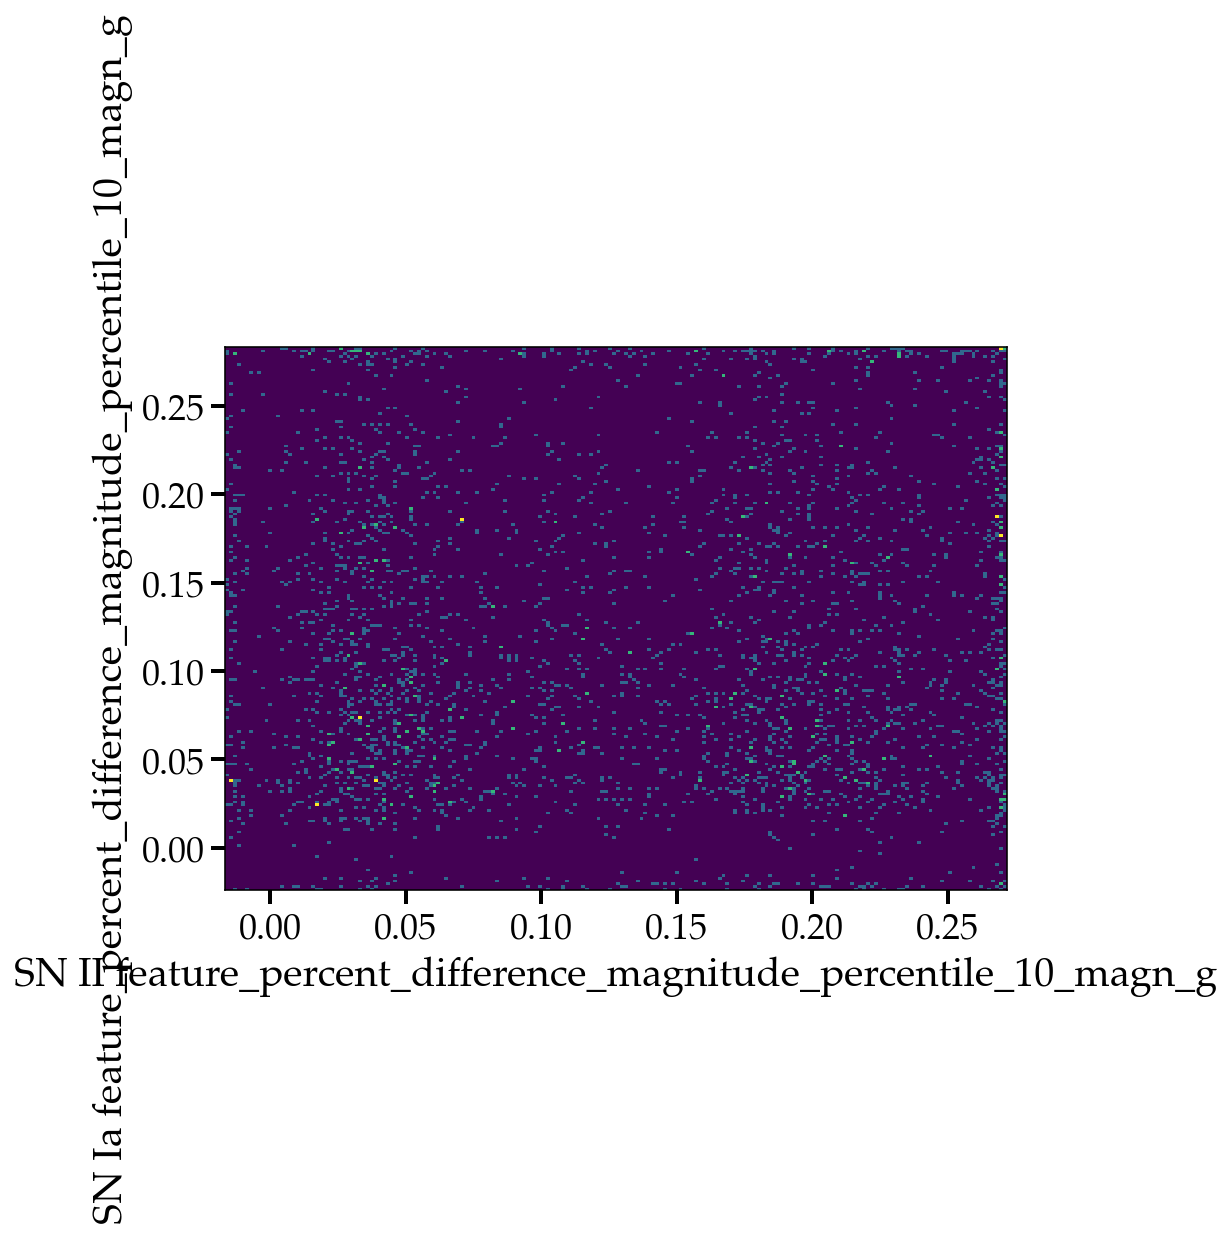

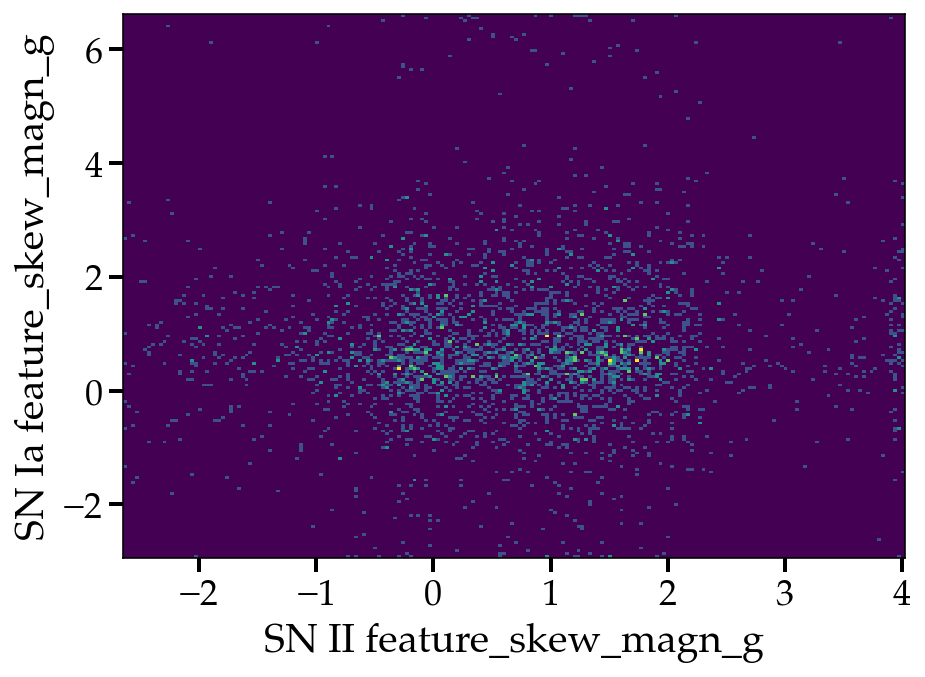

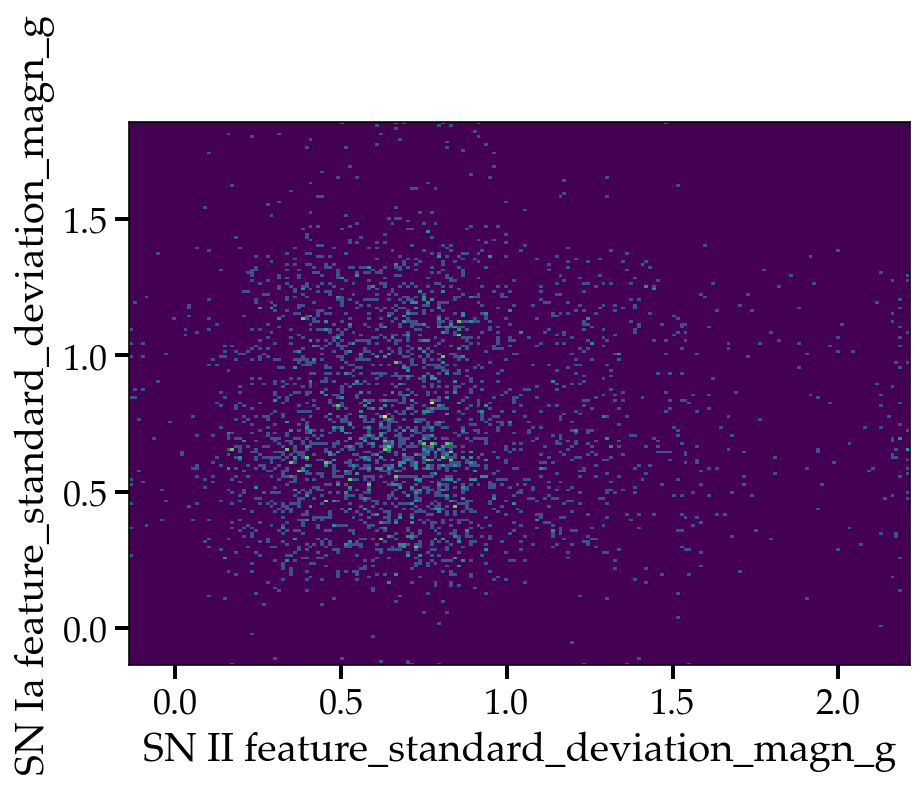

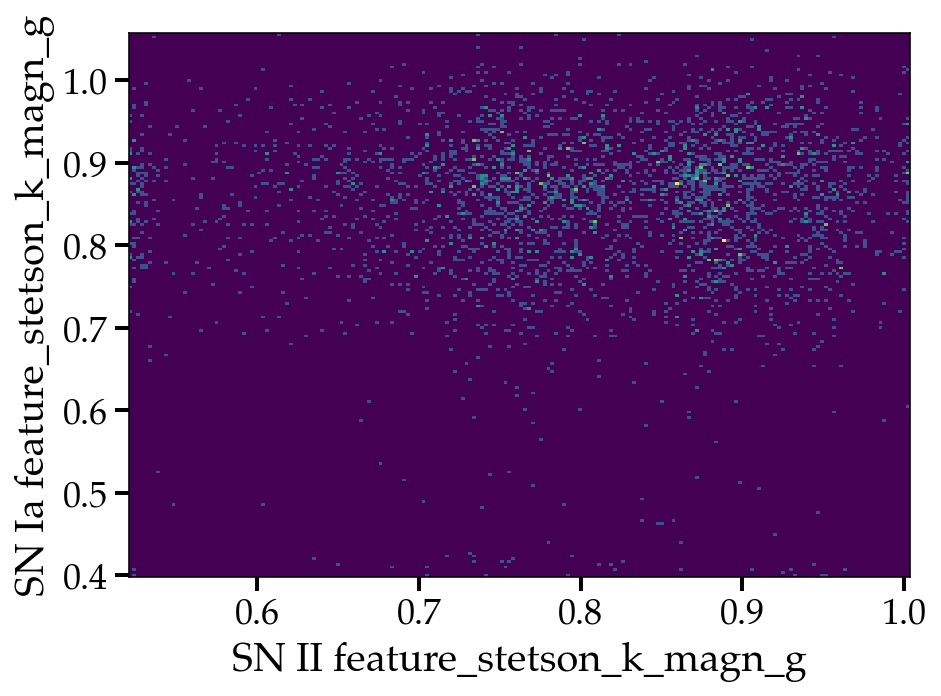

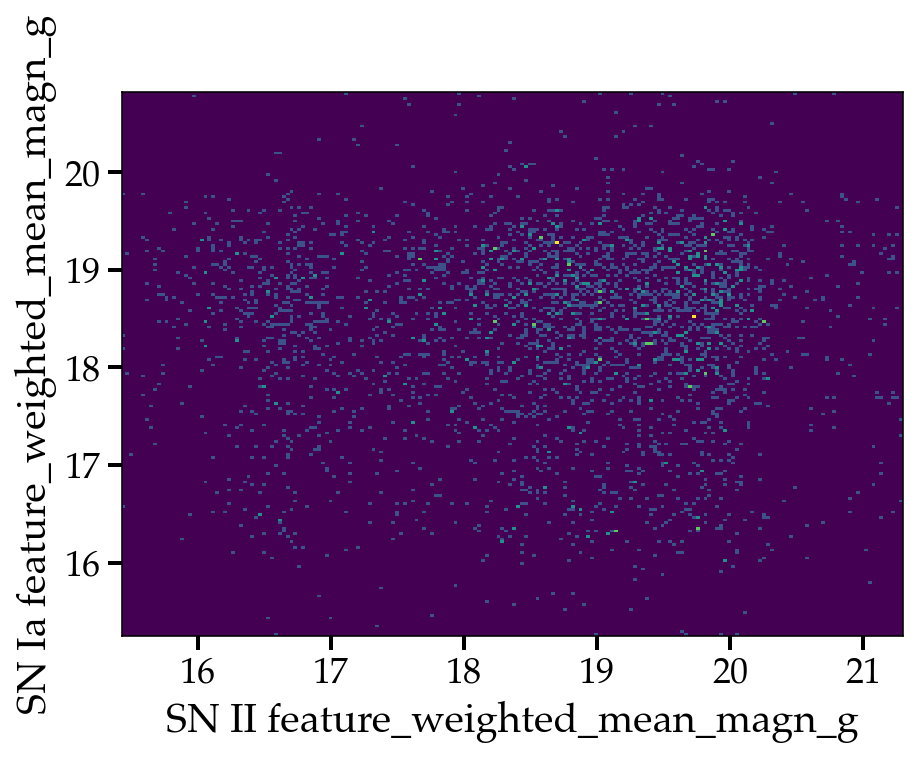

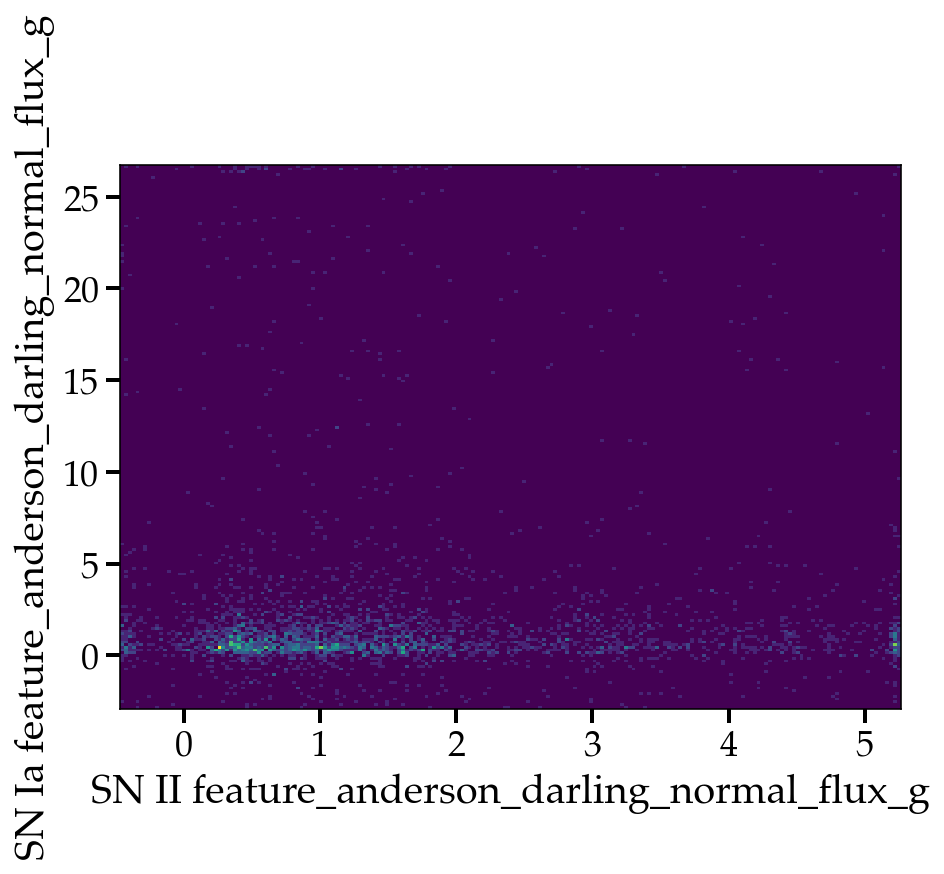

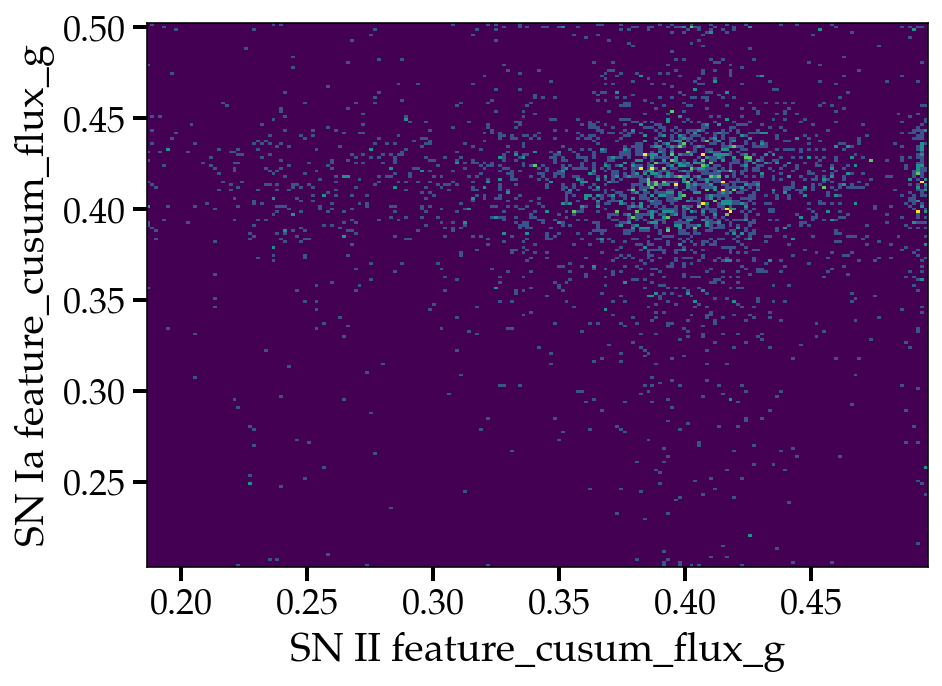

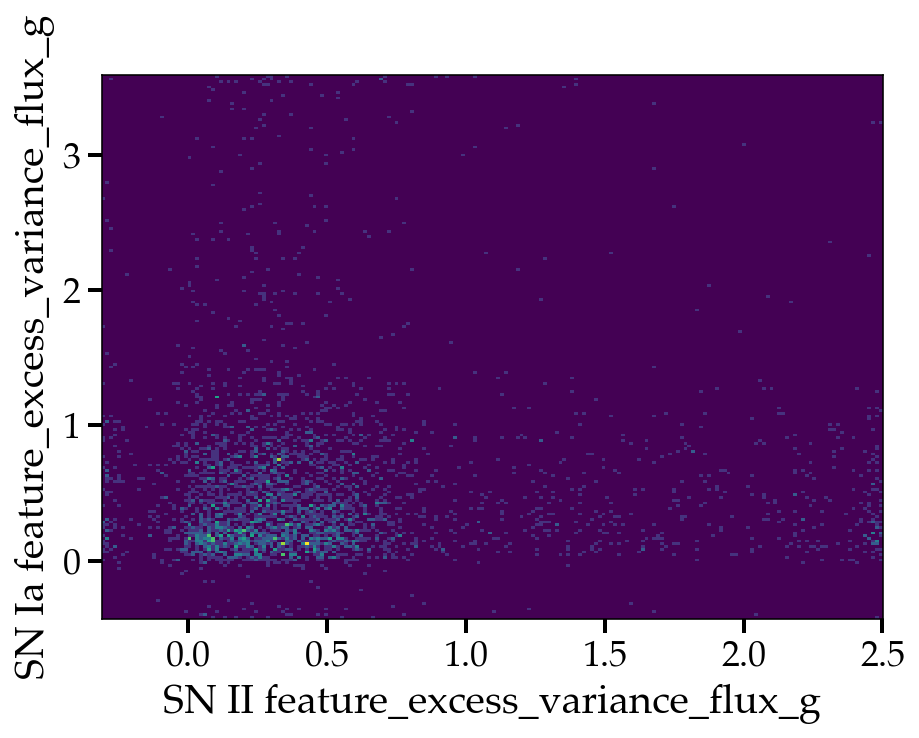

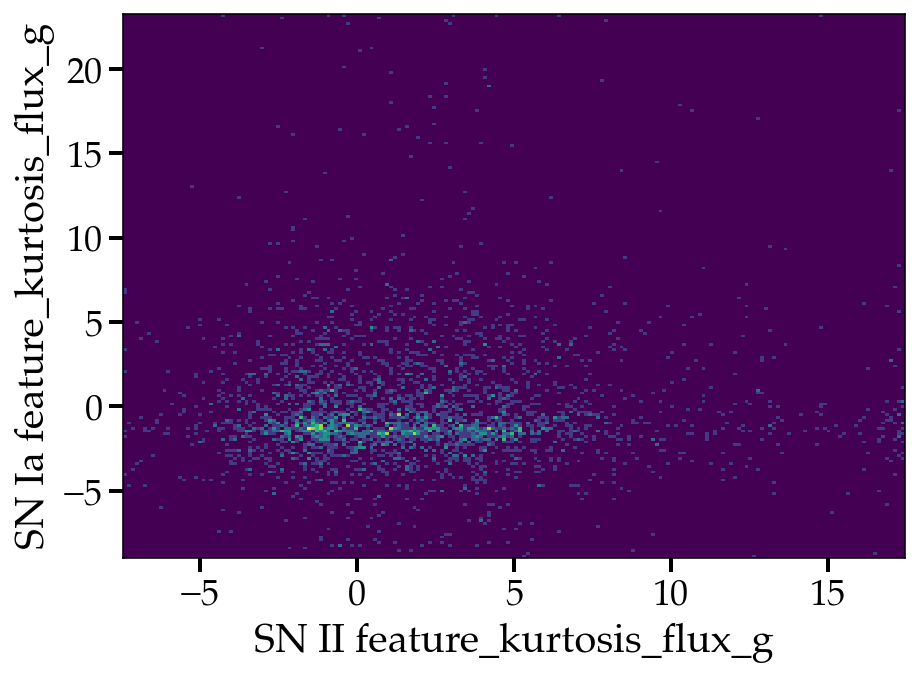

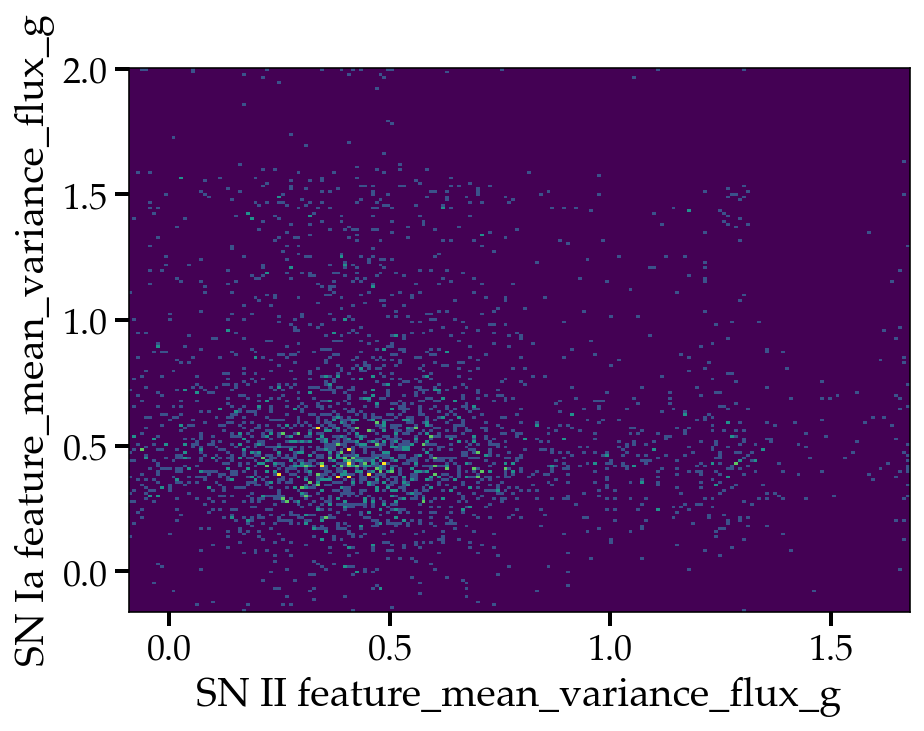

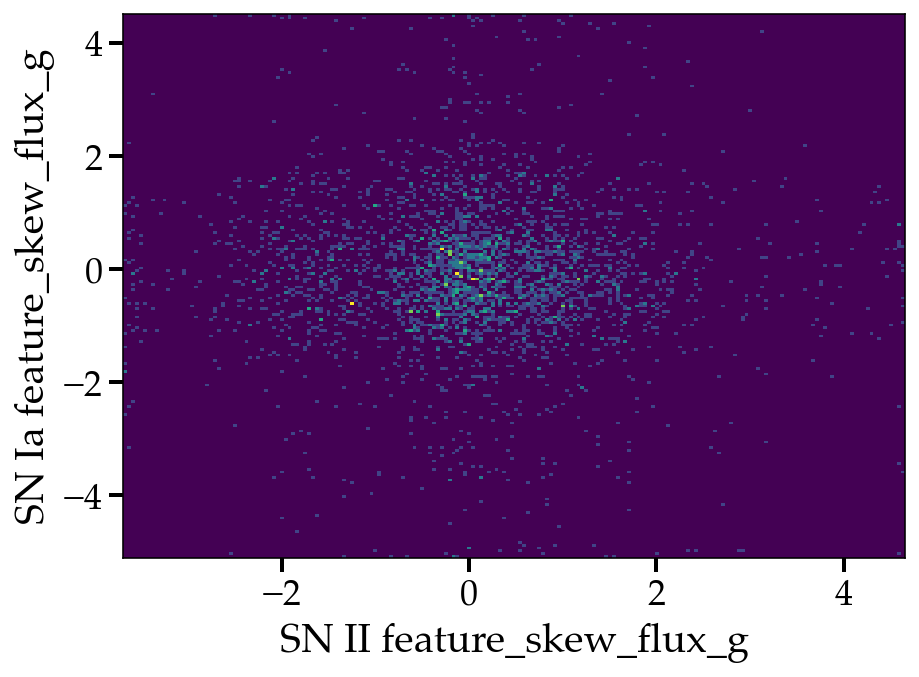

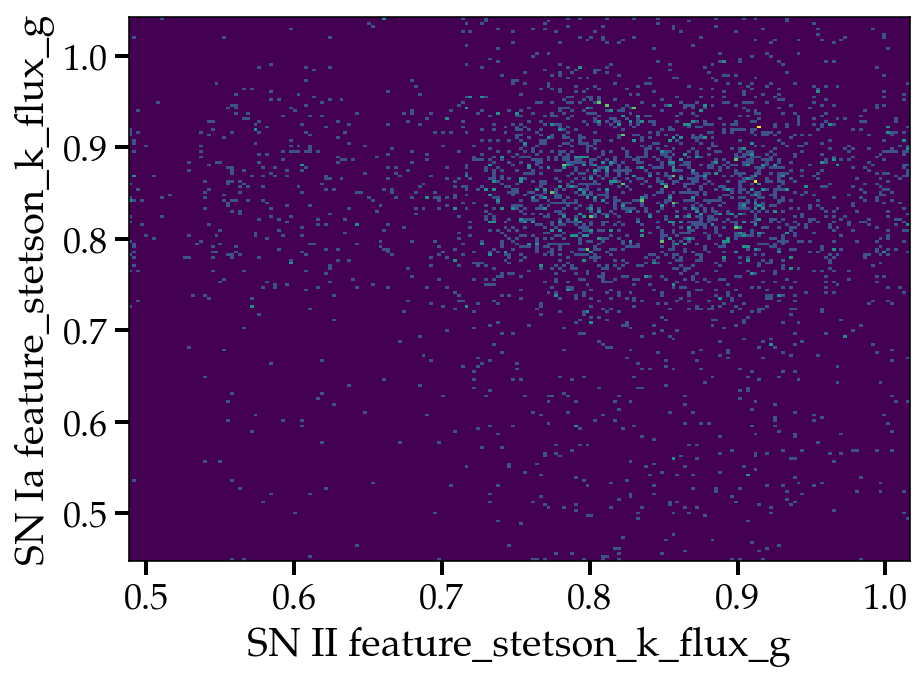

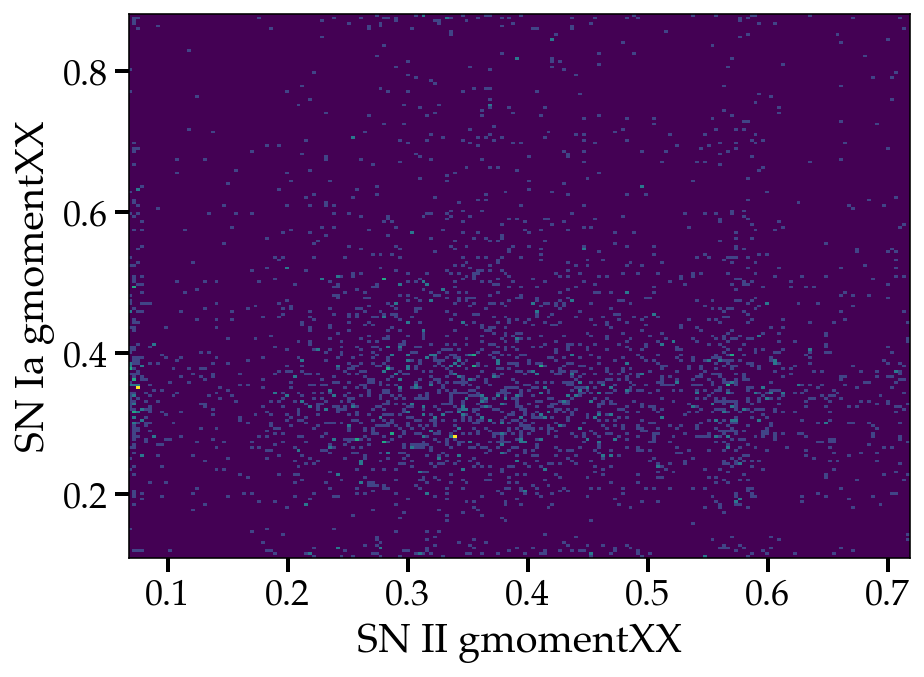

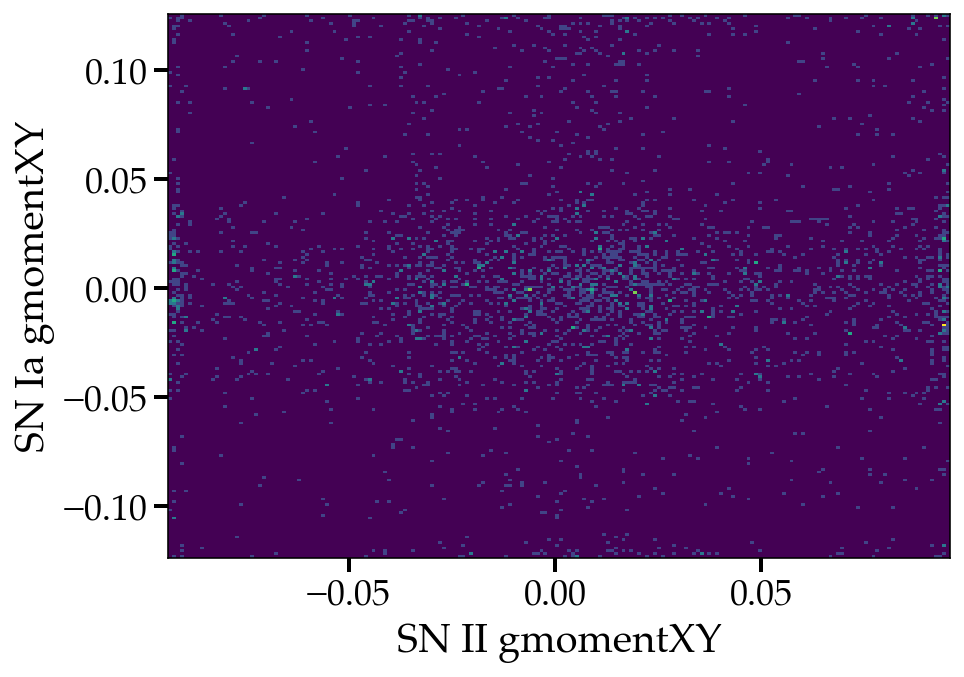

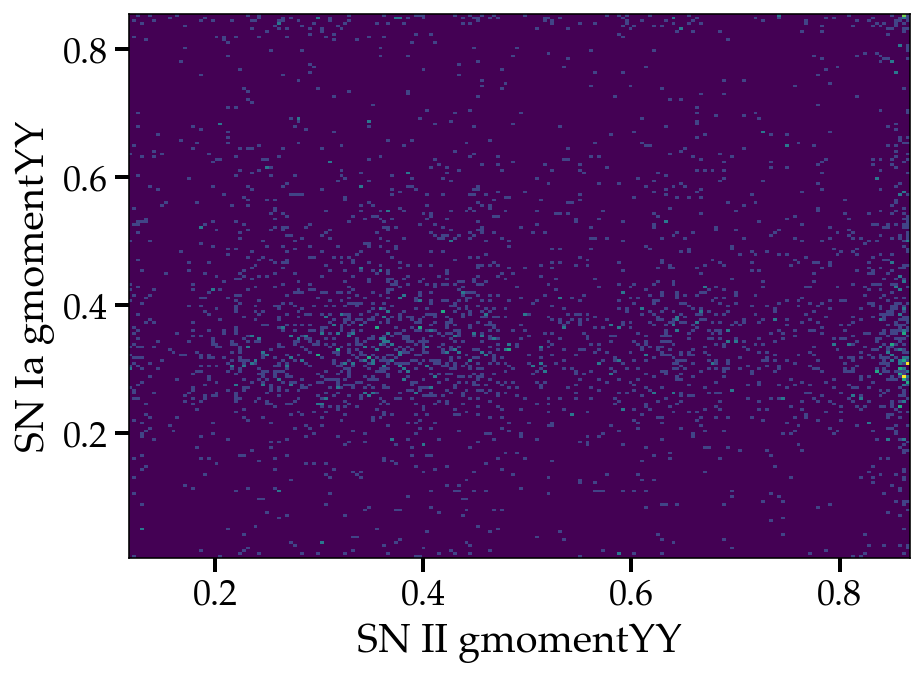

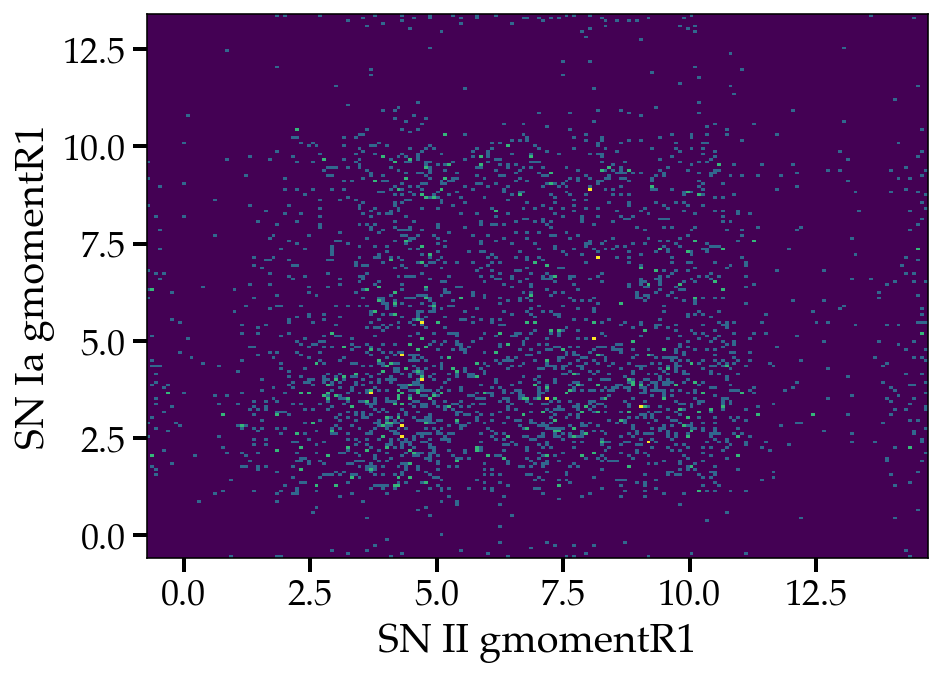

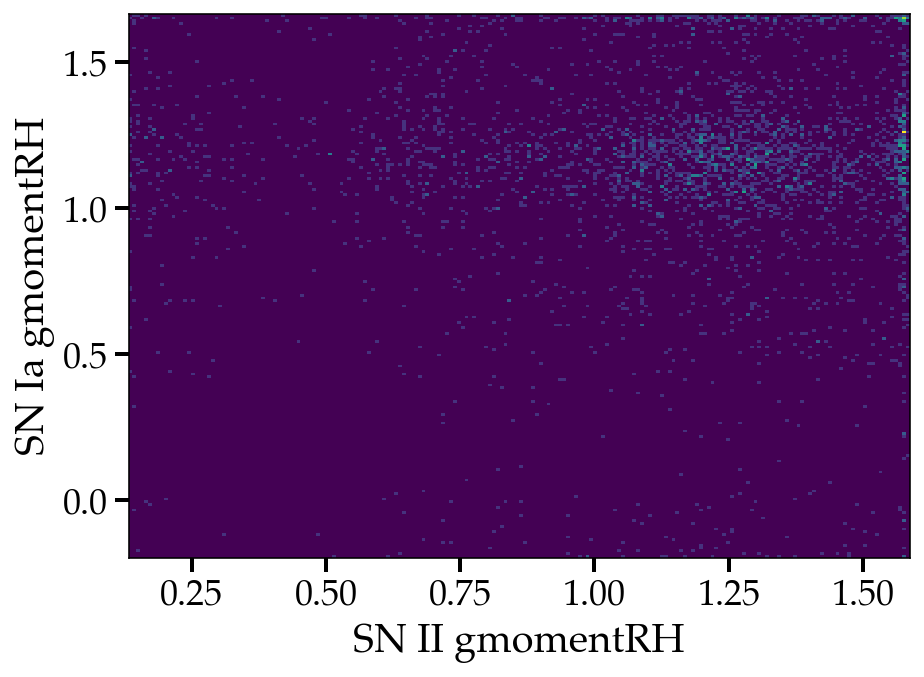

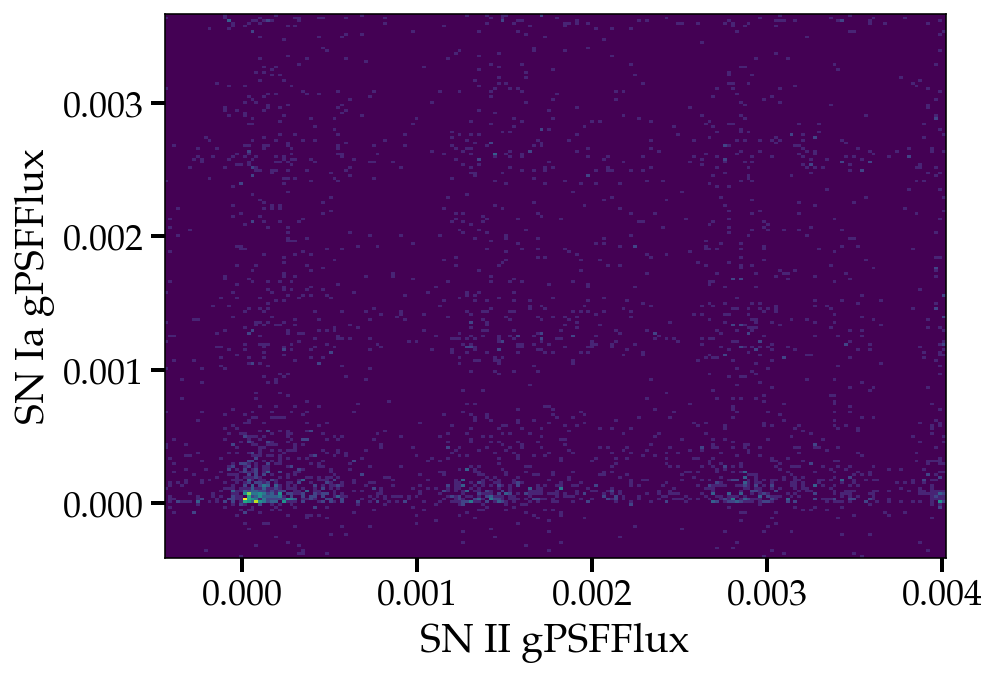

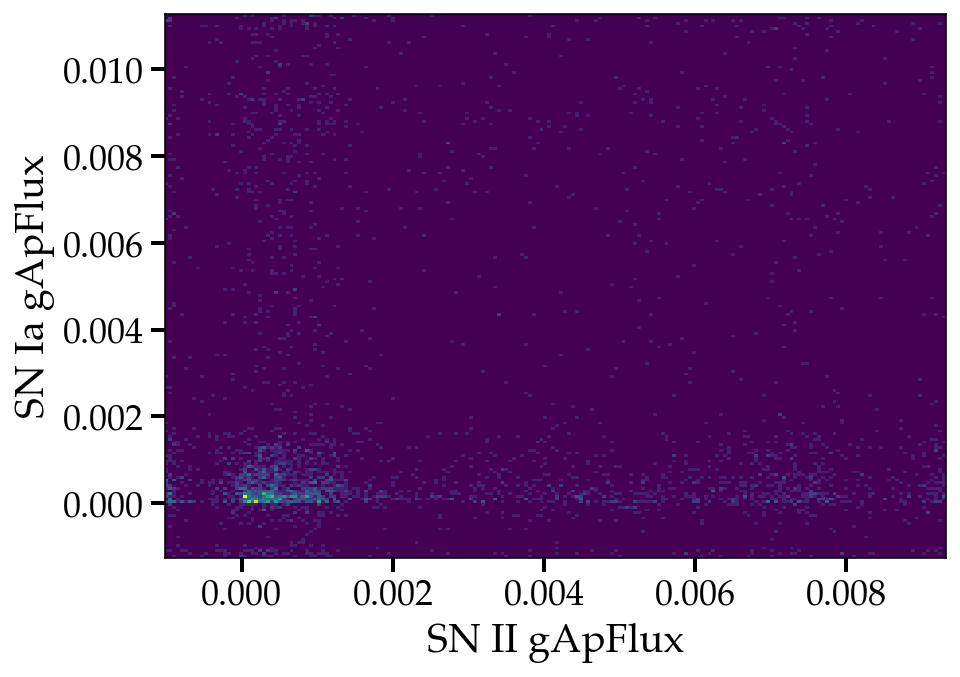

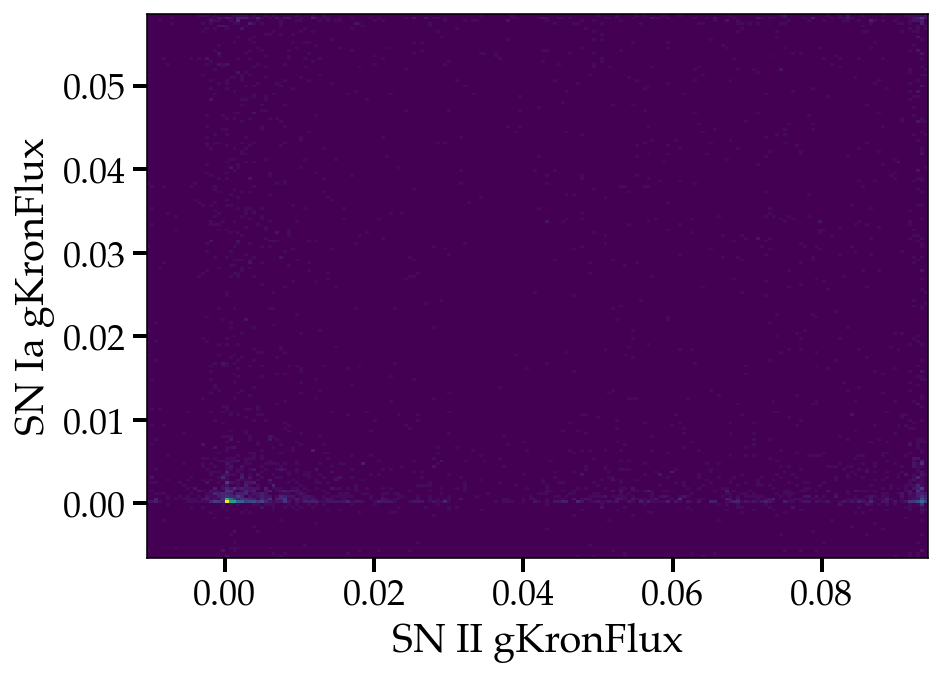

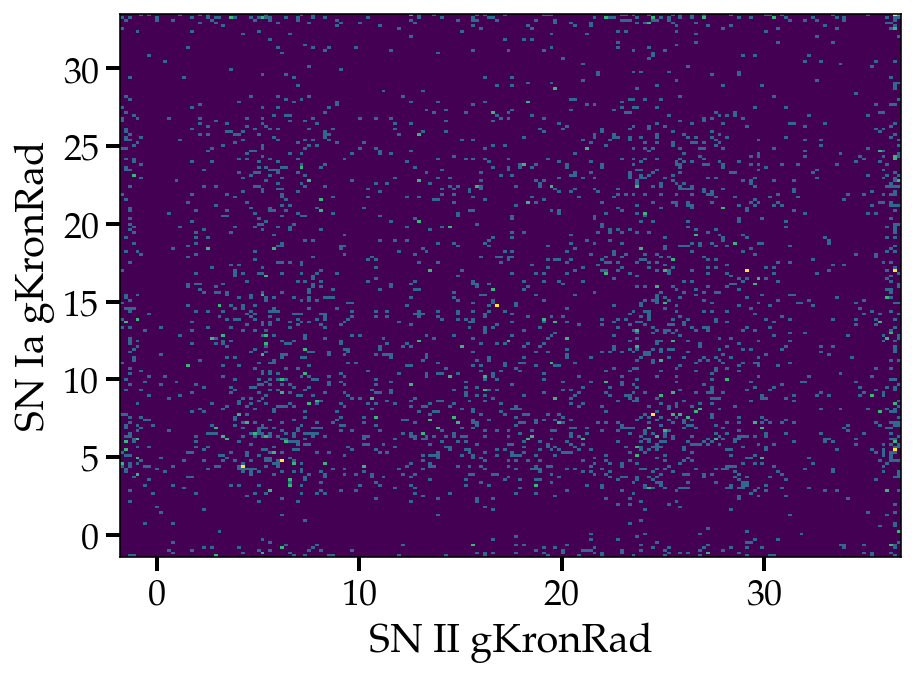

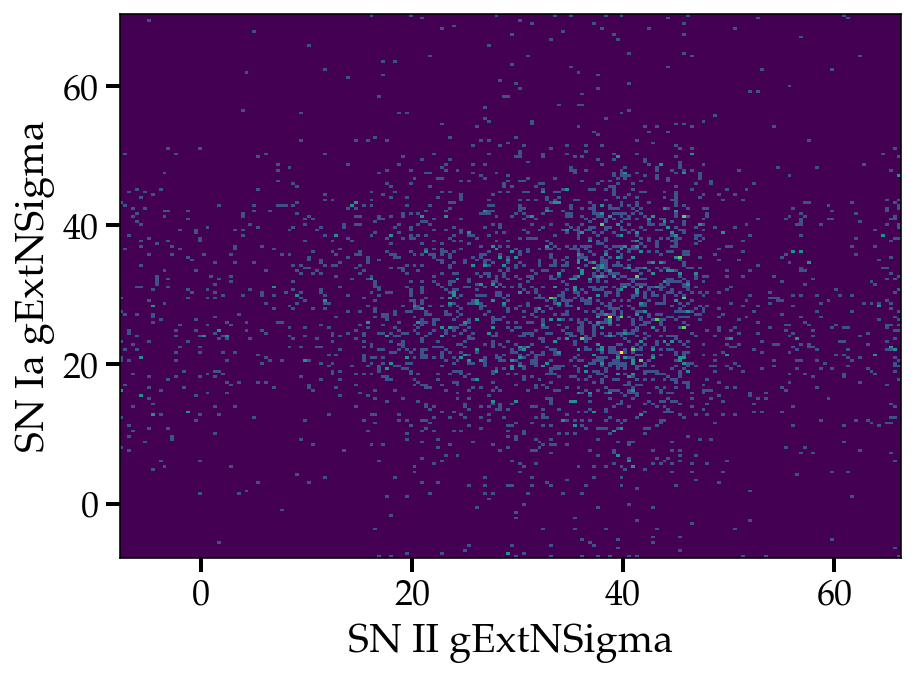

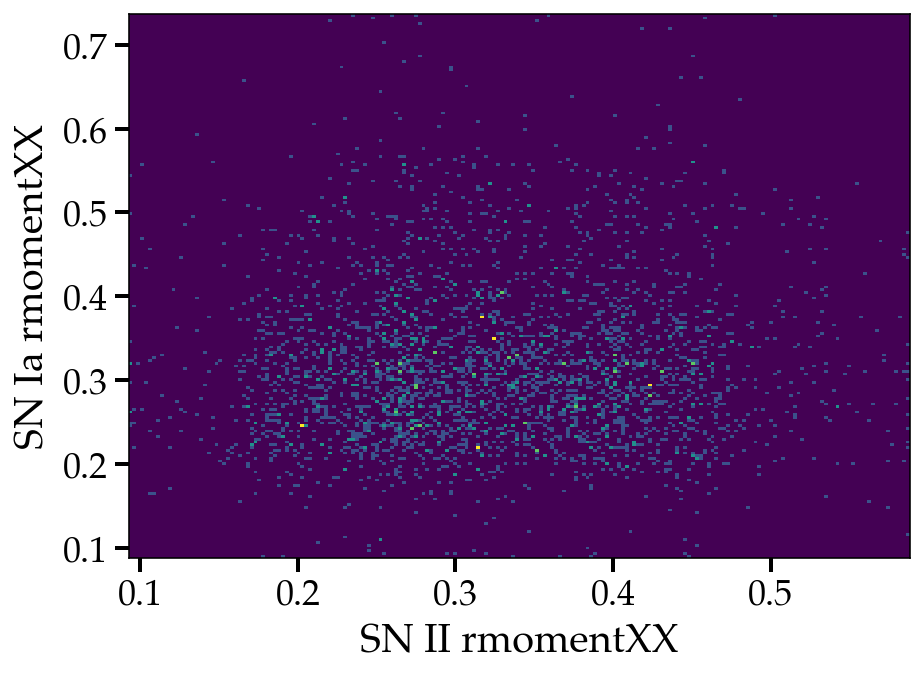

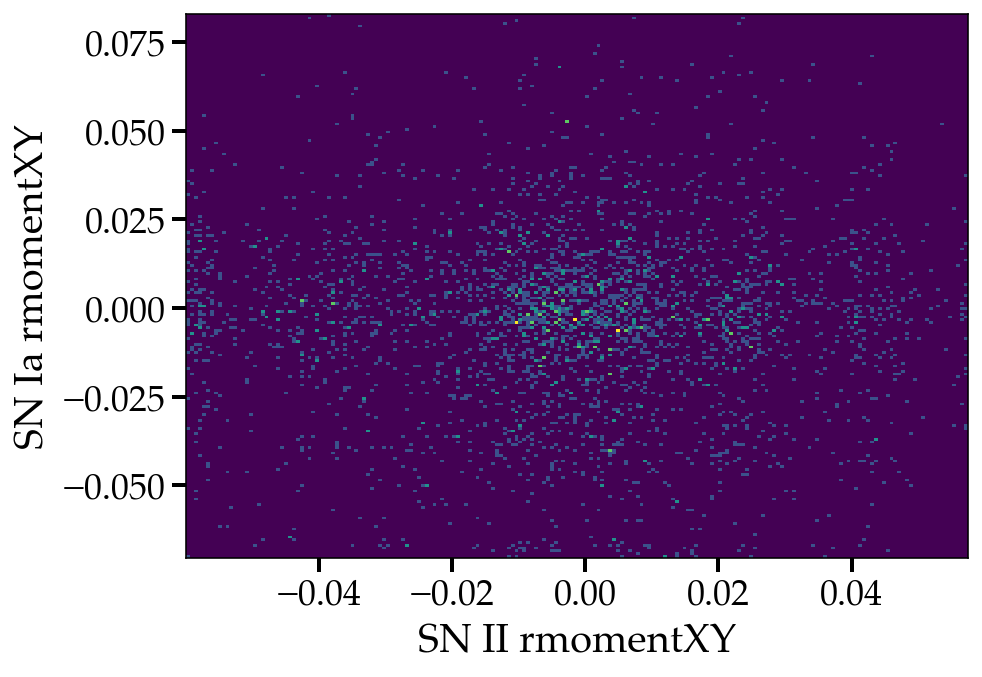

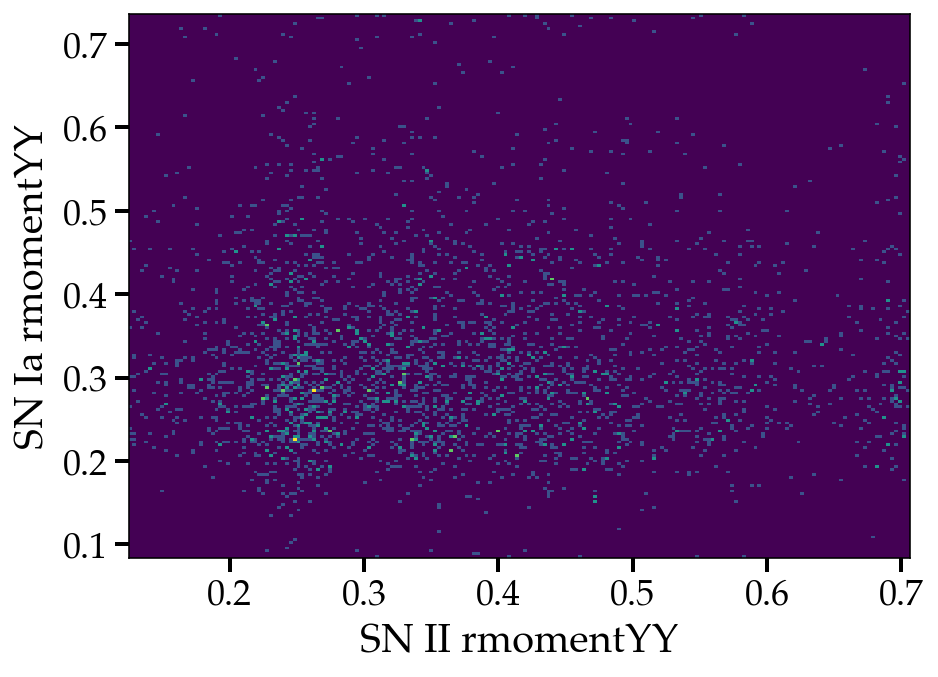

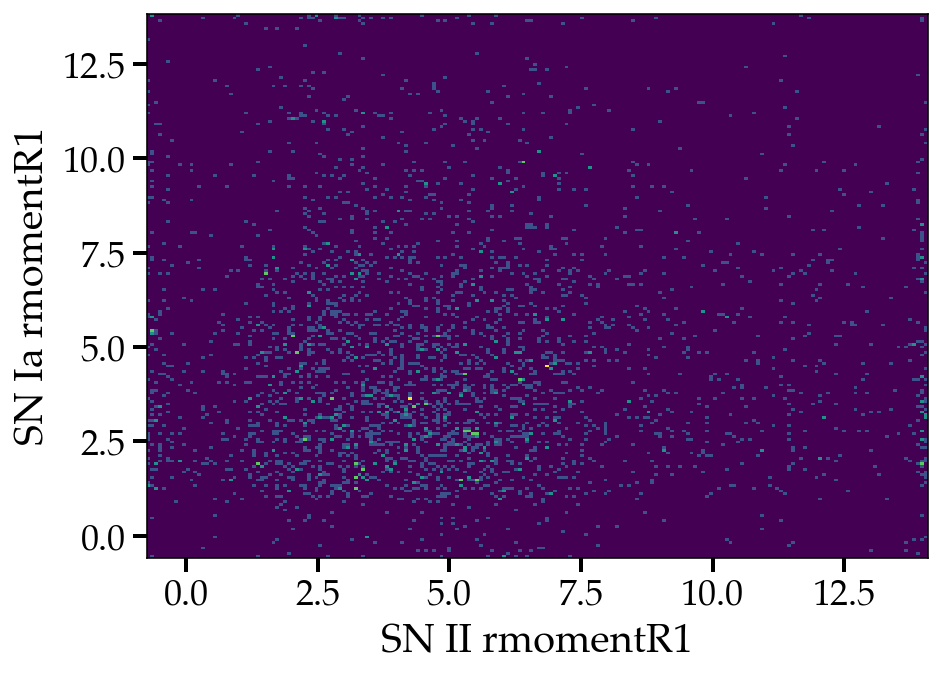

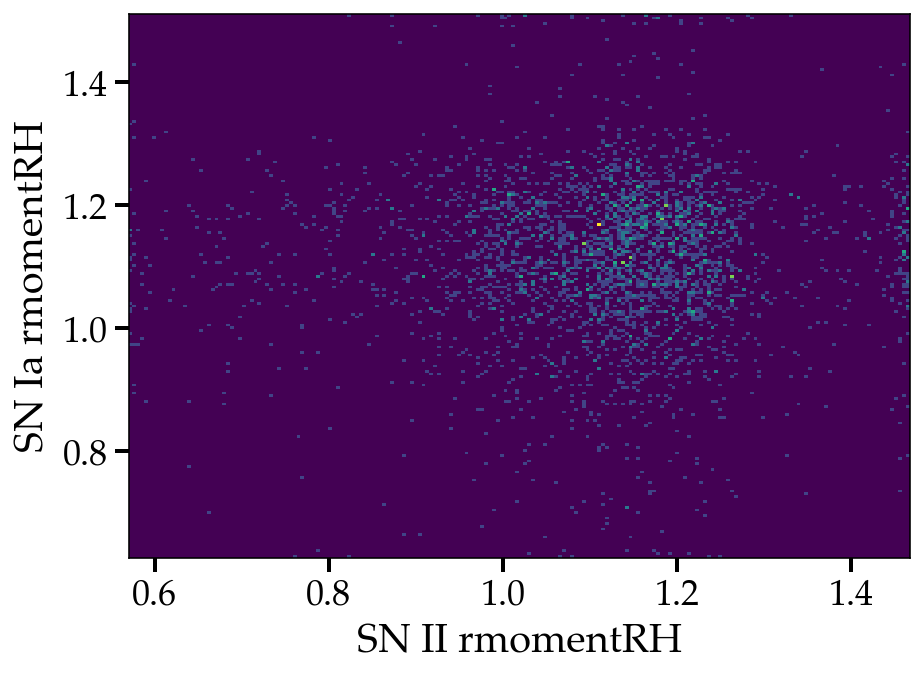

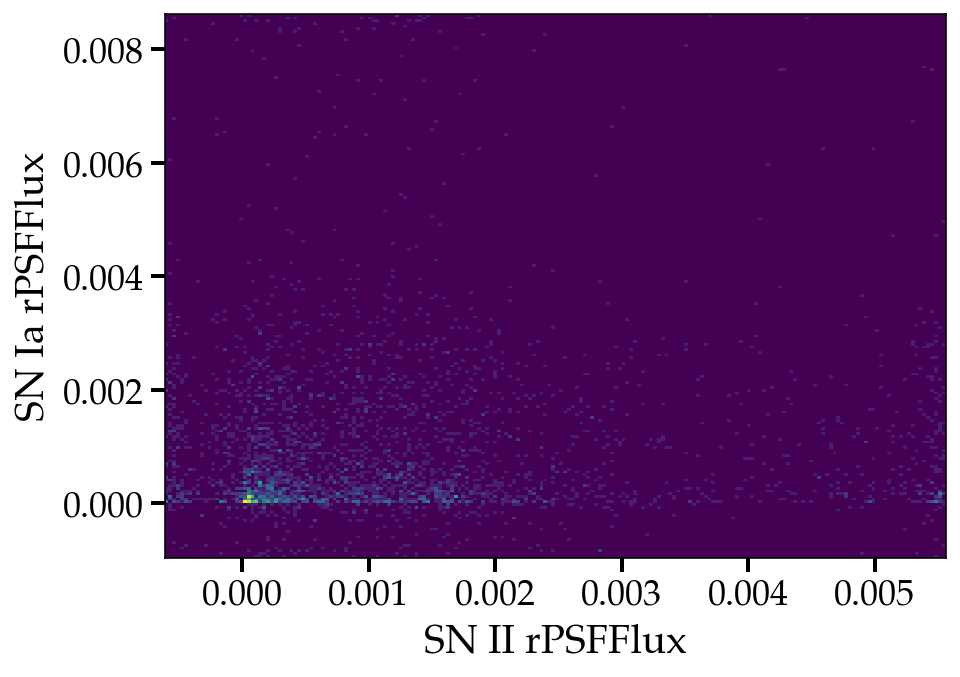

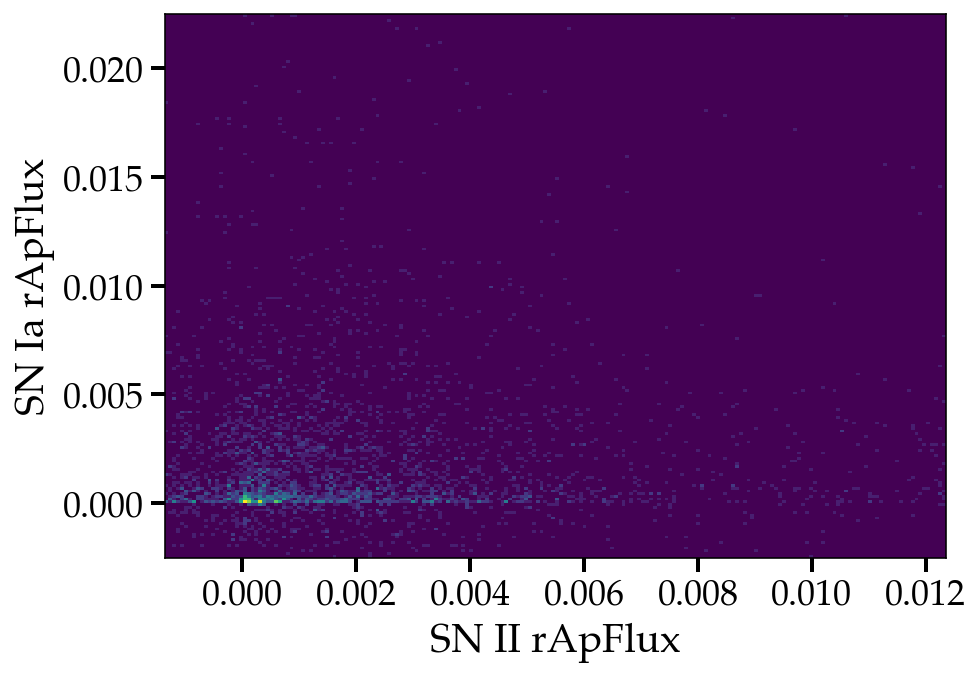

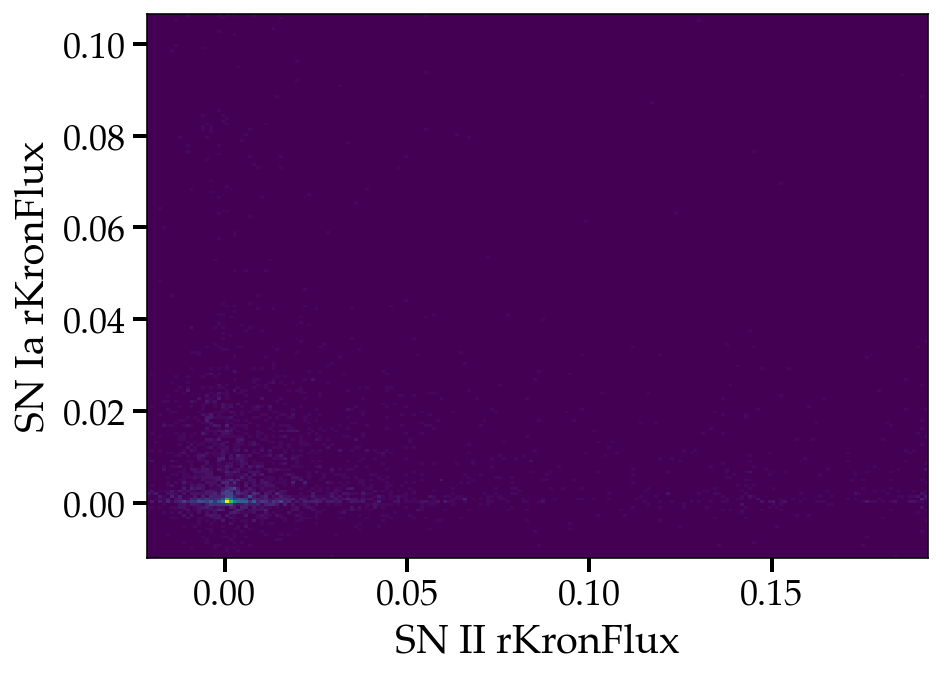

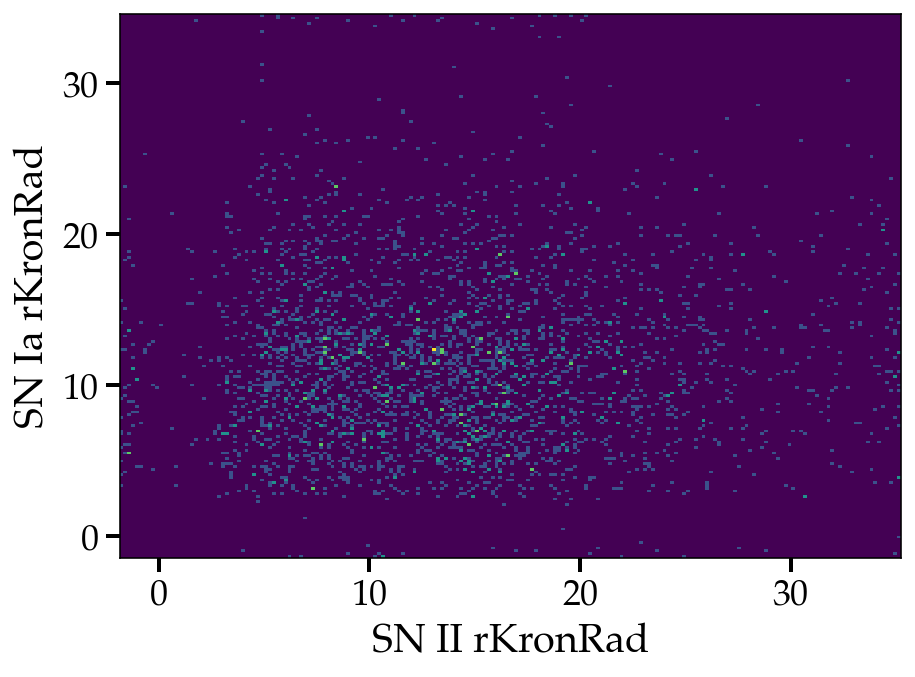

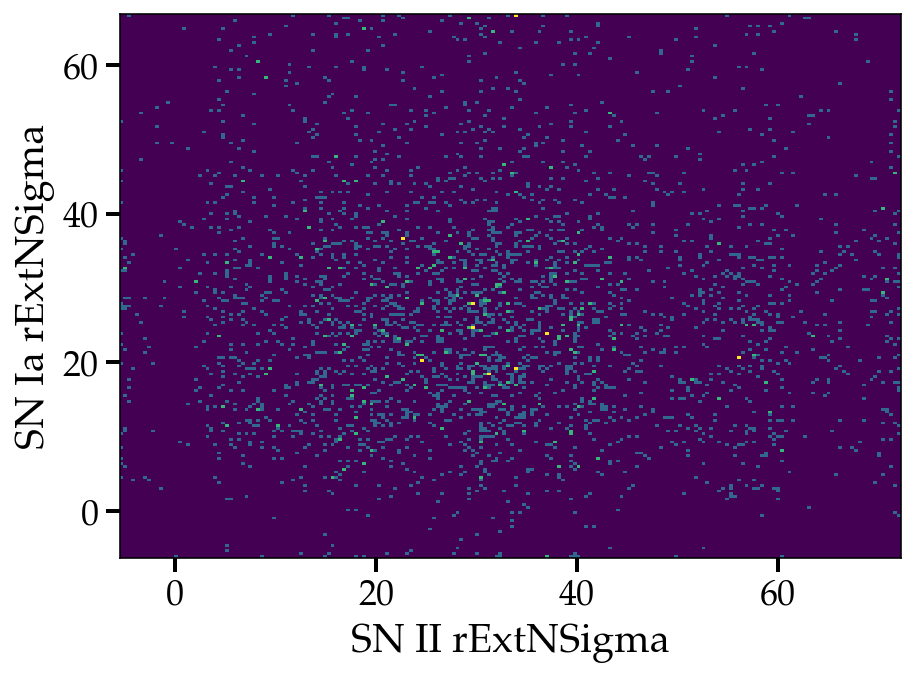

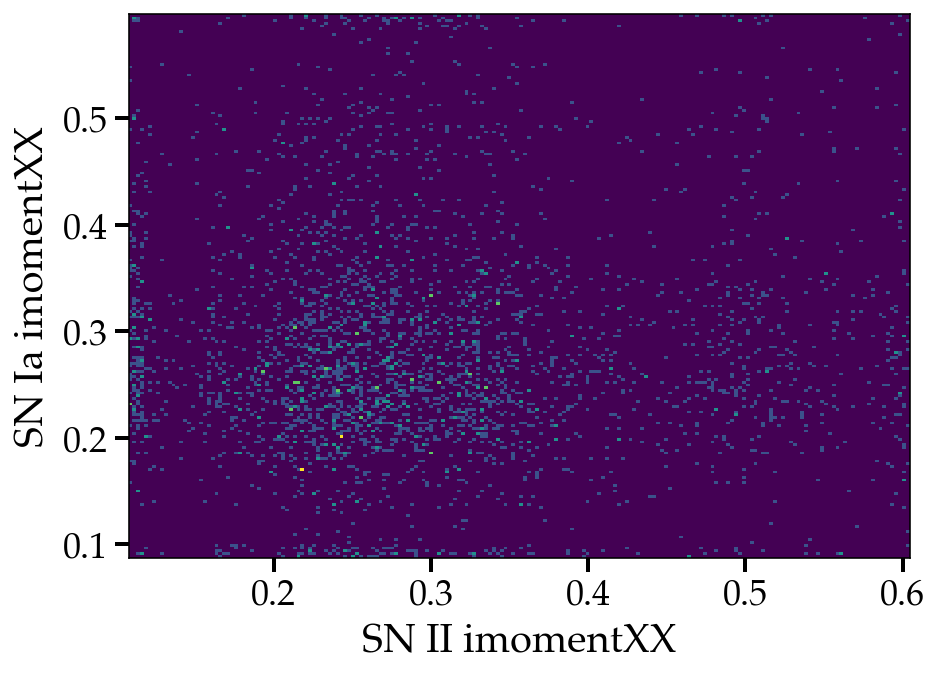

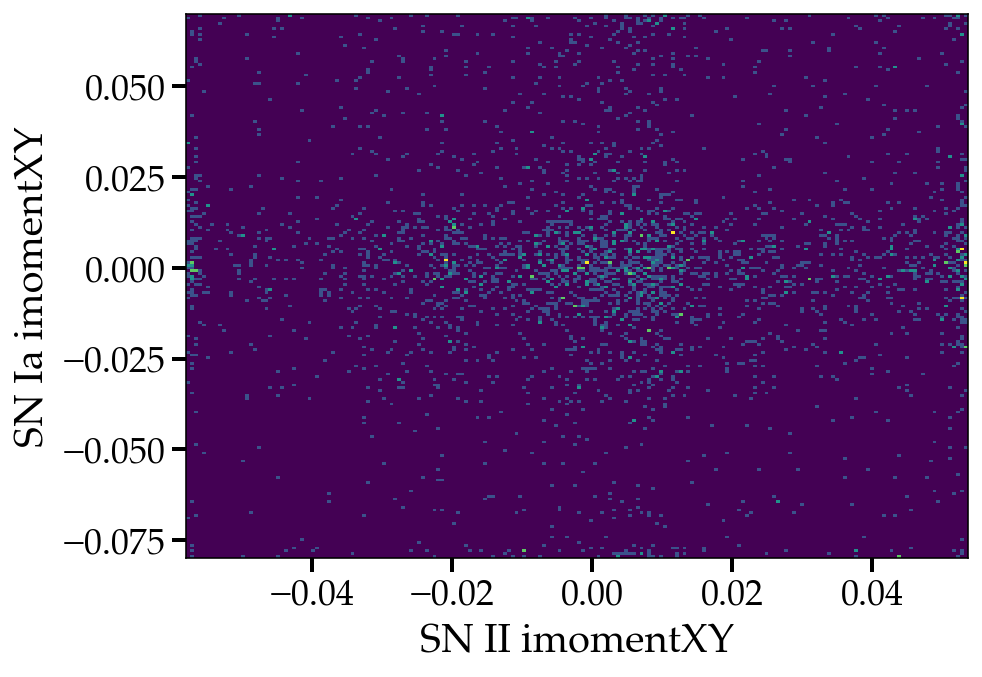

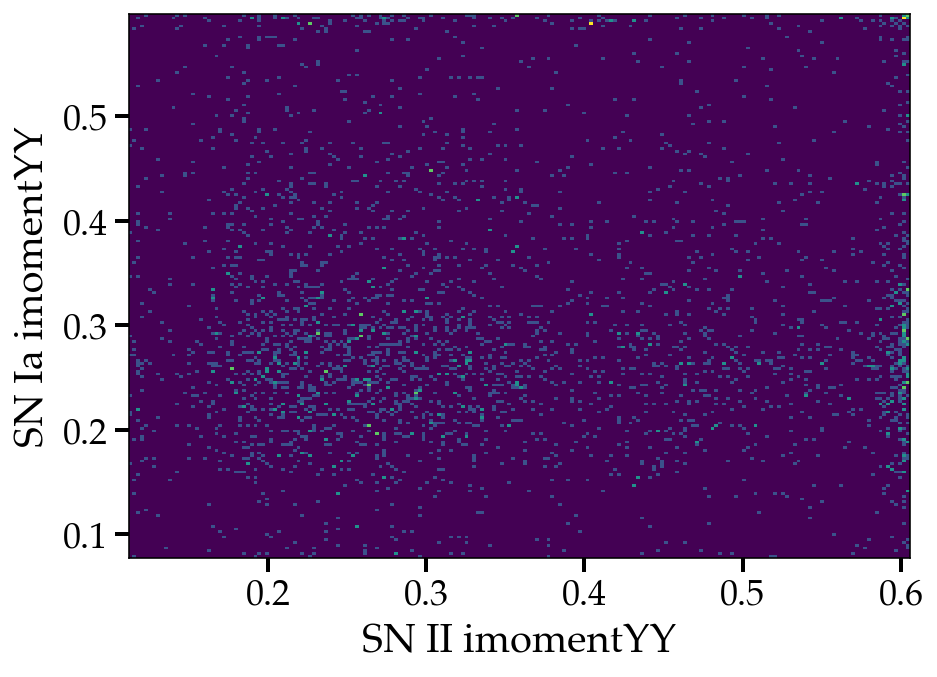

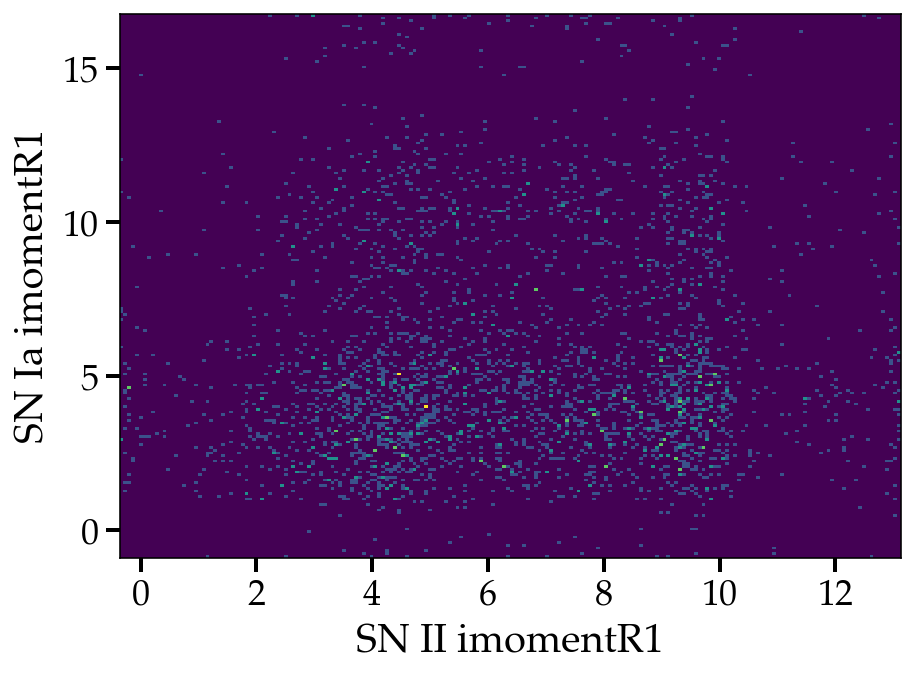

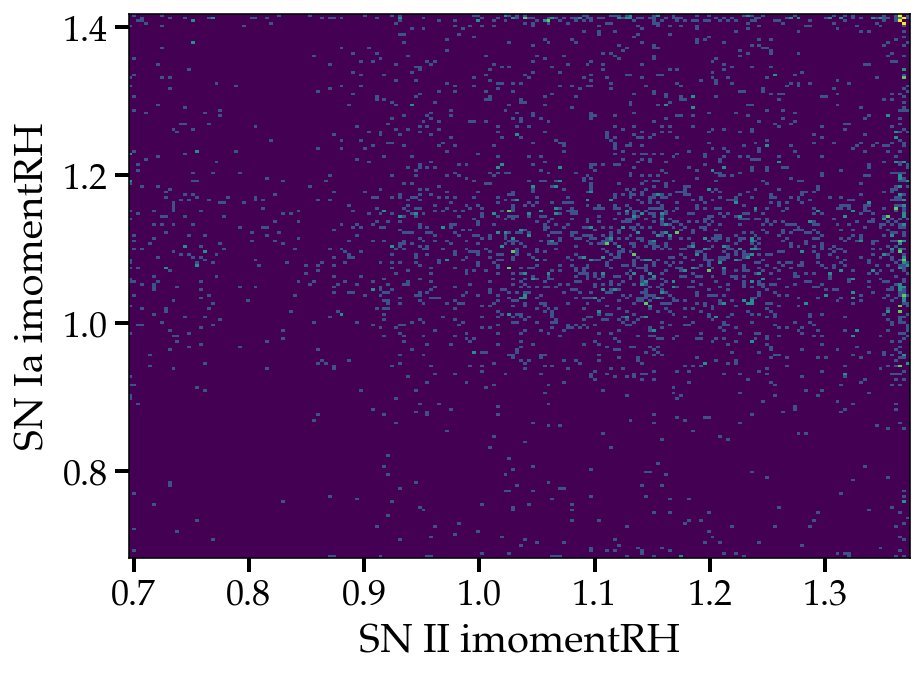

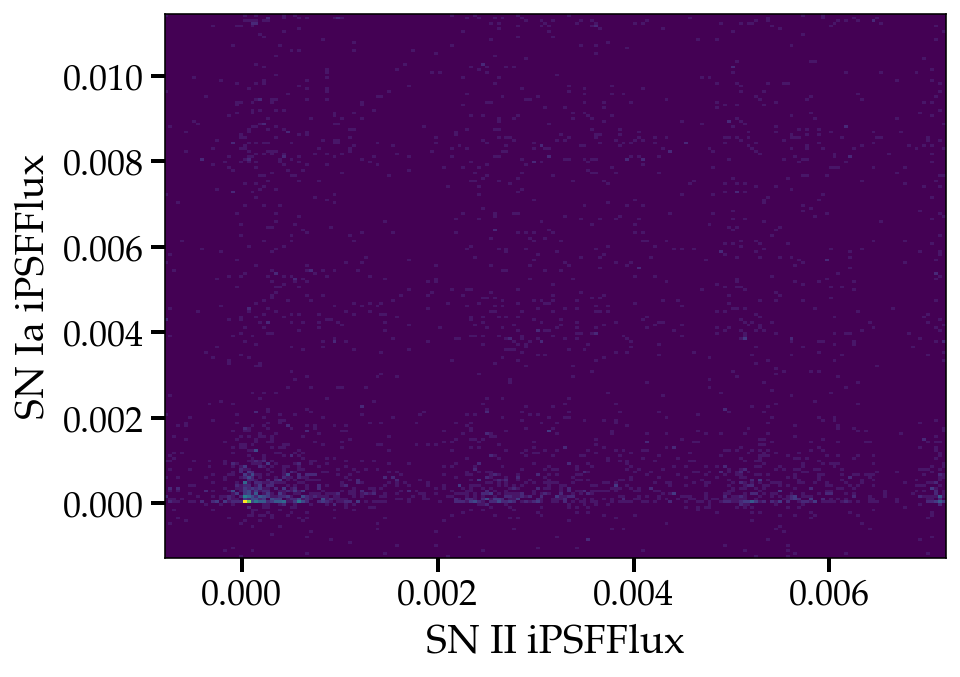

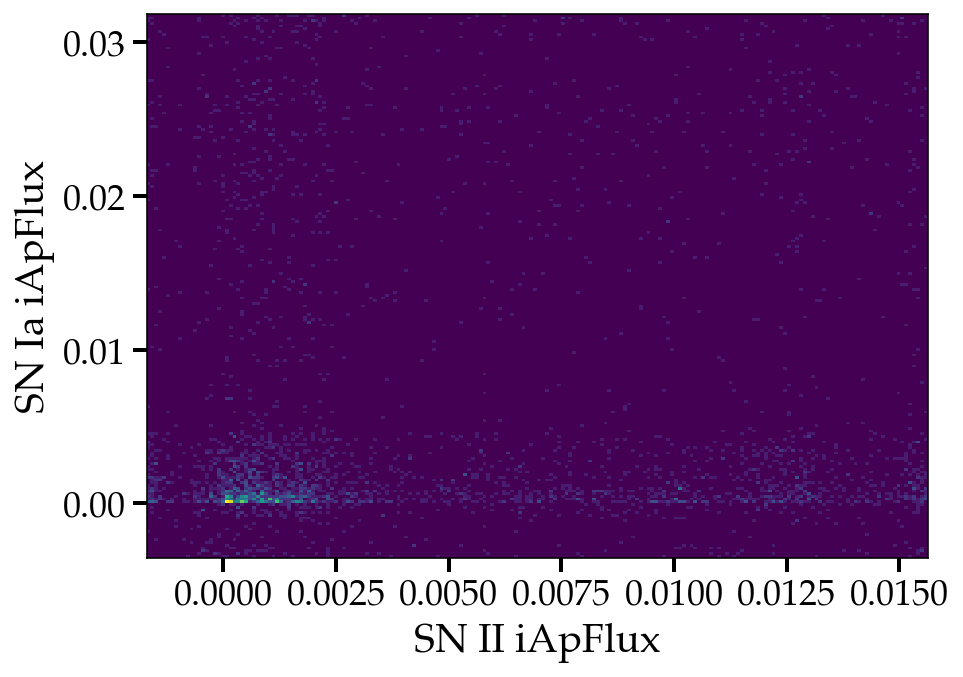

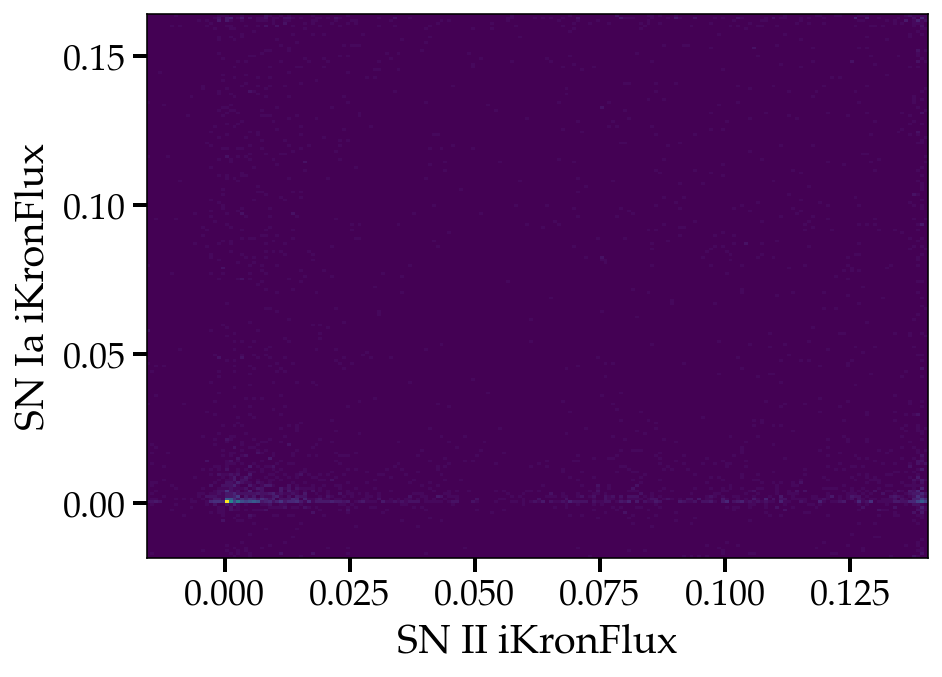

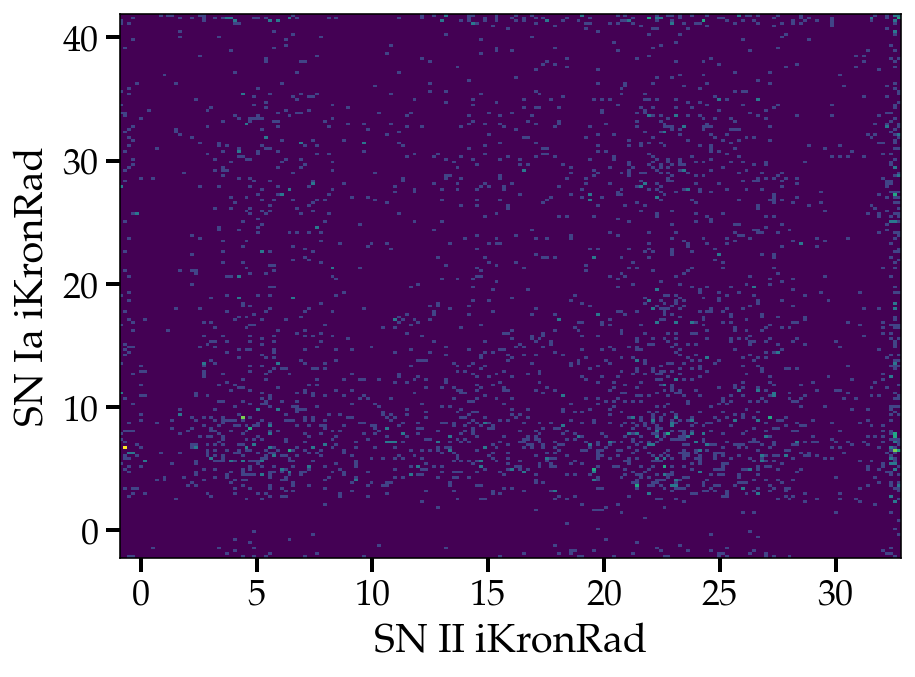

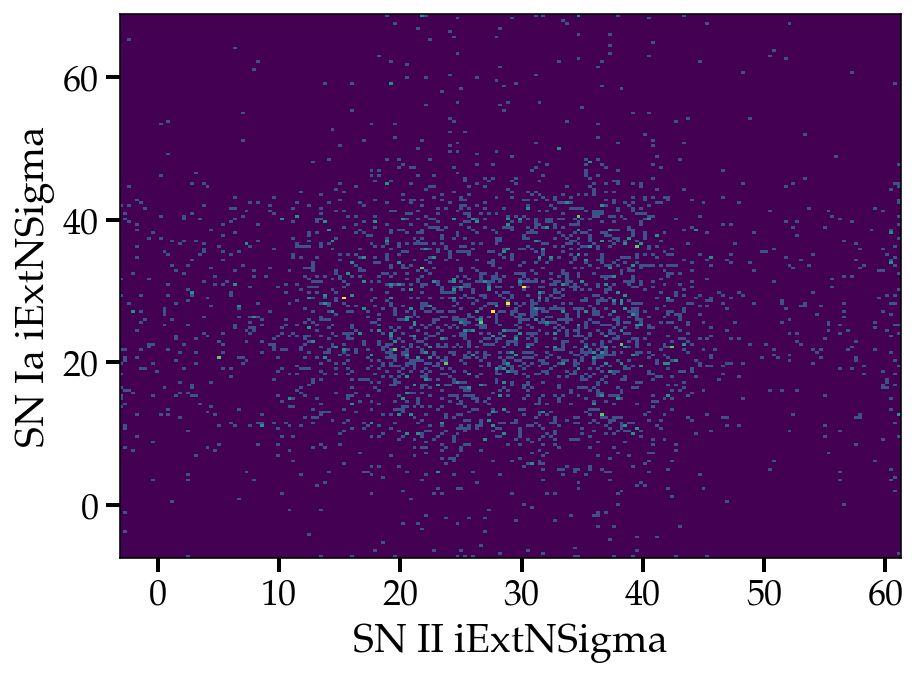

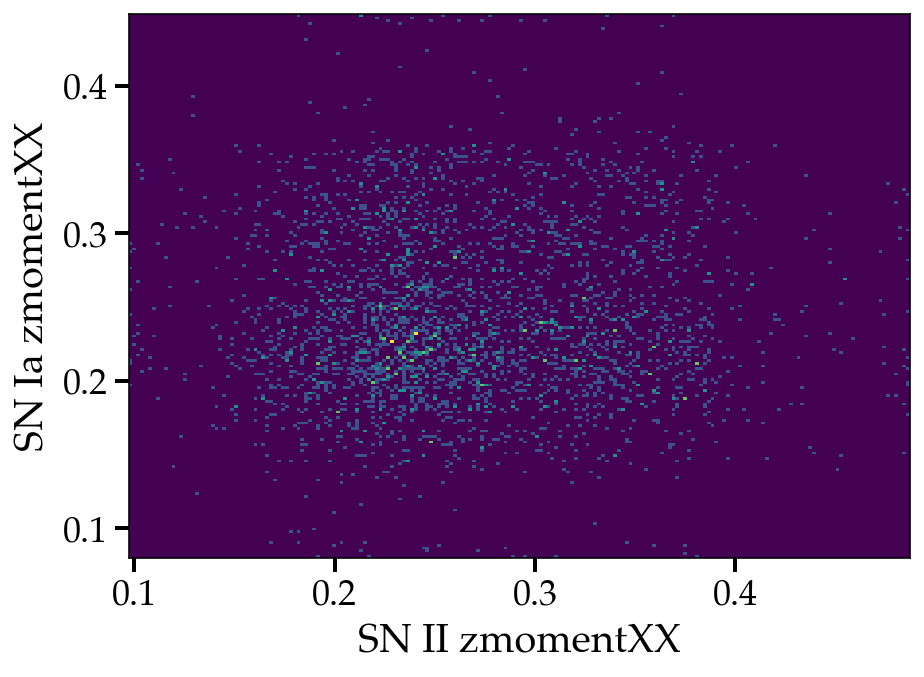

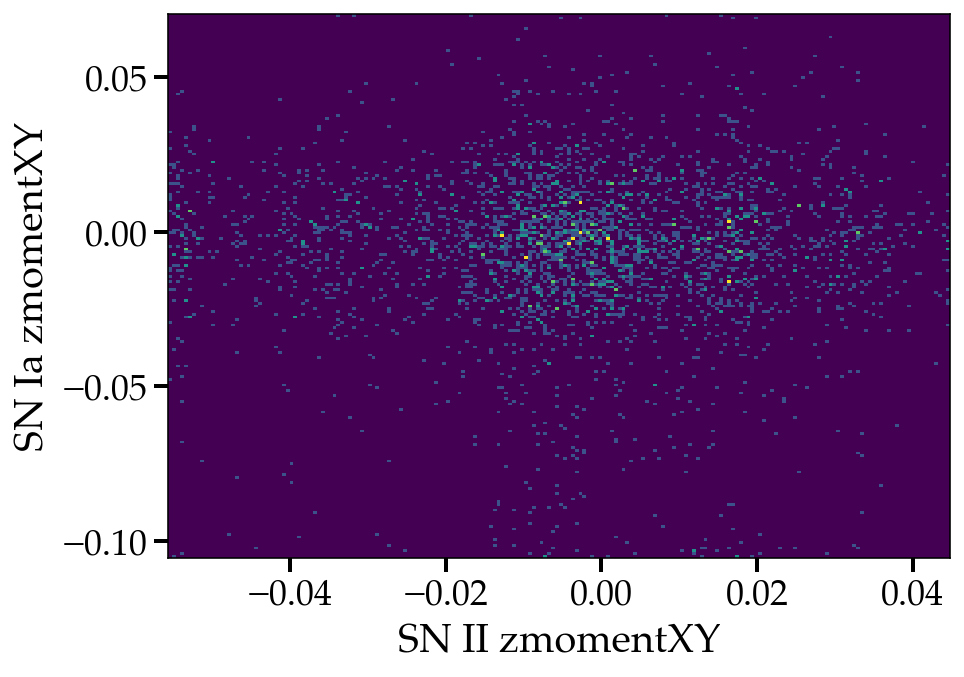

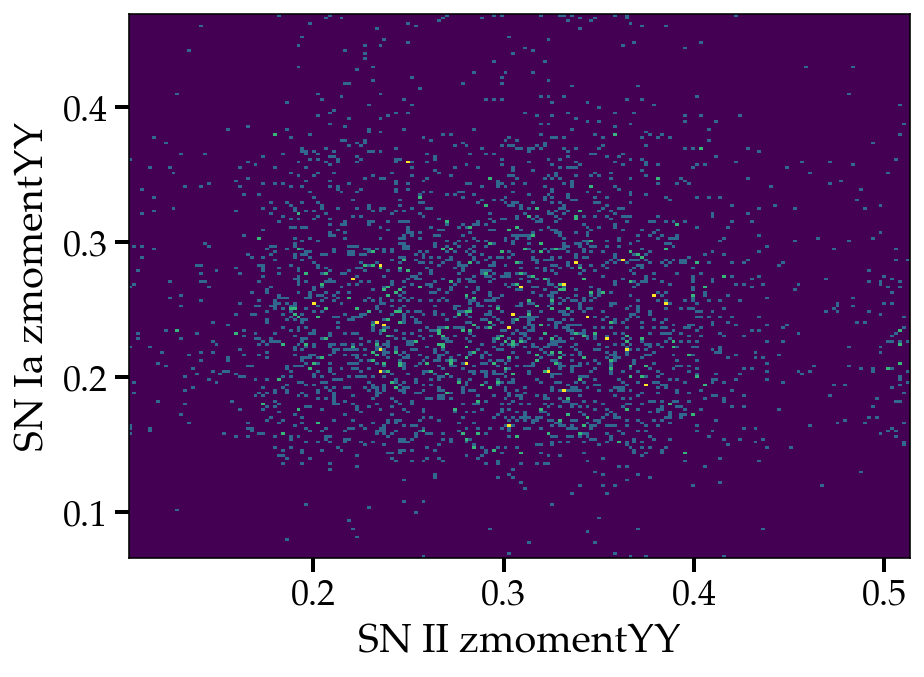

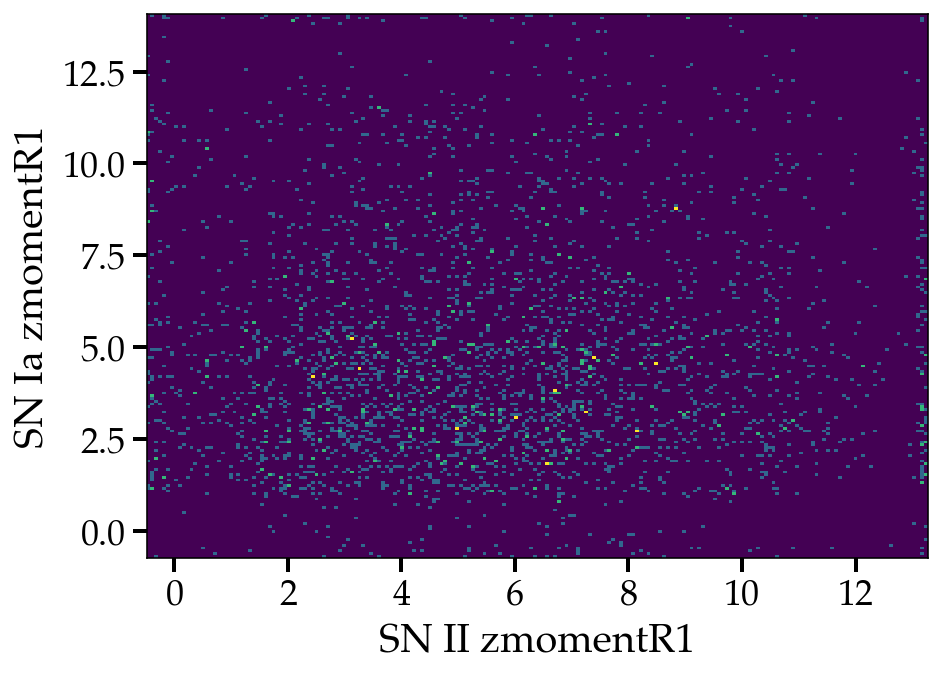

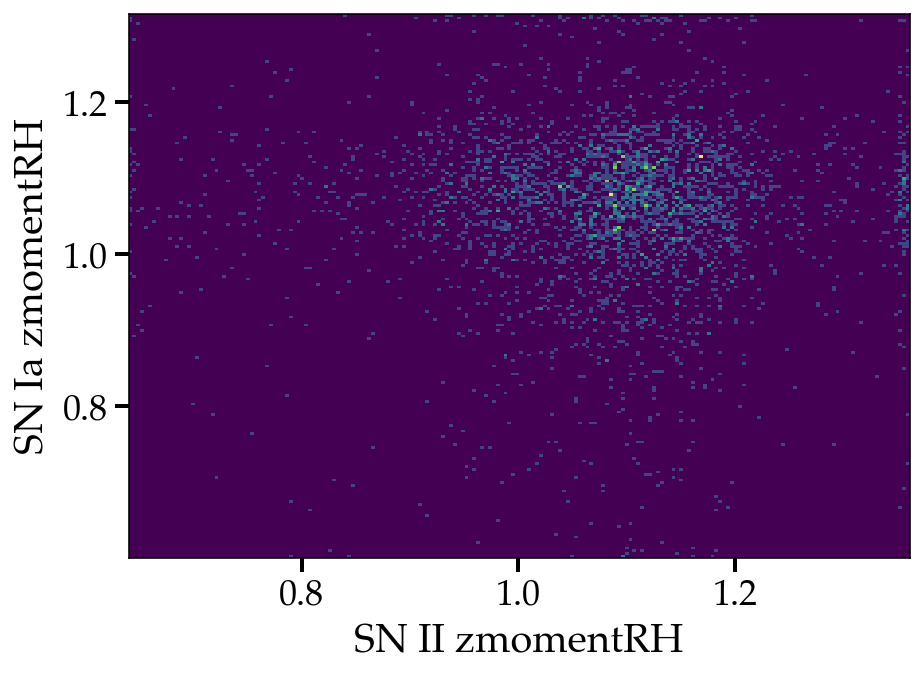

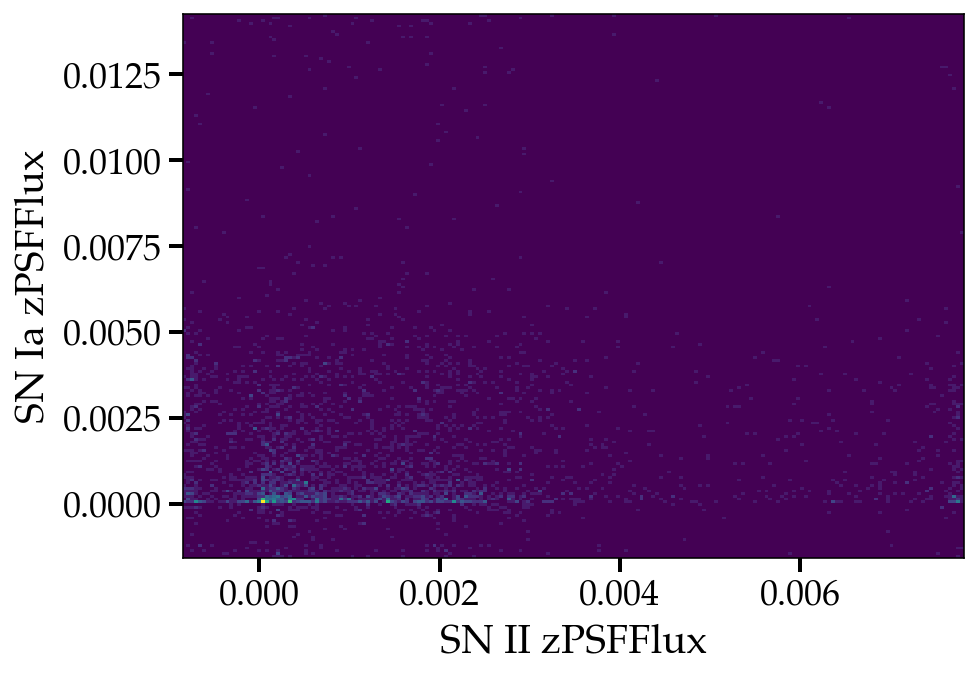

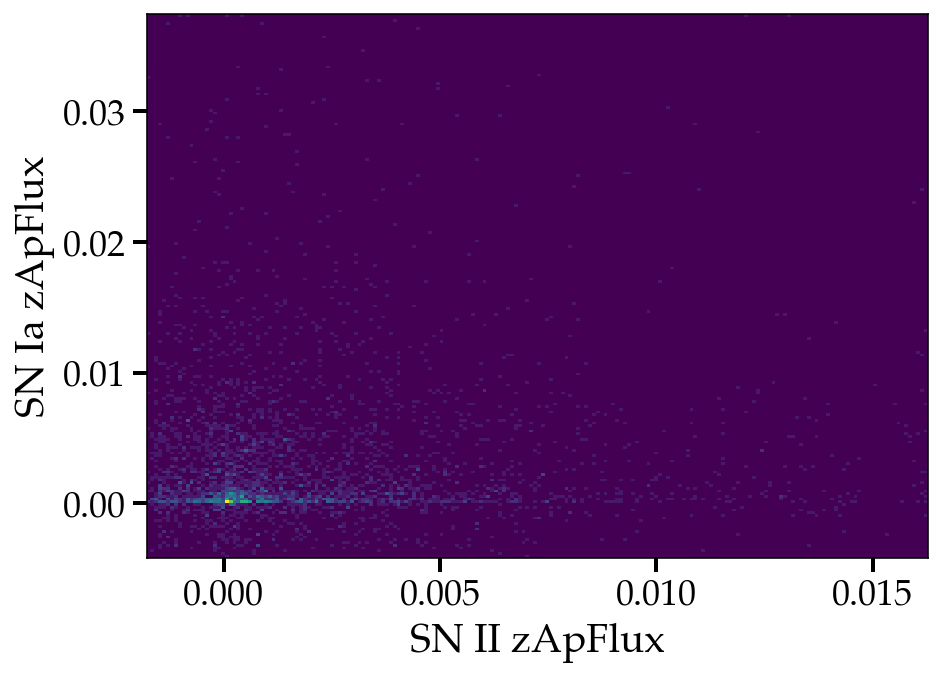

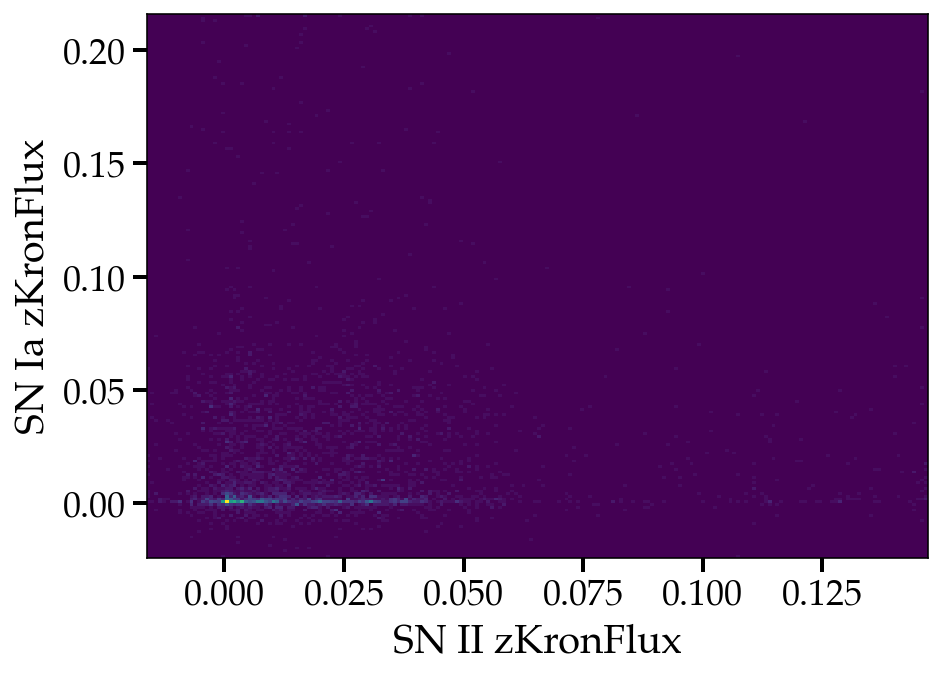

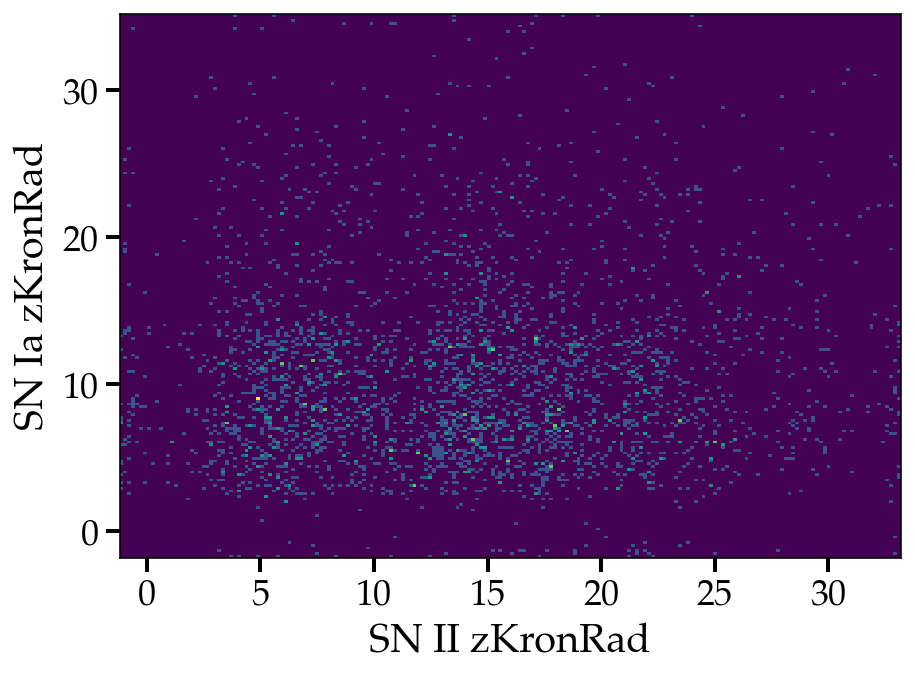

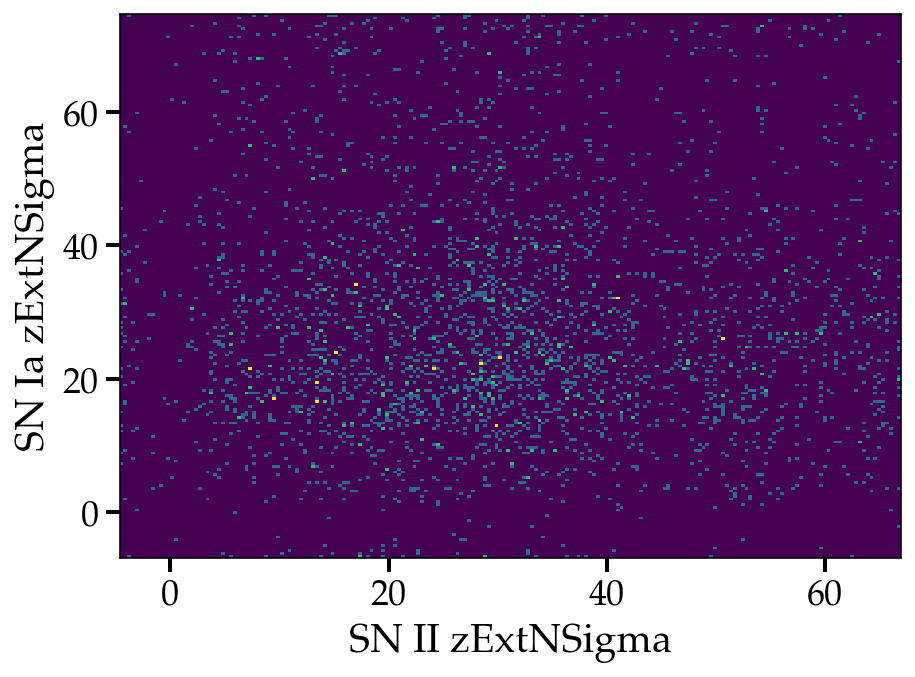

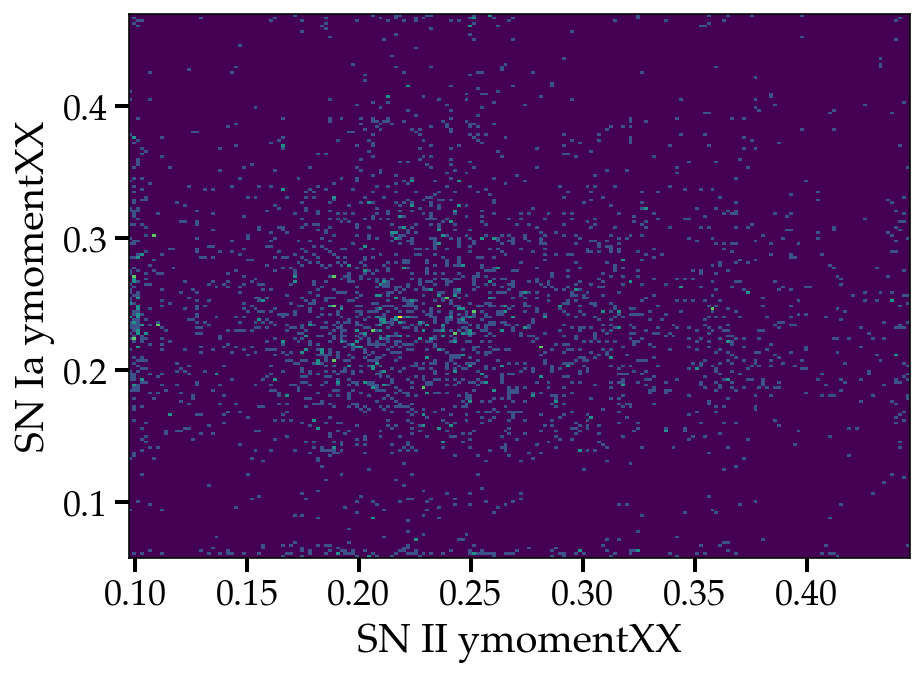

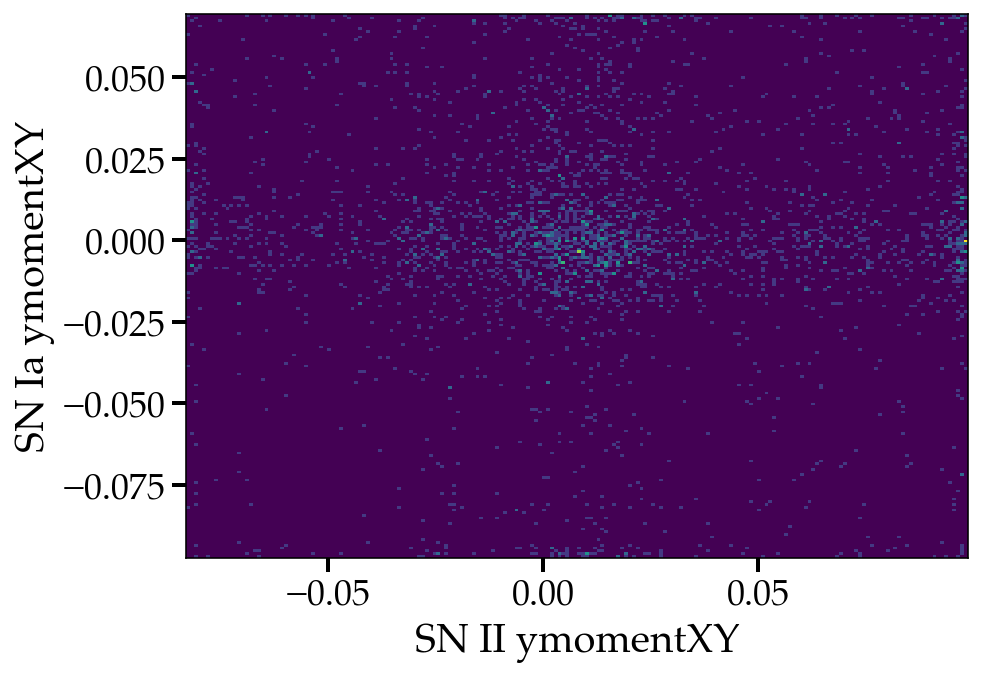

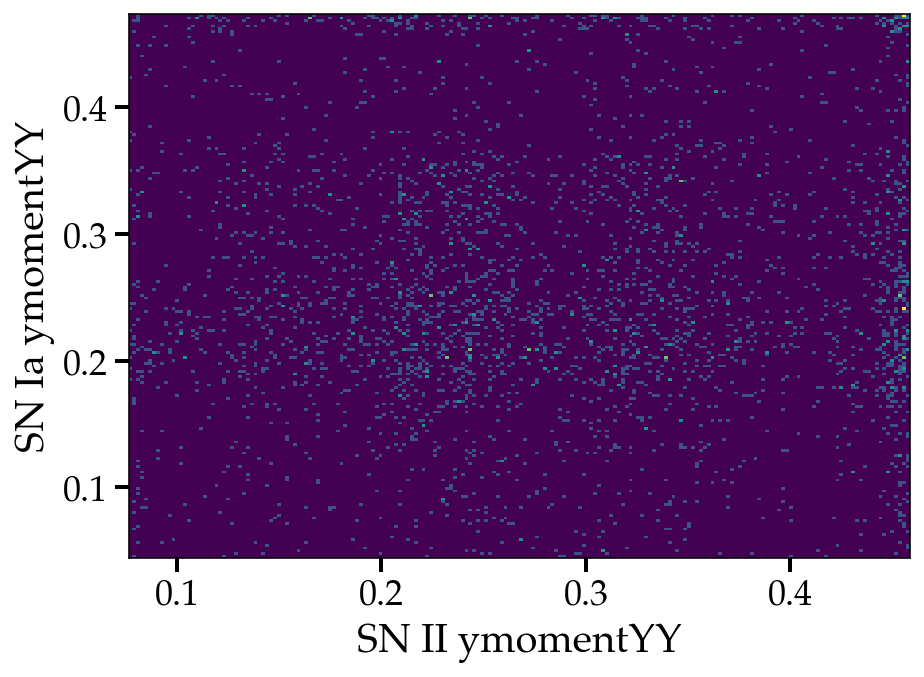

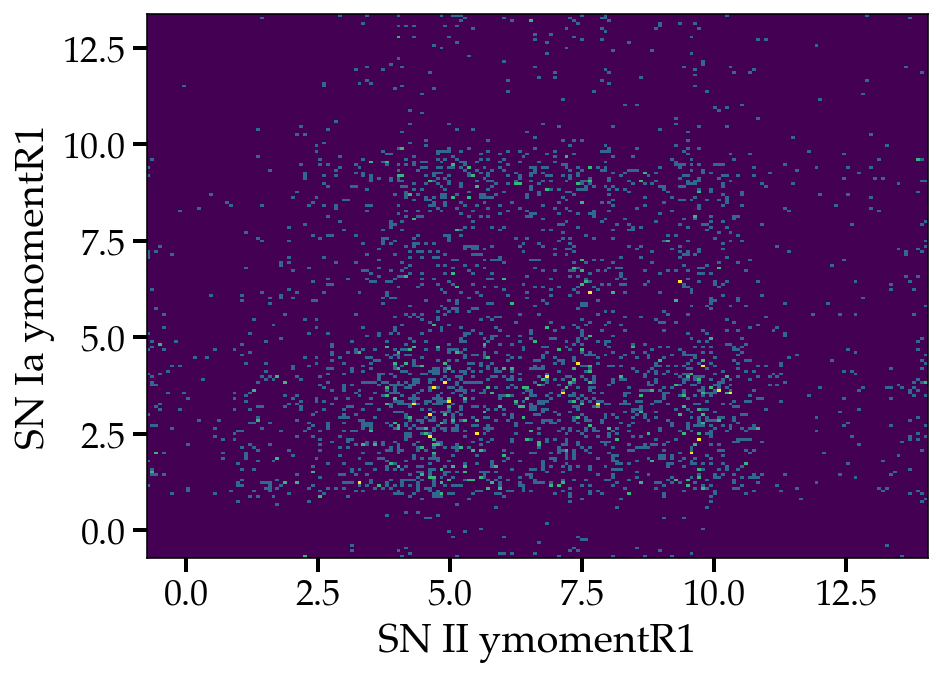

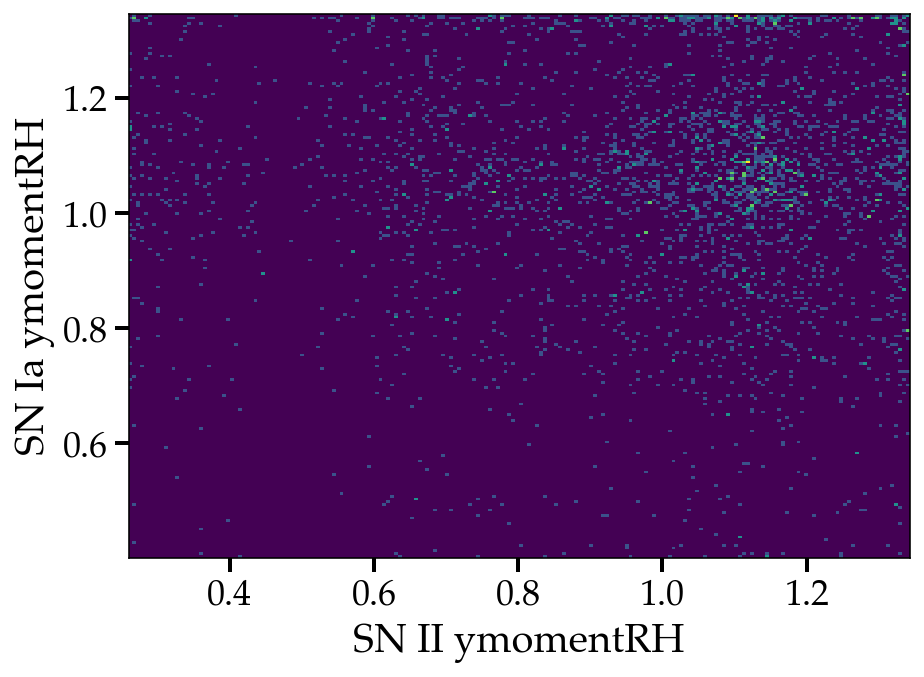

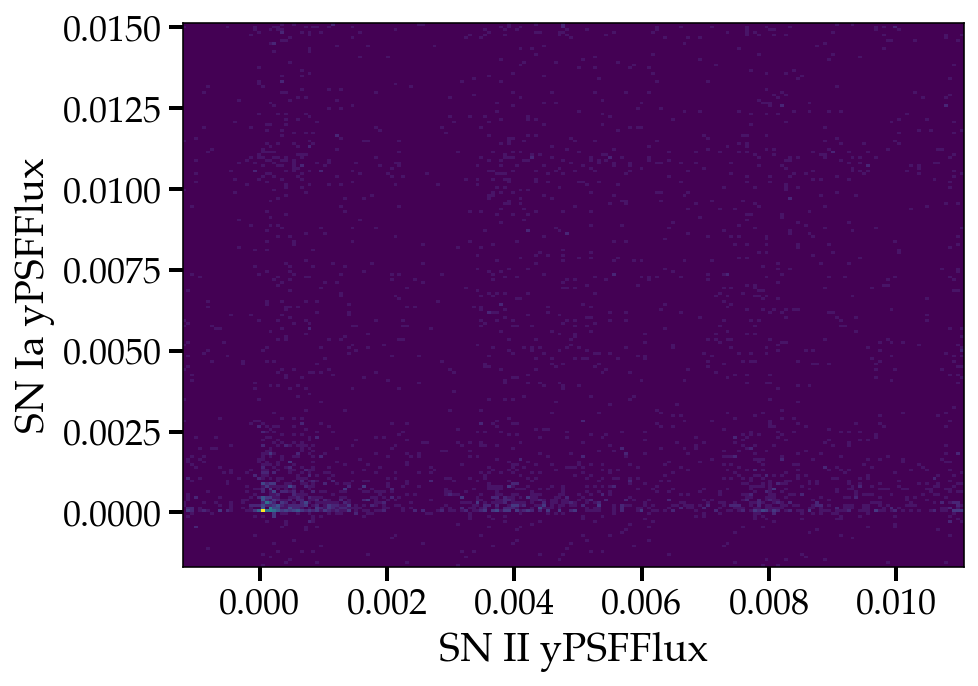

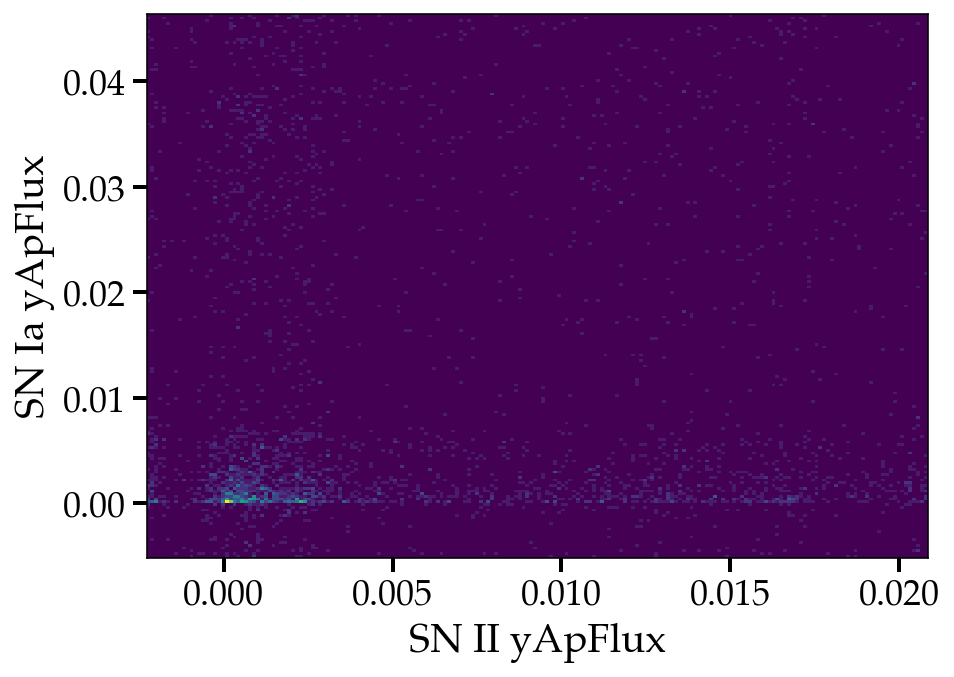

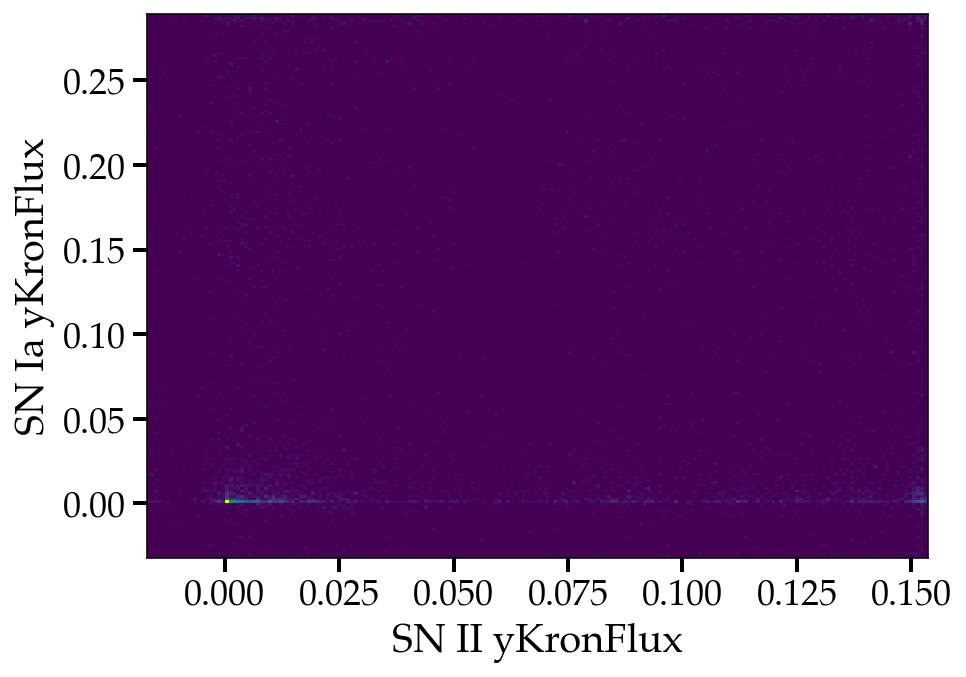

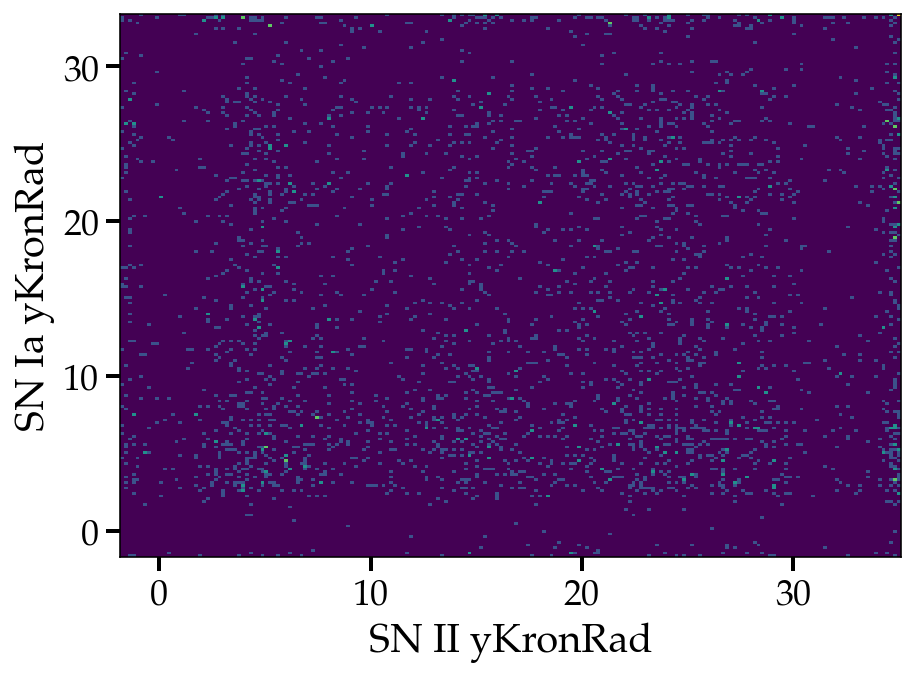

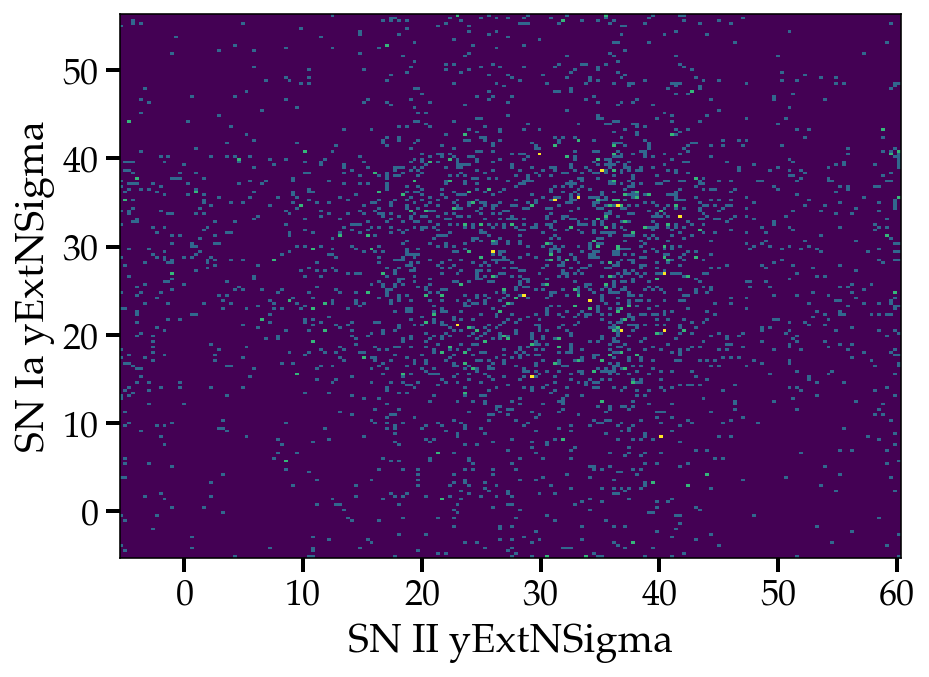

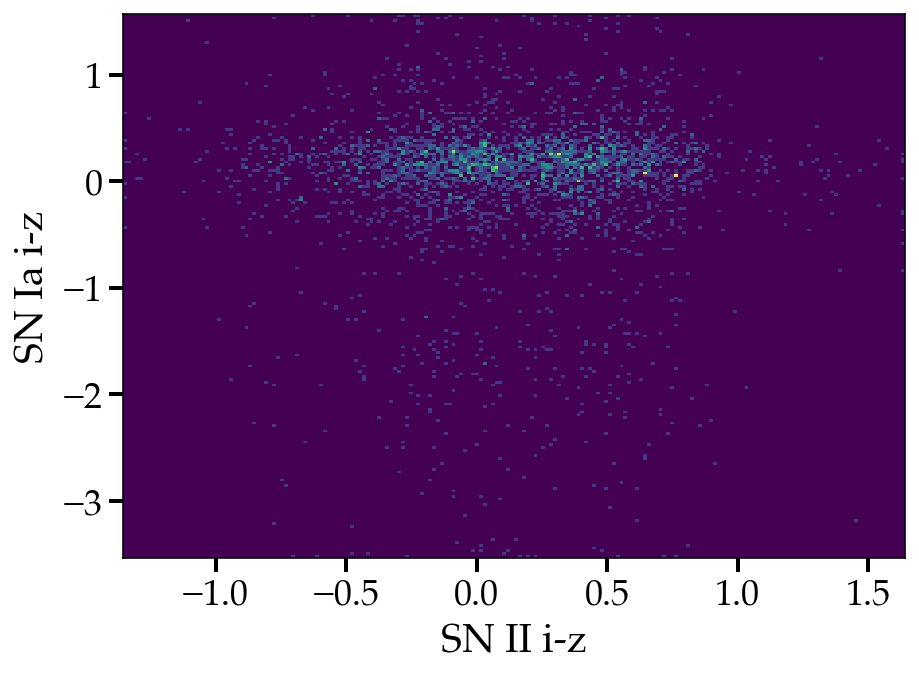

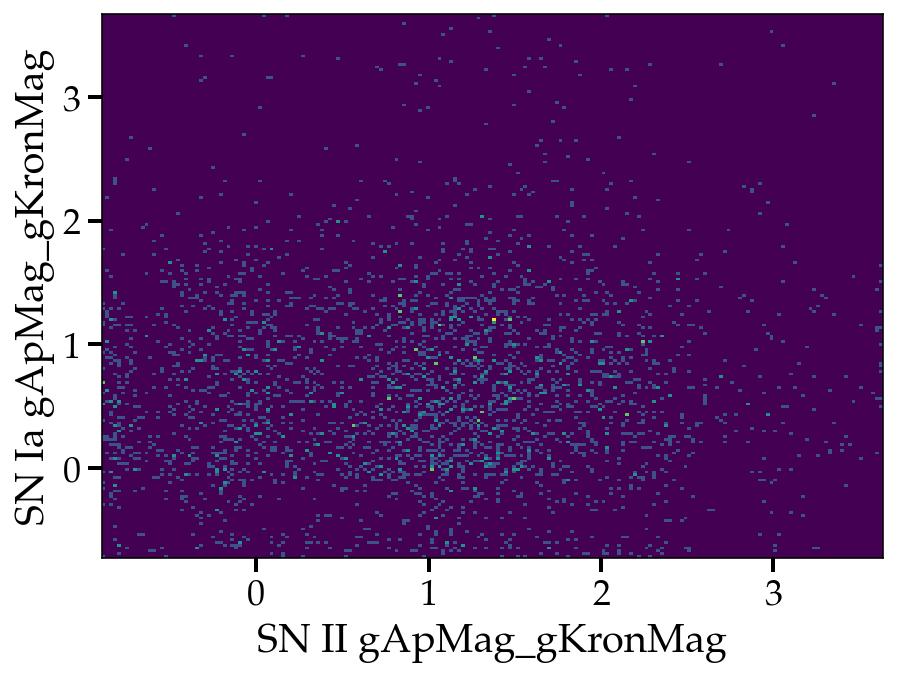

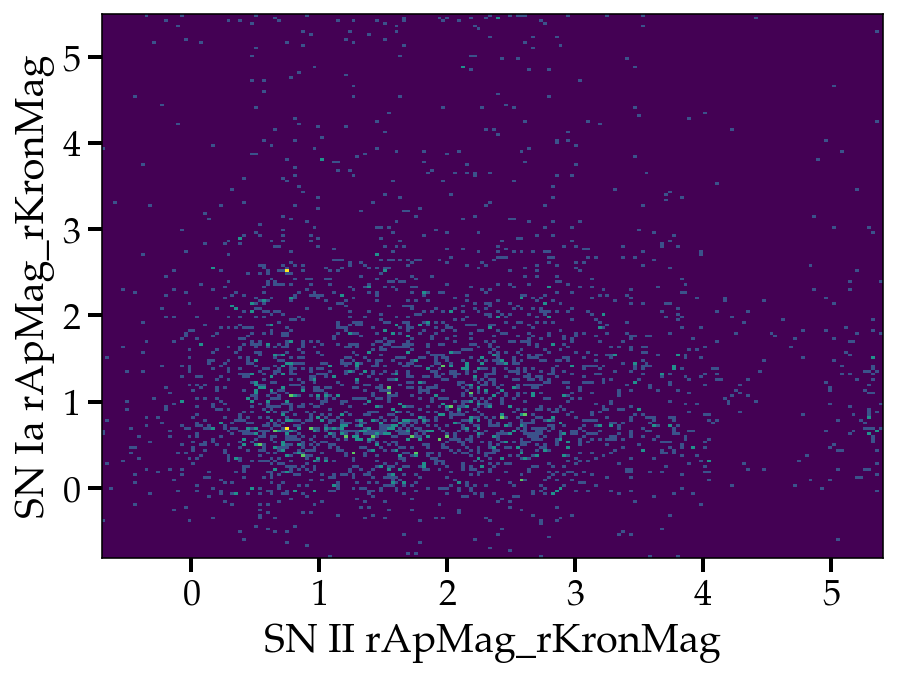

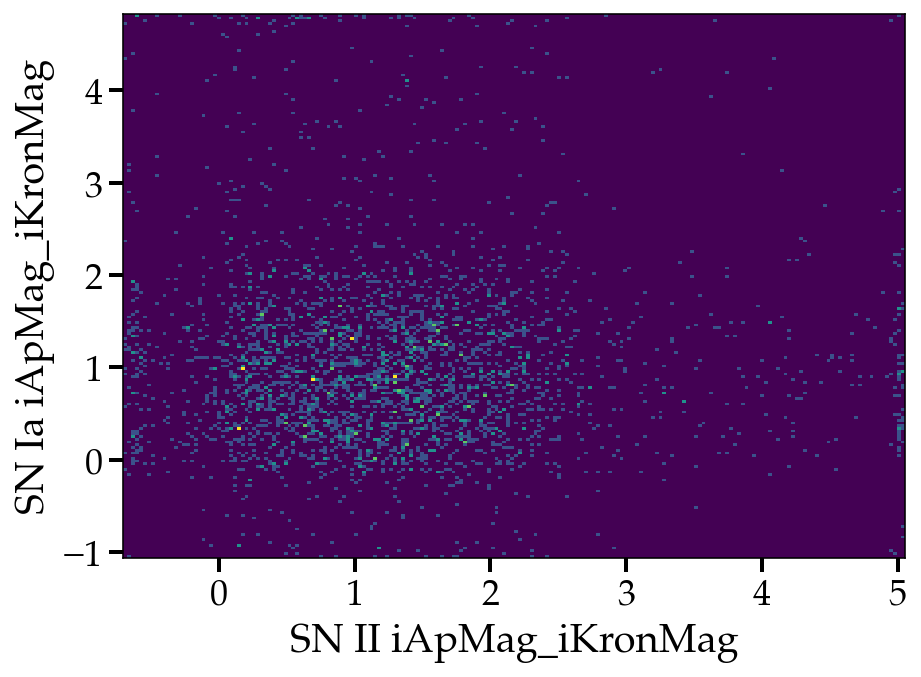

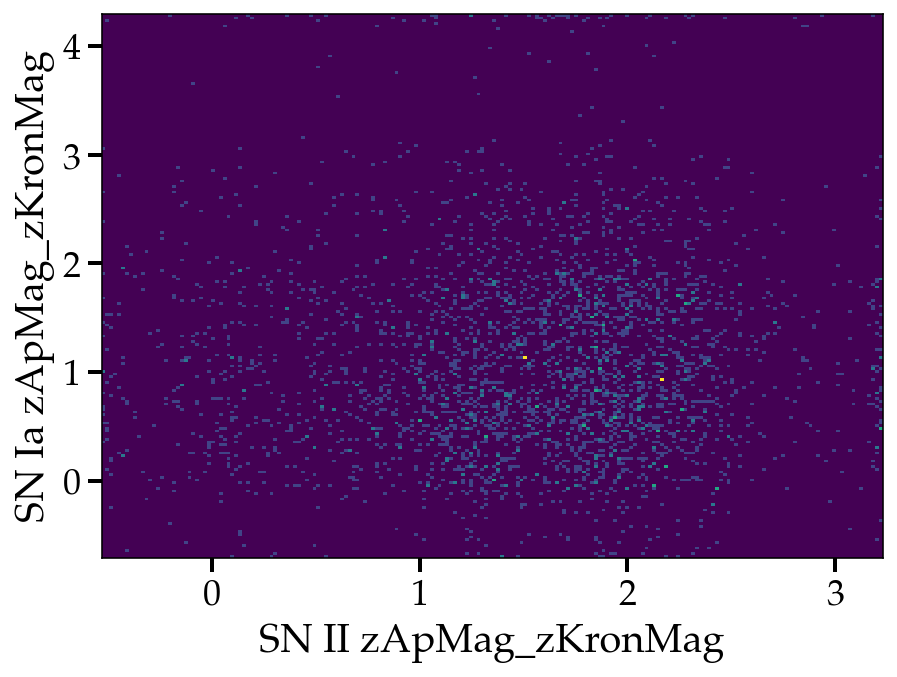

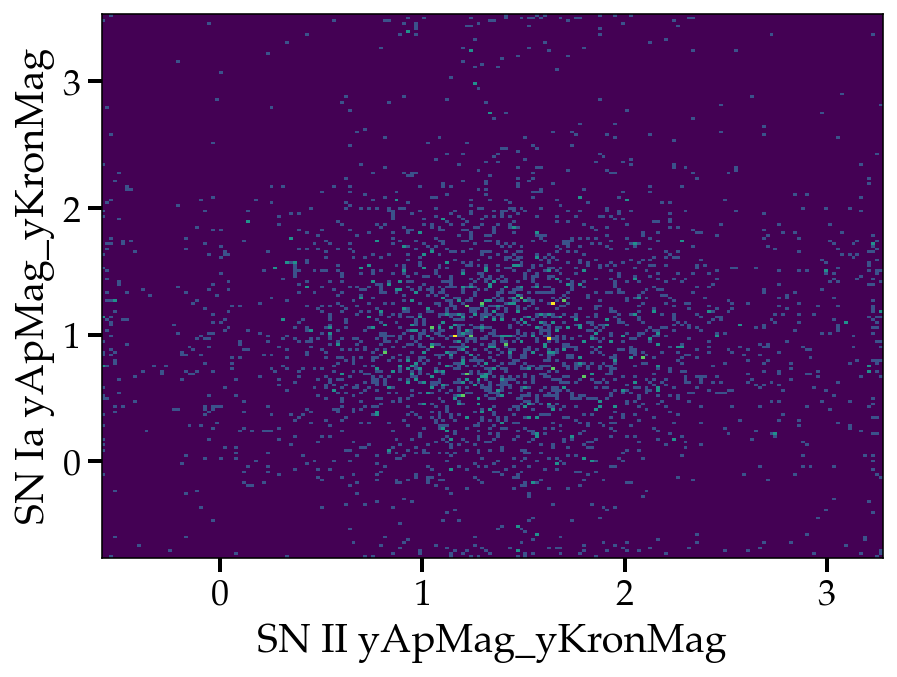

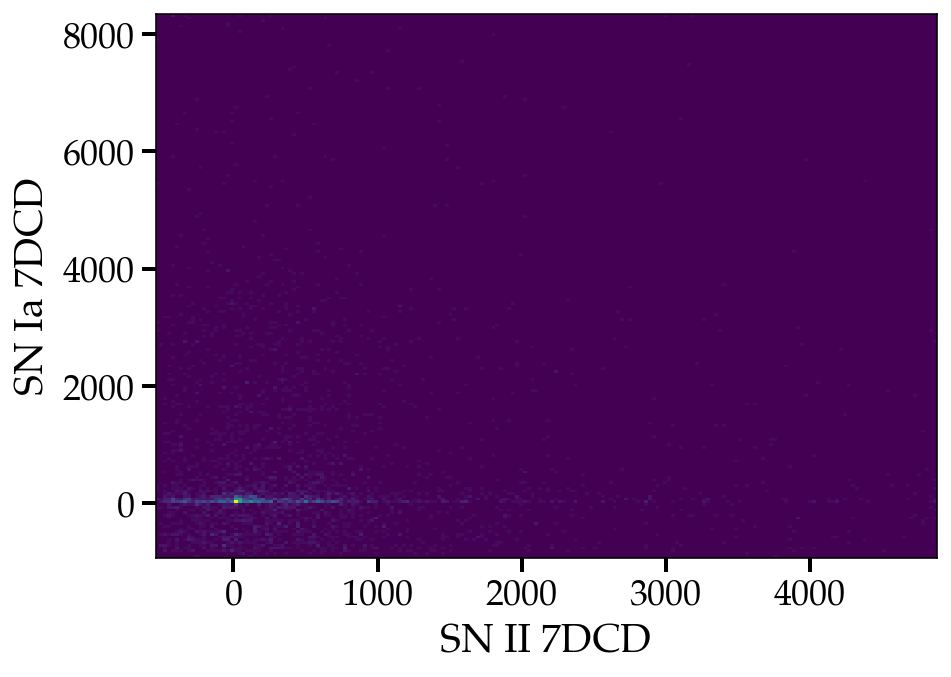

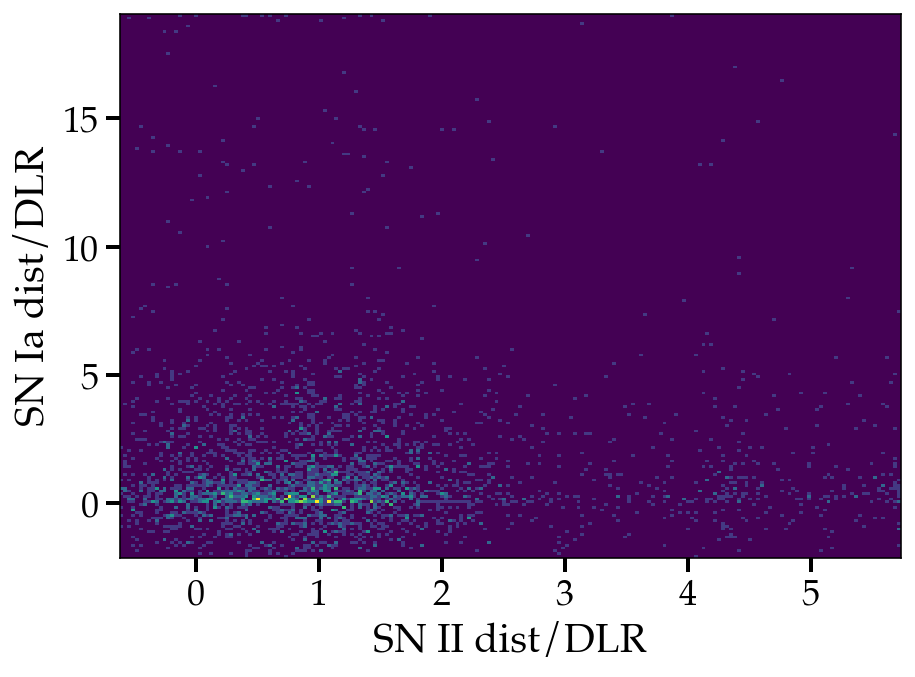

In [100]:
snii_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN II"]
snia_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN Ia"]

for i in range(0, 120, 1):
    feat = lc_and_host_features[0:120][i]
    plt.hist2d(snii_df[feat], snia_df[feat], bins=200)
    plt.xlabel(f"SN II {feat}")
    plt.ylabel(f"SN Ia {feat}")
    plt.show()